# Intelligent Supermarket

- Maria Catalina Ibáñez
- Lina María Gómez

In [1]:
#####################################################
# Importar librerias
#####################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from scipy import stats
import cv2
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import torchvision.models as models
from tqdm import tqdm

# display all
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **1-Entendimiento y preparación de los datos (20%)**

Genere un breve reporte de
entendimiento de datos en donde destaque las _dimensiones del dataset_, las
_características de las imágenes_ e _indicadores_ que considere importante. Integre técnicas
de aumento de datos y determine qué productos y que categorías empleará

In [2]:
#####################################################
# Cargar datos
#####################################################

# archivos base de datos de train, test y val
train_txt = pd.read_csv('dataset/train.txt', sep=',', header=None, names=['Image path', 'Class name', 'Coarse Class Name']) 
test_txt = pd.read_csv('dataset/test.txt', sep=',', header=None, names=['Image path', 'Class name', 'Coarse Class Name'])
val_txt = pd.read_csv('dataset/val.txt', sep=',', header=None, names=['Image path', 'Class name', 'Coarse Class Name'])

# nombres de las clases
class_csv = pd.read_csv('dataset/classes.csv')
class_csv.drop(columns=['Iconic Image Path (str)',
       'Product Description Path (str)'], inplace=True)

A continuación, se realizó la descripción de las **dimensiones del dataset**.

In [3]:
print(f"Train has {train_txt.shape[0]} images and {train_txt.shape[1]} columns")
print(f"Test has {test_txt.shape[0]} images and {test_txt.shape[1]} columns")
print(f"Val has {val_txt.shape[0]} images and {val_txt.shape[1]} columns")

Train has 2640 images and 3 columns
Test has 2485 images and 3 columns
Val has 296 images and 3 columns


Además, se realizaron pruebas para ver si los tres conjuntos tienen la misma cantidad de clases. Se encontraron en total 43 clases para los dos últimos conjuntos y 37 para el de validación. A continuación, se muestran los resultados de las clases que faltan en validación.

In [4]:
total_number_coarse_classes = len(class_csv['Coarse Class ID (int)'].unique())
print(f"There are {total_number_coarse_classes} classes")

try:
    assert len(train_txt["Coarse Class Name"].unique()) ==  total_number_coarse_classes
    print("In train dataset all classes are present")
    assert len(test_txt["Coarse Class Name"].unique()) ==  total_number_coarse_classes
    print("In test dataset all classes are present")
    assert len(val_txt["Coarse Class Name"].unique()) ==  total_number_coarse_classes
    print("All classes are present in val dataset")
except:
    print("Not all classes are present in the three datasets")

missing_classes = set(class_csv['Coarse Class ID (int)']) - set(val_txt['Coarse Class Name'])
print(f"Missing classes in val dataset: {missing_classes}")


There are 43 classes
In train dataset all classes are present
In test dataset all classes are present
Not all classes are present in the three datasets
Missing classes in val dataset: {33, 8, 10, 15, 24, 26}


Ahora, se realizará la descripción de las **características de las imágenes**. Para esto se cargaron las imágenes y se mostrarán por clase las imágenes de cada conjunto 'Coarse Class Name'. En primer lugar se calcularán estadísticas como mean, median, mode, std, min y max de las imágenes por clase en el set de entrenamiento.

In [5]:
#####################################################
# Cargar imagenes
#####################################################

def load_image(path, base_path='dataset/'):
    """
    Load an image from a path and return it as a numpy array in RGB format
    """
    full_path = base_path + path
    img = cv2.imread(full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

train_txt["Image"] = train_txt["Image path"].apply(load_image)
test_txt["Image"] = test_txt["Image path"].apply(load_image)
val_txt["Image"] = val_txt["Image path"].apply(load_image)

In [6]:
###################################################
# Transformar variables a categoricas
###################################################

train_txt["Coarse Class Name"] = train_txt["Coarse Class Name"].astype('category')
val_txt["Coarse Class Name"] = val_txt["Coarse Class Name"].astype('category')
test_txt["Coarse Class Name"] = test_txt["Coarse Class Name"].astype('category')
class_csv["Coarse Class ID (int)"] = class_csv["Coarse Class ID (int)"].astype('category')

In [7]:
###################################################
# Merge de datasets
###################################################

train_merged = train_txt.merge(
    class_csv,
    left_on='Coarse Class Name',
    right_on='Coarse Class ID (int)',
    how='left'
)

val_merged = val_txt.merge(
    class_csv,
    left_on='Coarse Class Name',
    right_on='Coarse Class ID (int)',
    how='left'
)

test_merged = test_txt.merge(
    class_csv,
    left_on='Coarse Class Name',
    right_on='Coarse Class ID (int)',
    how='left'
)

In [8]:
statistics = pd.DataFrame(columns=['Category','Mean', 'Median','Mode','Std', 'Min', 'Max'])
list_of_categories = train_merged['Coarse Class Name'].unique()

for category in tqdm(list_of_categories):
    class_name = class_csv[class_csv['Coarse Class ID (int)'] == category]['Class Name (str)'].values[0]
    category_images = train_merged[train_merged['Coarse Class Name'] == category]['Image']
    all_pixels = np.concatenate([img.ravel() for img in category_images])
    
    new_row = pd.DataFrame({
        'Category': [category],
        'Class Name': [class_name],
        'Mean': [np.mean(all_pixels)],      
        'Median': [np.median(all_pixels)], 
        'Mode': [stats.mode(all_pixels)[0][0]],
        'Std': [np.std(all_pixels)],
        'Min': [np.min(all_pixels)],
        'Max': [np.max(all_pixels)]
    })
    
    statistics = pd.concat([statistics, new_row], ignore_index=True)

statistics

  0%|          | 0/43 [00:00<?, ?it/s]/tmp/ipykernel_432283/102855835.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  'Mode': [stats.mode(all_pixels)[0][0]],
100%|██████████| 43/43 [02:26<00:00,  3.41s/it]


Category        Mean  Median Mode        Std Min  Max  \
0         0   95.922515    88.0    0  65.825934   0  255   
1         1  102.281751    95.0    0  63.598877   0  255   
2         2   91.792894    84.0    0  64.948384   0  255   
3         3  105.756779   100.0   85  62.103344   0  255   
4         4  102.889052   103.0    0  69.275204   0  255   
5         5   82.776393    78.0    0  62.330052   0  255   
6         6   96.091123    95.0    0  60.124455   0  255   
7         7   99.820713    95.0    0  65.103549   0  255   
8         8   90.919847    74.0   27  66.205846   0  255   
9         9   95.616770    86.0   15  72.274344   0  255   
10       10   91.528252    85.0   20  63.484851   0  255   
11       11   92.635170    85.0   18  63.795475   0  255   
12       12   96.553381    85.0    0  63.053871   0  255   
13       13   96.096010    93.0    0  62.841954   0  255   
14       14   95.044834    89.0    0  59.374279   0  255   
15       15   94.562306    87.0   14  65.759597   0  255   
16       16  100.691327    89.0   32  66.208096   0  255   
17       17   96.277795    91.0    0  69.277167   0  255   
18       18   90.660723    78.0    0  74.366191   0  255   
19       19  106.396381   103.0   21  61.893470   0  255   
20       20  106.830226   105.0  111  59.268007   0  255   
21       21  110.832235   111.0  124  58.518513   0  255   
22       22  120.303072   120.0  105  57.132852   0  255   
23       23  114.204314   112.0   98  57.593089   0  255   
24       24  105.986637   103.0   95  59.129198   0  255   
25       25  115.895705   116.0  122  59.296692   0  255   
26       26  119.709305   120.0  125  55.751905   0  255   
27       27  114.865658   112.0  100  59.226431   0  255   
28       28   96.998203    90.0    0  63.846668   0  255   
29       29   91.689251    77.0   11  71.012916   0  255   
30       30   99.885790   102.0    0  56.496091   0  255   
31       31   93.011720    80.0   25  65.550465   0  255   
32       32   87.947438    80.0    0  59.840445   0  255   
33       33  111.952486   113.0  137  61.935275   0  255   
34       34  116.522414   119.0  120  59.276401   0  255   
35       35   93.175822    86.0    0  57.963451   0  255   
36       36   89.689160    77.0    0  65.825078   0  255   
37       37  101.258453    97.0   14  62.654984   0  255   
38       38   87.577107    73.0    0  68.607252   0  255   
39       39  105.964104   105.0    0  63.478104   0  255   
40       40  104.146104    99.0  255  64.077187   0  255   
41       41   87.087273    61.0   26  68.426694   0  255   
42       42   88.377993    76.0    0  66.151069   0  255   

                         Class Name  
0                  Golden-Delicious  
1                           Avocado  
2                            Banana  
3                              Kiwi  
4                             Lemon  
5                              Lime  
6                             Mango  
7                        Cantaloupe  
8                         Nectarine  
9                            Orange  
10                           Papaya  
11                    Passion-Fruit  
12                            Peach  
13                            Anjou  
14                        Pineapple  
15                             Plum  
16                      Pomegranate  
17                   Red-Grapefruit  
18                         Satsumas  
19                Bravo-Apple-Juice  
20  Arla-Ecological-Medium-Fat-Milk  
21           Oatly-Natural-Oatghurt  
22                   Oatly-Oat-Milk  
23       Arla-Ecological-Sour-Cream  
24                   Arla-Sour-Milk  
25         Alpro-Blueberry-Soyghurt  
26             Alpro-Fresh-Soy-Milk  
27        Arla-Mild-Vanilla-Yoghurt  
28                        Asparagus  
29                        Aubergine  
30                          Cabbage  
31                          Carrots  
32                         Cucumber  
33                           Garlic  
34                           Gin

Se visualizó además la distribución de las clases en el entrenamiento train. Royal-gala, red-delicious, pink-lady, golden-smith, granny-smith son las clases con mayor cantidad de imágenes.

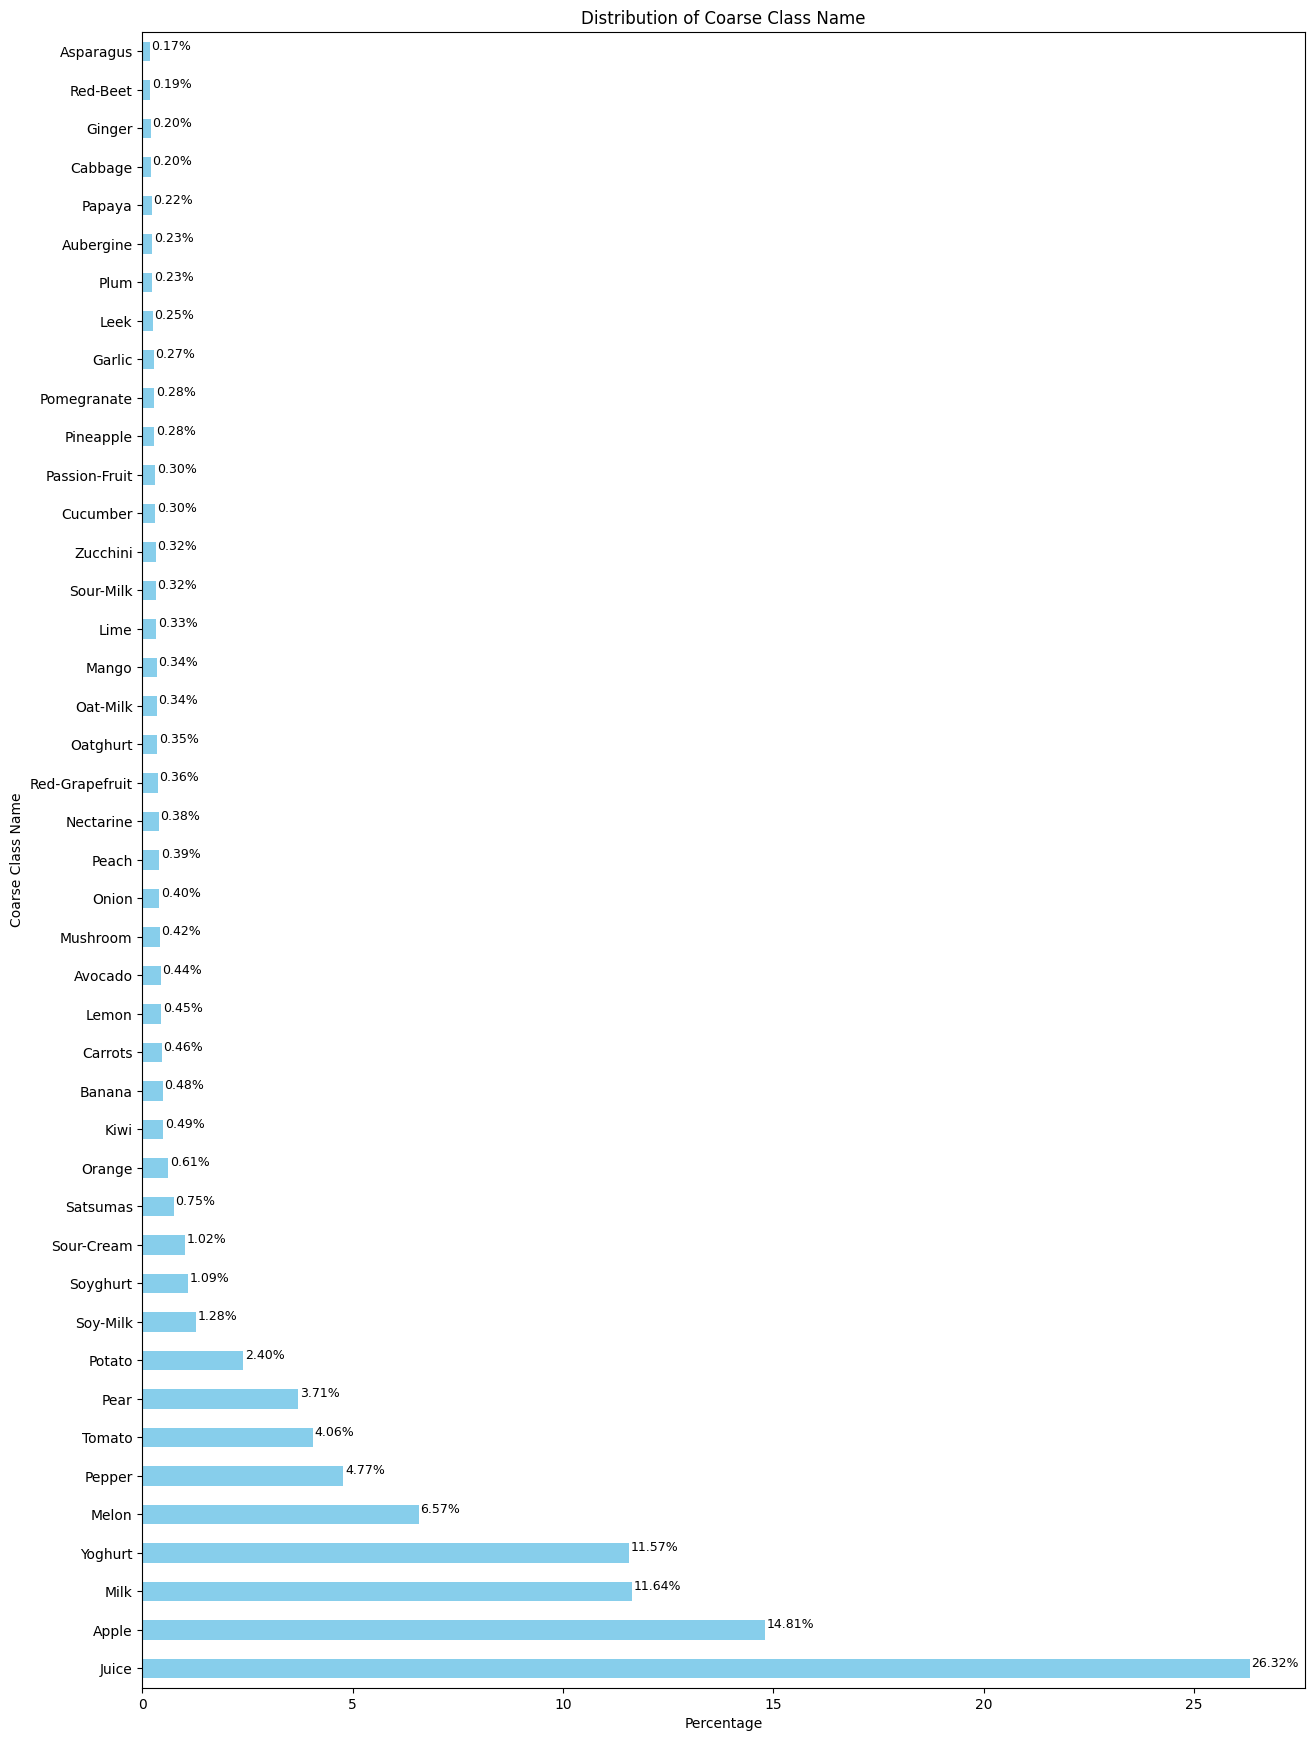

In [85]:
value_counts_train = train_merged["Coarse Class Name (str)"].value_counts()
percentages_train = (value_counts_train / value_counts_train.sum()) * 100

num_classes = len(value_counts_train)
fig_height = num_classes * 0.5 

plt.figure(figsize=(15, fig_height))
ax = percentages_train.plot(kind='barh', color='skyblue')

for i in ax.patches:
    plt.text(i.get_width() + 0.04, i.get_y() + 0.3, f'{i.get_width():.2f}%', fontsize=9, color='black')

plt.title('Distribution of Coarse Class Name')
plt.xlabel('Percentage')
plt.ylabel('Coarse Class Name')
plt.show()

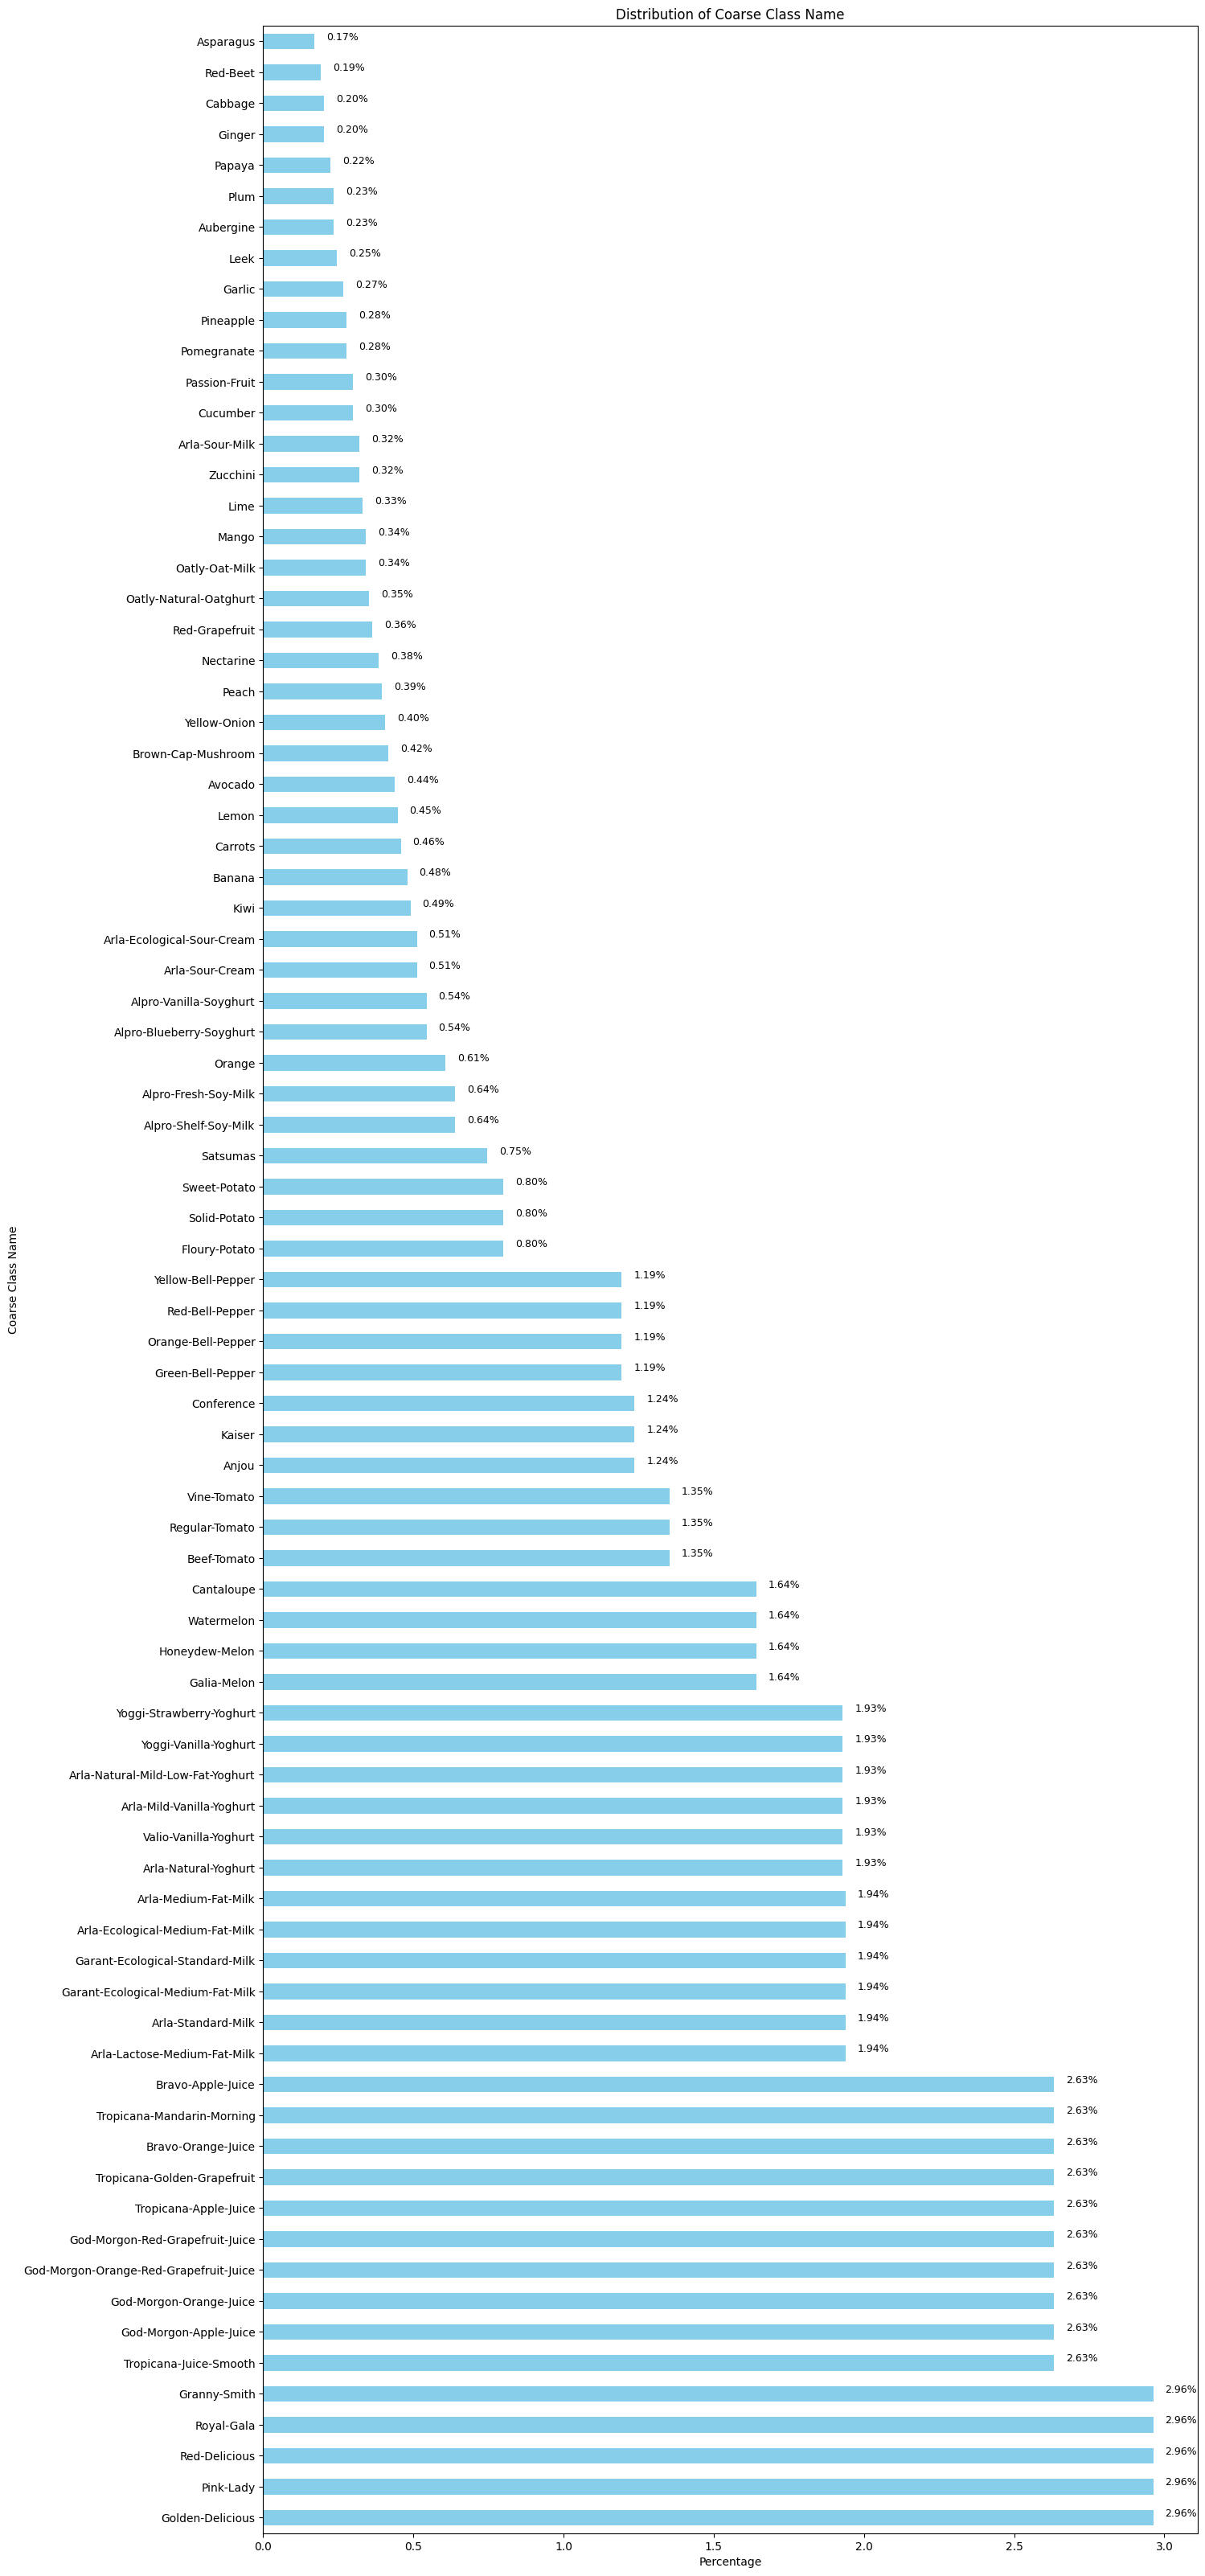

In [ ]:
value_counts_train = train_merged['Class Name (str)'].value_counts()
percentages_train = (value_counts_train / value_counts_train.sum()) * 100

num_classes = len(value_counts_train)
fig_height = num_classes * 0.5 

plt.figure(figsize=(15, fig_height))
ax = percentages_train.plot(kind='barh', color='skyblue')

for i in ax.patches:
    plt.text(i.get_width() + 0.04, i.get_y() + 0.3, f'{i.get_width():.2f}%', fontsize=9, color='black')

plt.title('Distribution of Complete Class Name')
plt.xlabel('Percentage')
plt.ylabel('Coarse Class Name')
plt.show()

Se miró también el tamaño general de las imágenes. No tienen los mismos tamaños por lo que toca estandarizar.

In [10]:
try:
   assert train_merged["Image"].apply(lambda x: x.shape).nunique() == 1
except AssertionError:
   print("Found images with different shapes:")
   shapes_count = train_merged["Image"].apply(lambda x: x.shape).value_counts()
   print("\nShape distribution:")
   print(shapes_count)

Found images with different shapes:

Shape distribution:
Image
(348, 348, 3)    9043
(464, 348, 3)     299
(348, 464, 3)      41
Name: count, dtype: int64


Posteriormente, se decidió realizar el entendimiento sobre el conjunto de entrenamiento. Para ello, se cargan inicialmente las imágenes y se observa los histogramas de la ditribución por canal.

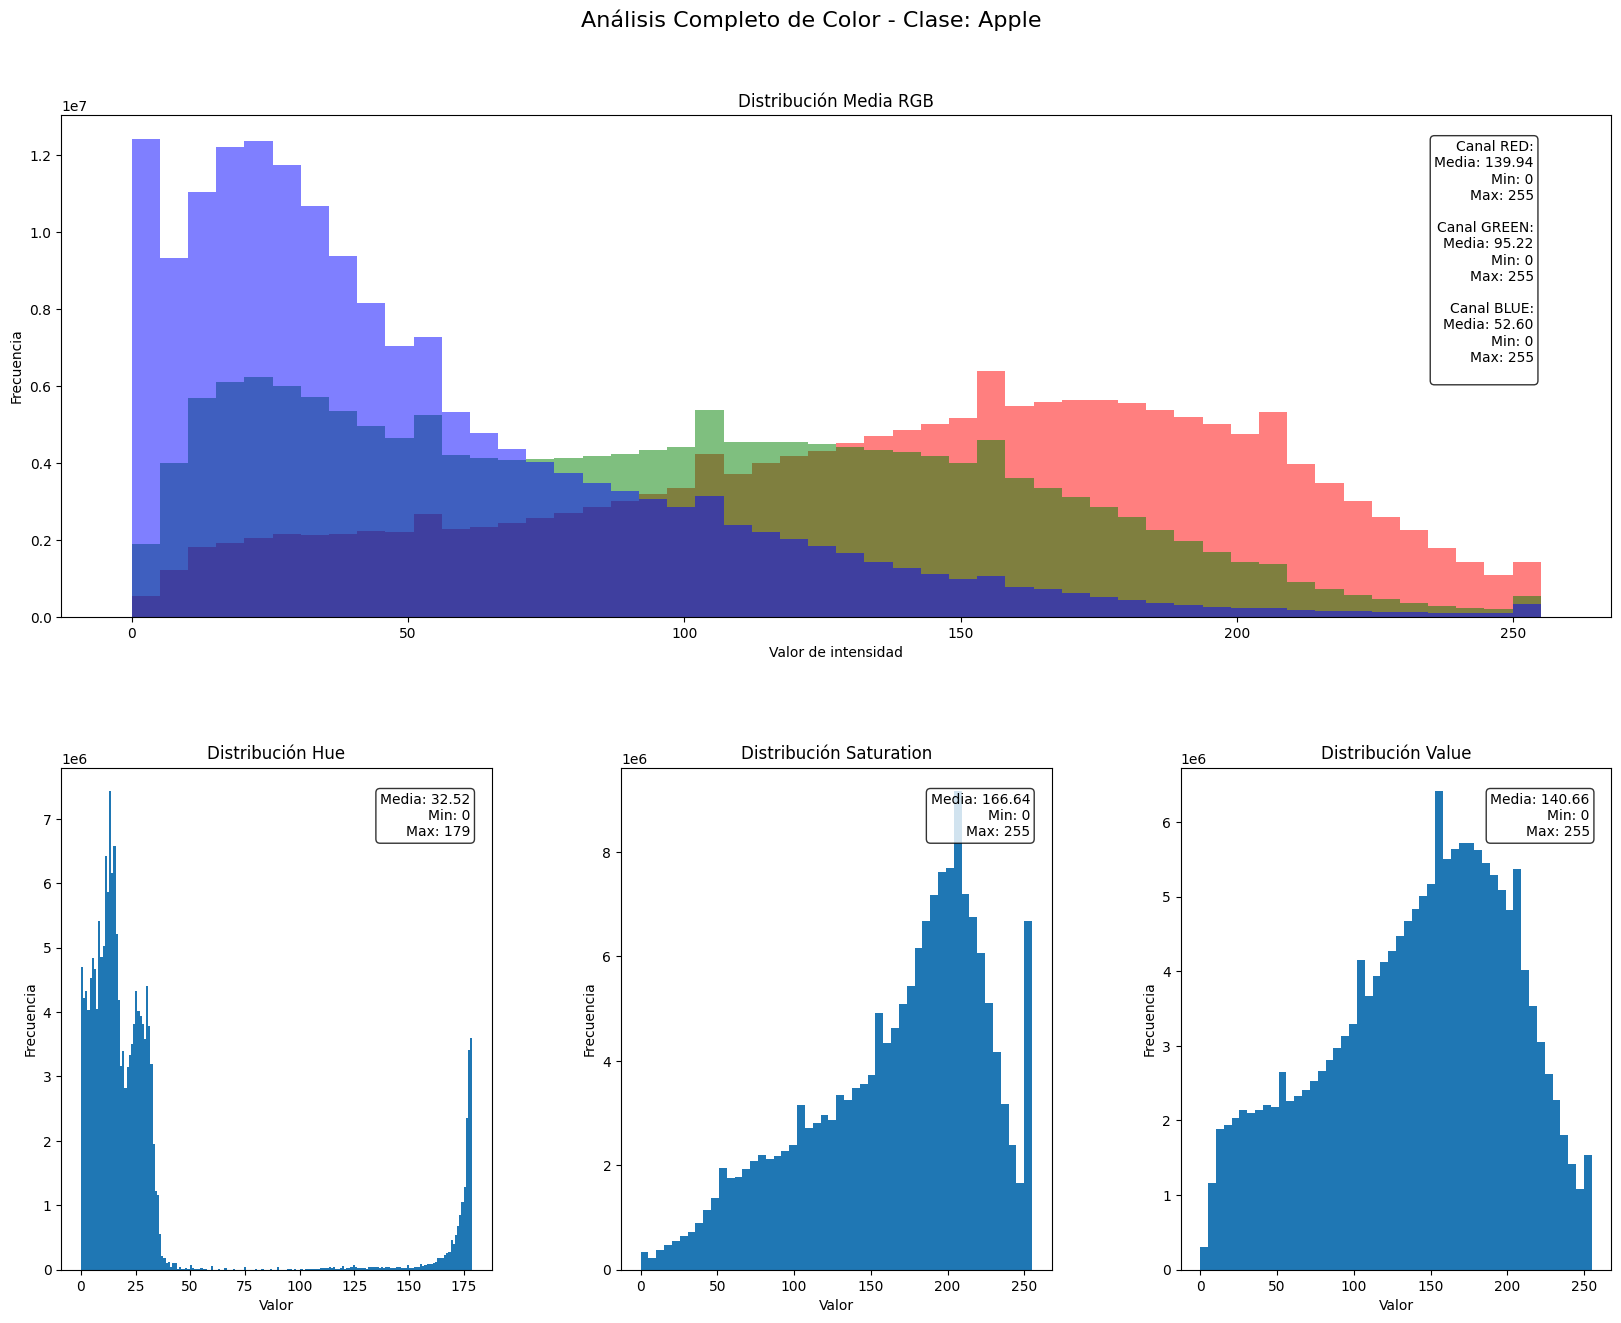

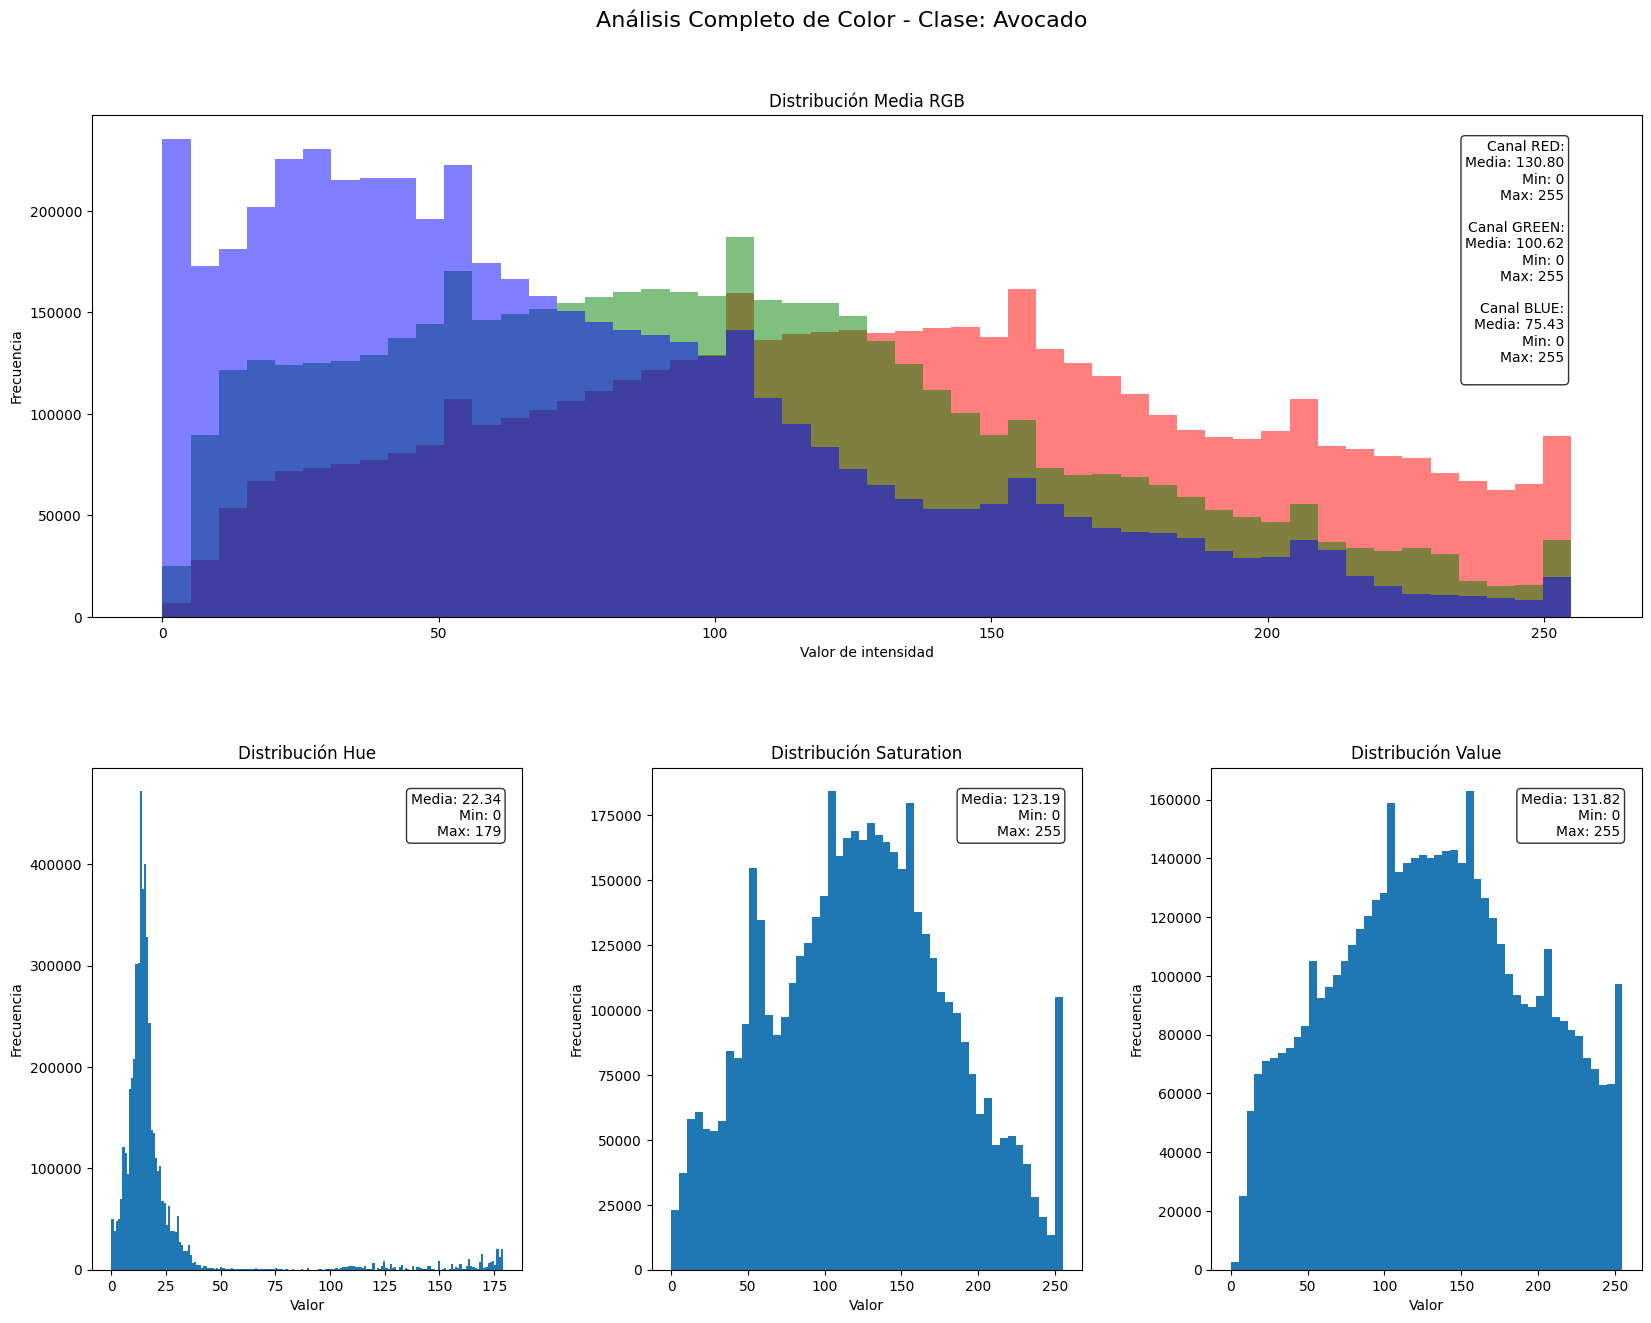

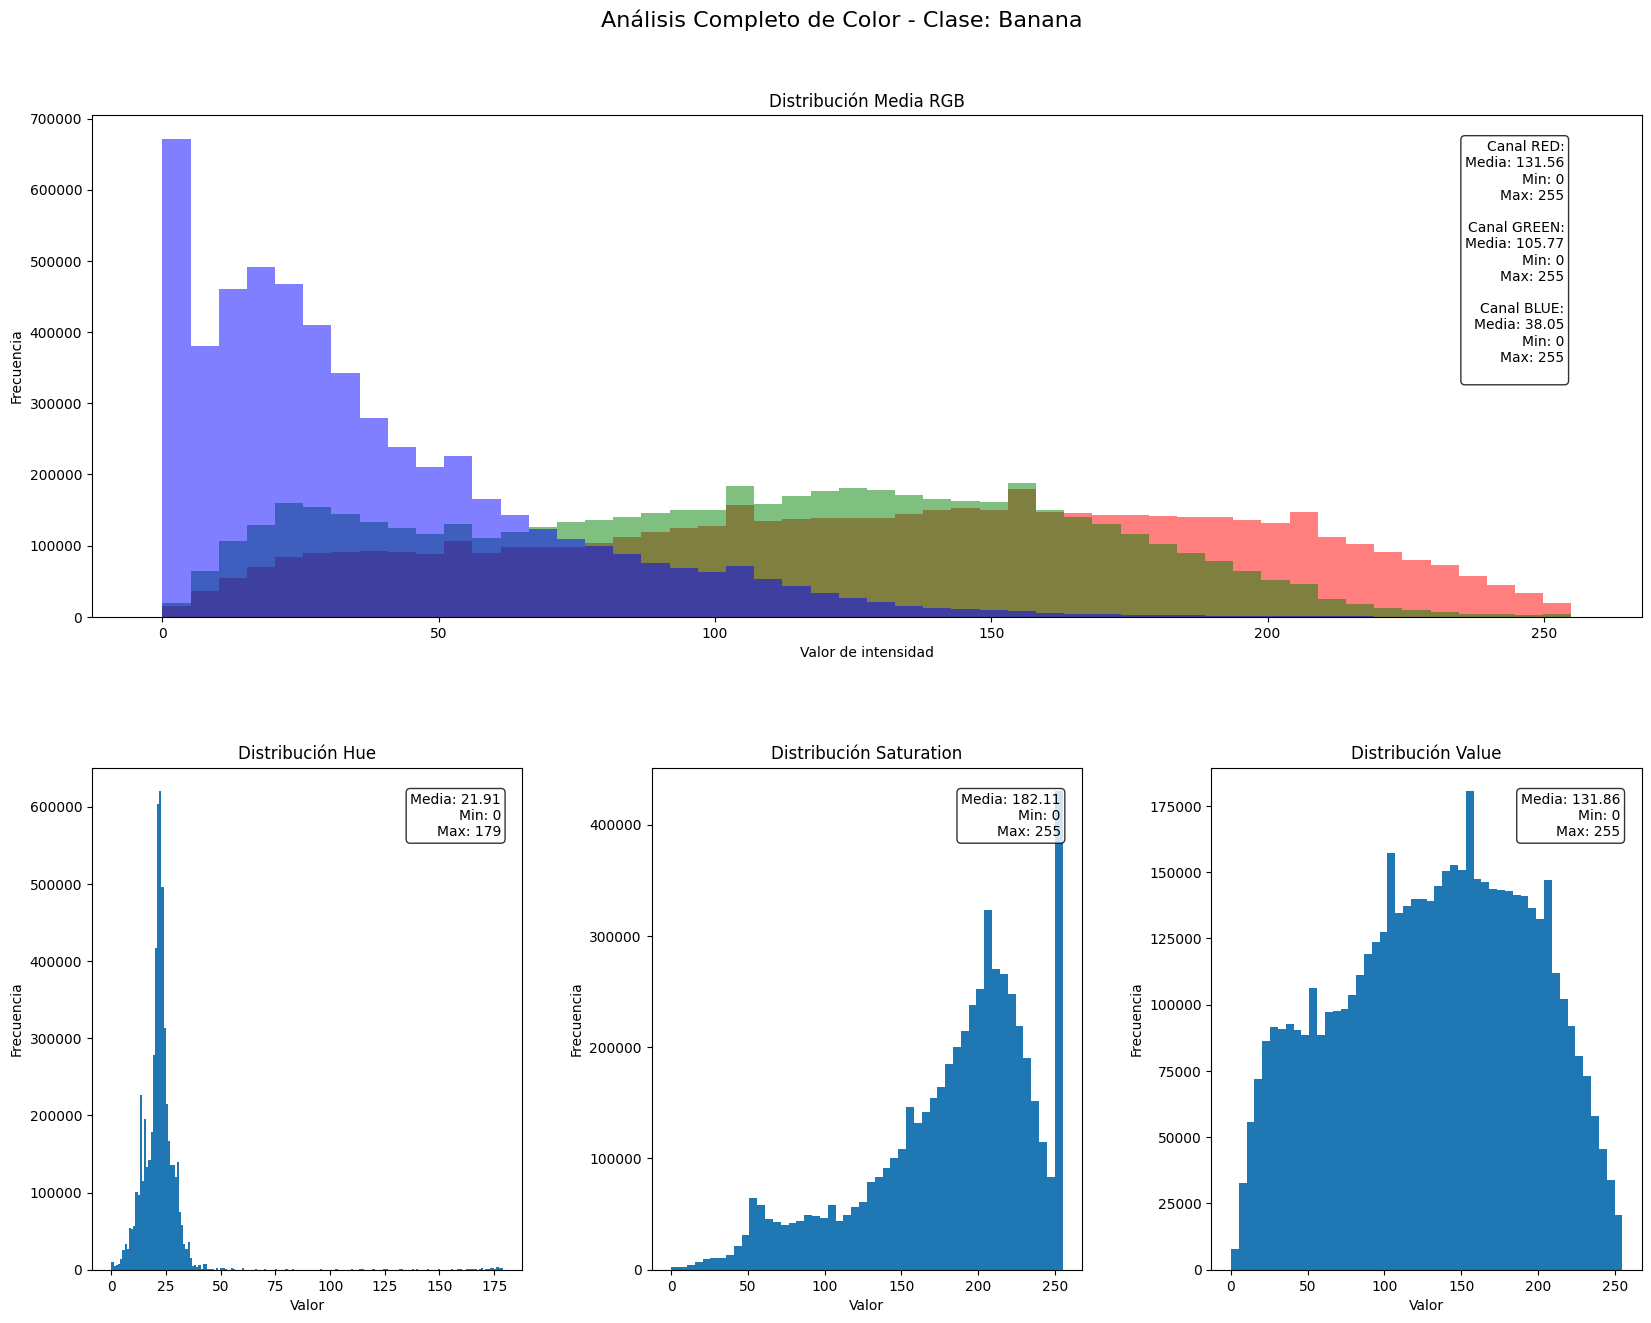

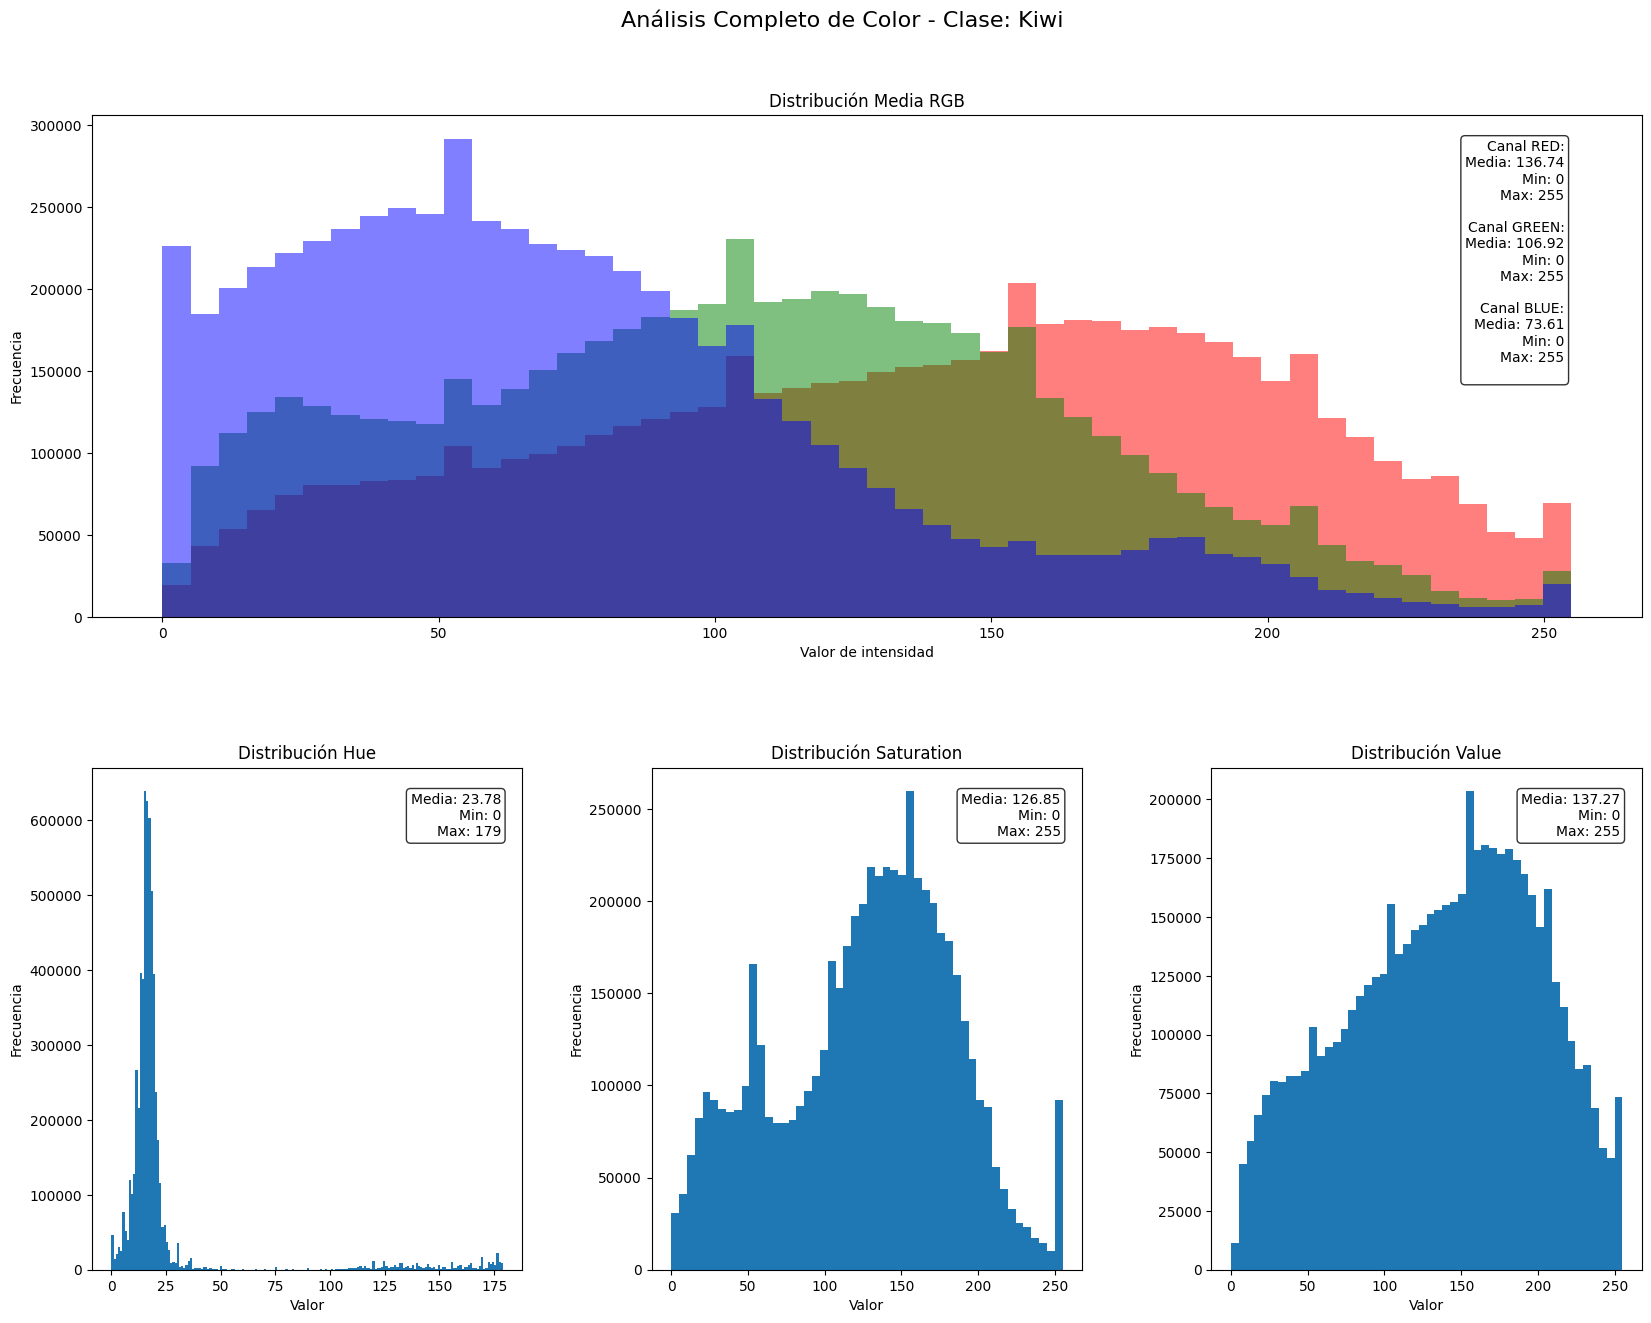

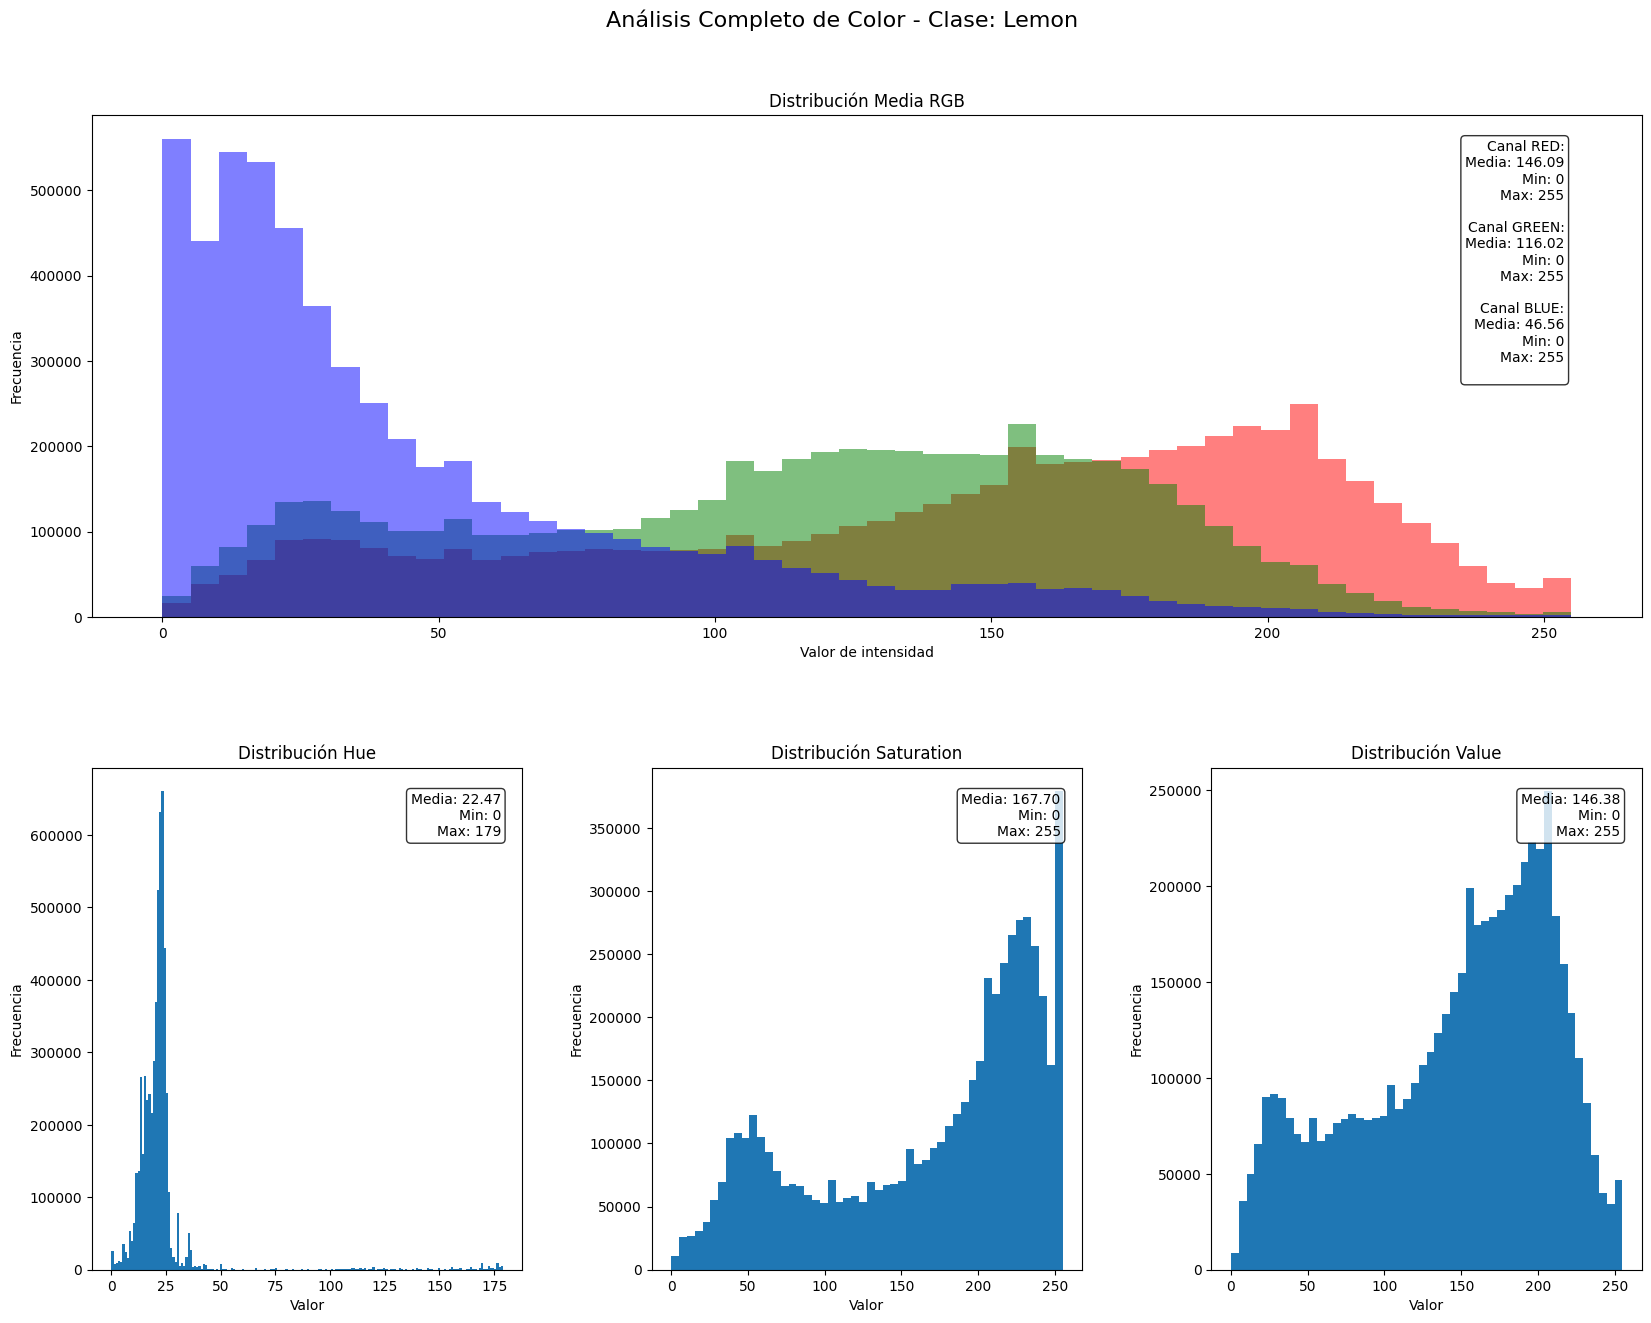

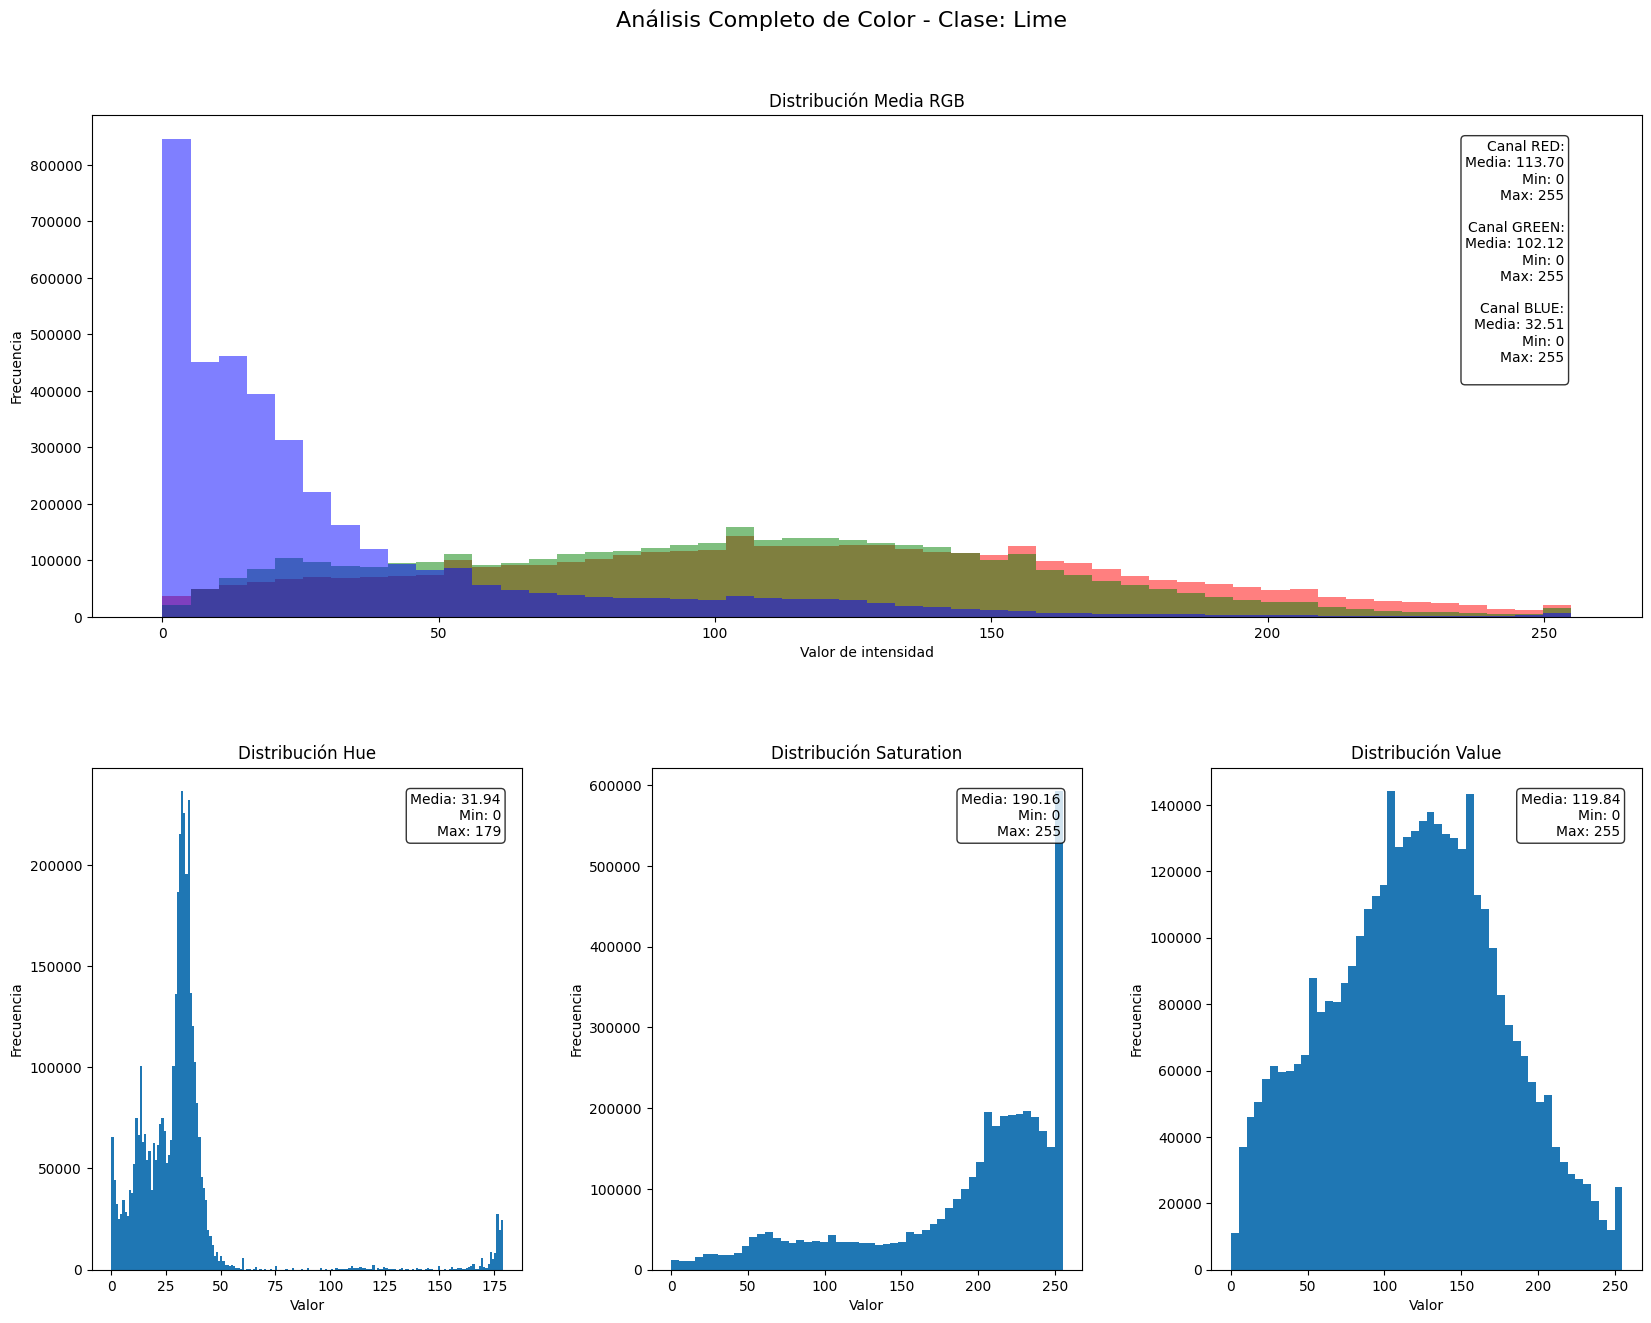

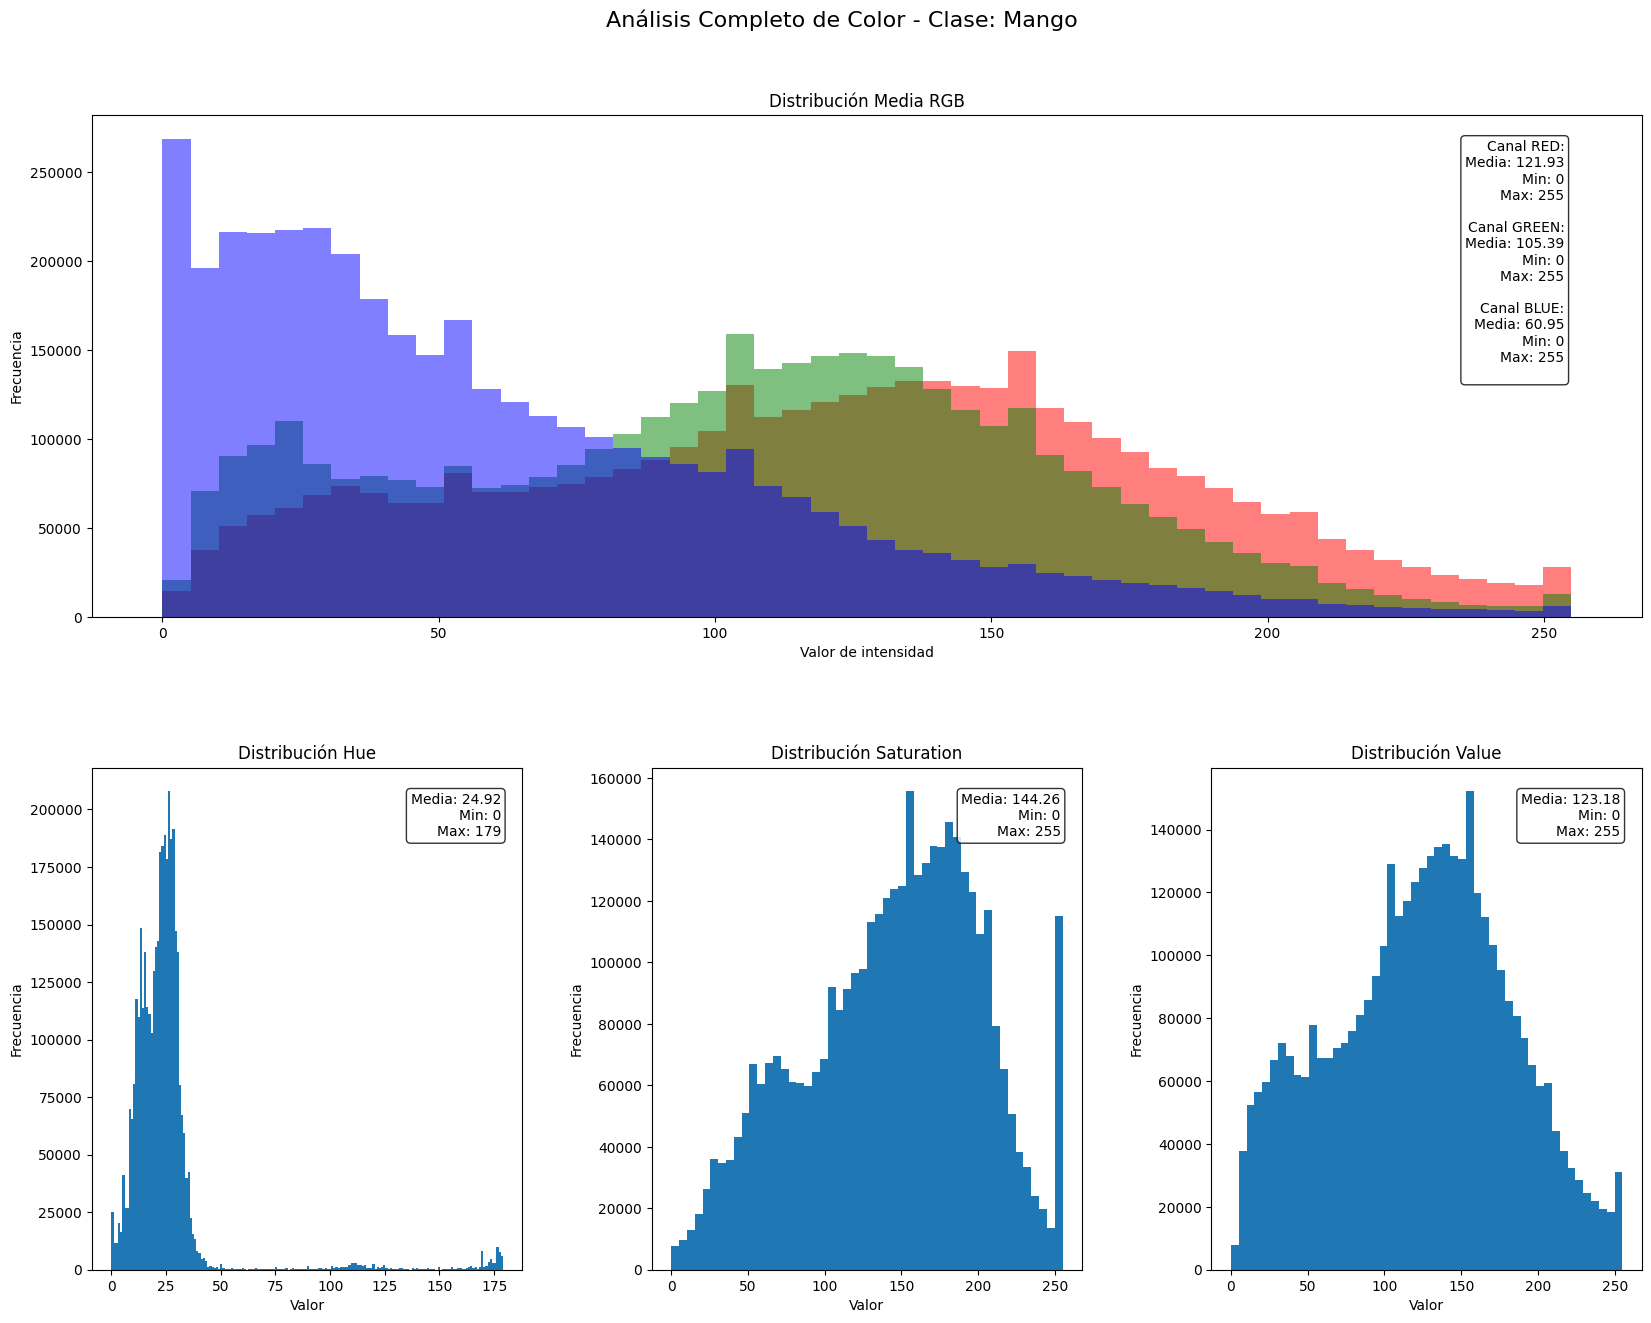

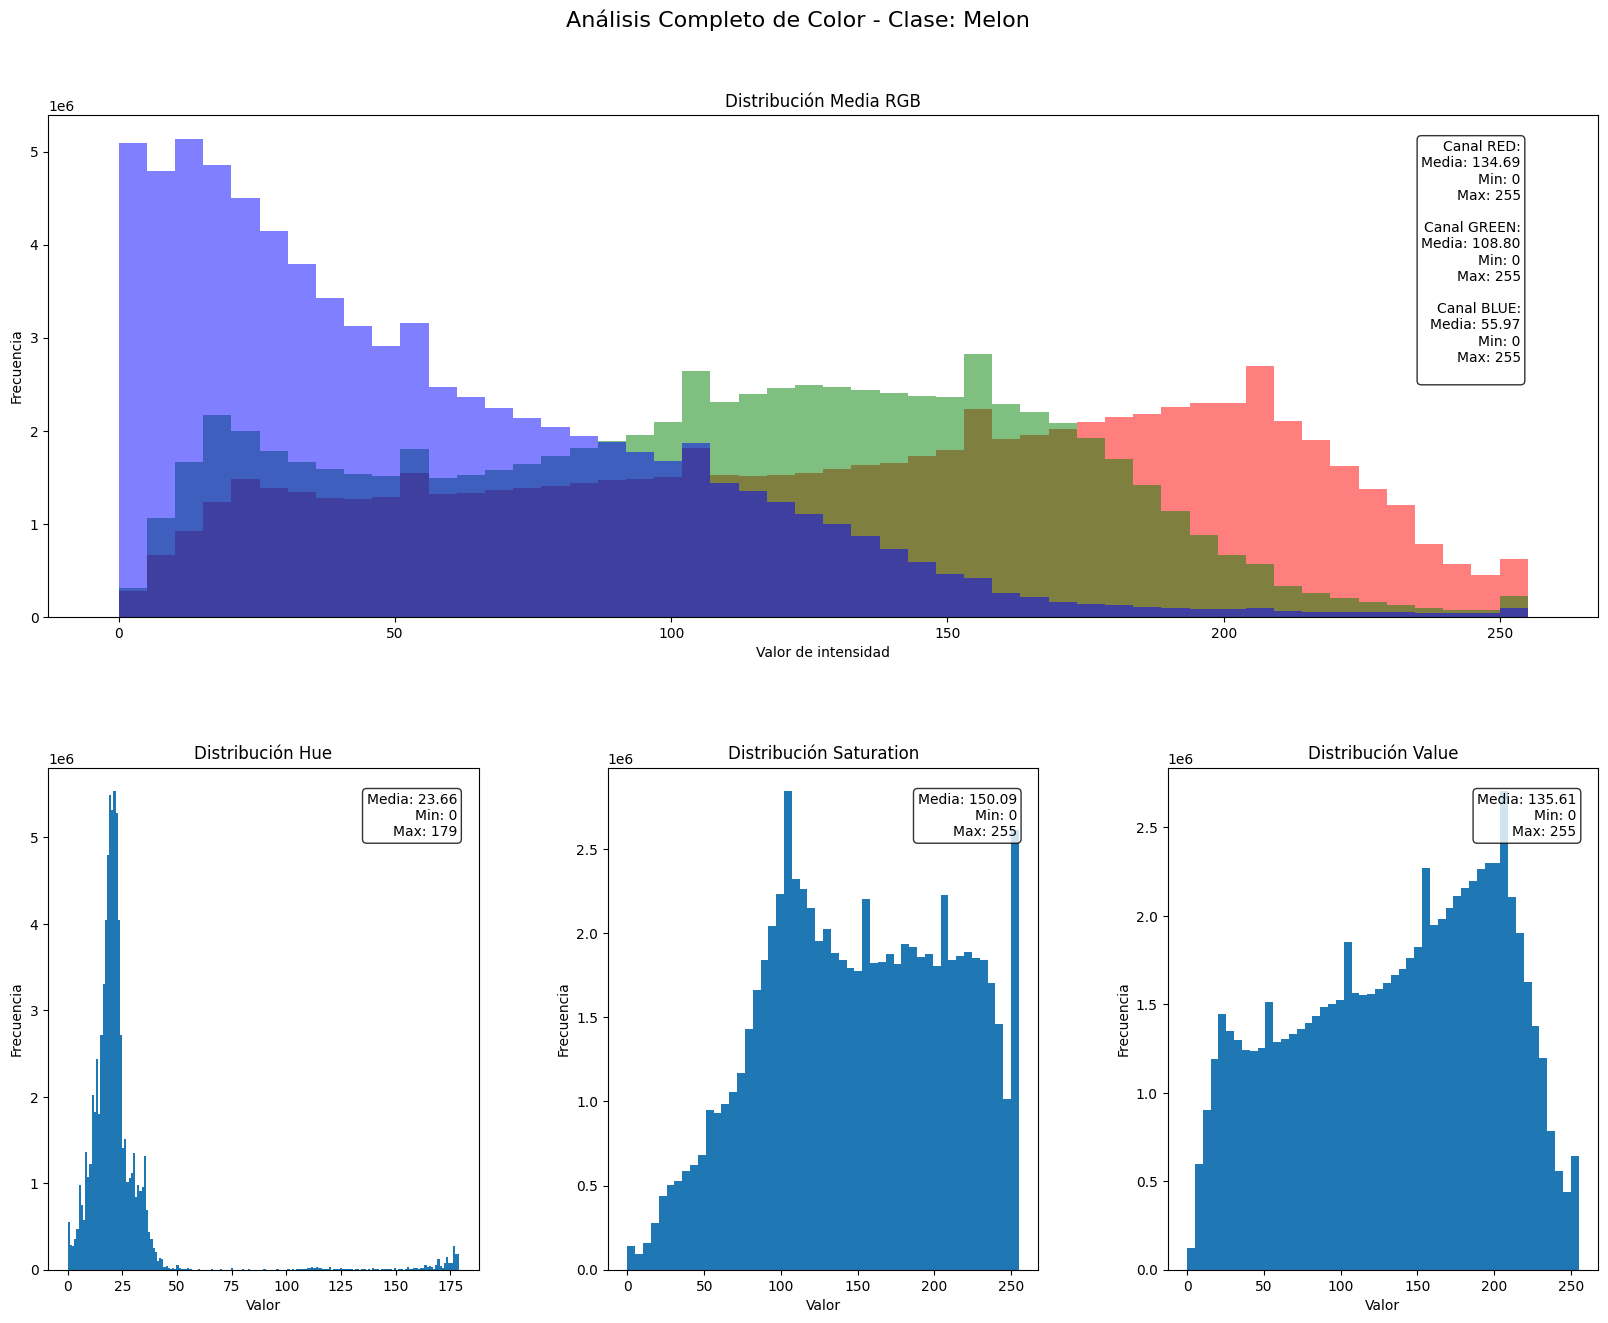

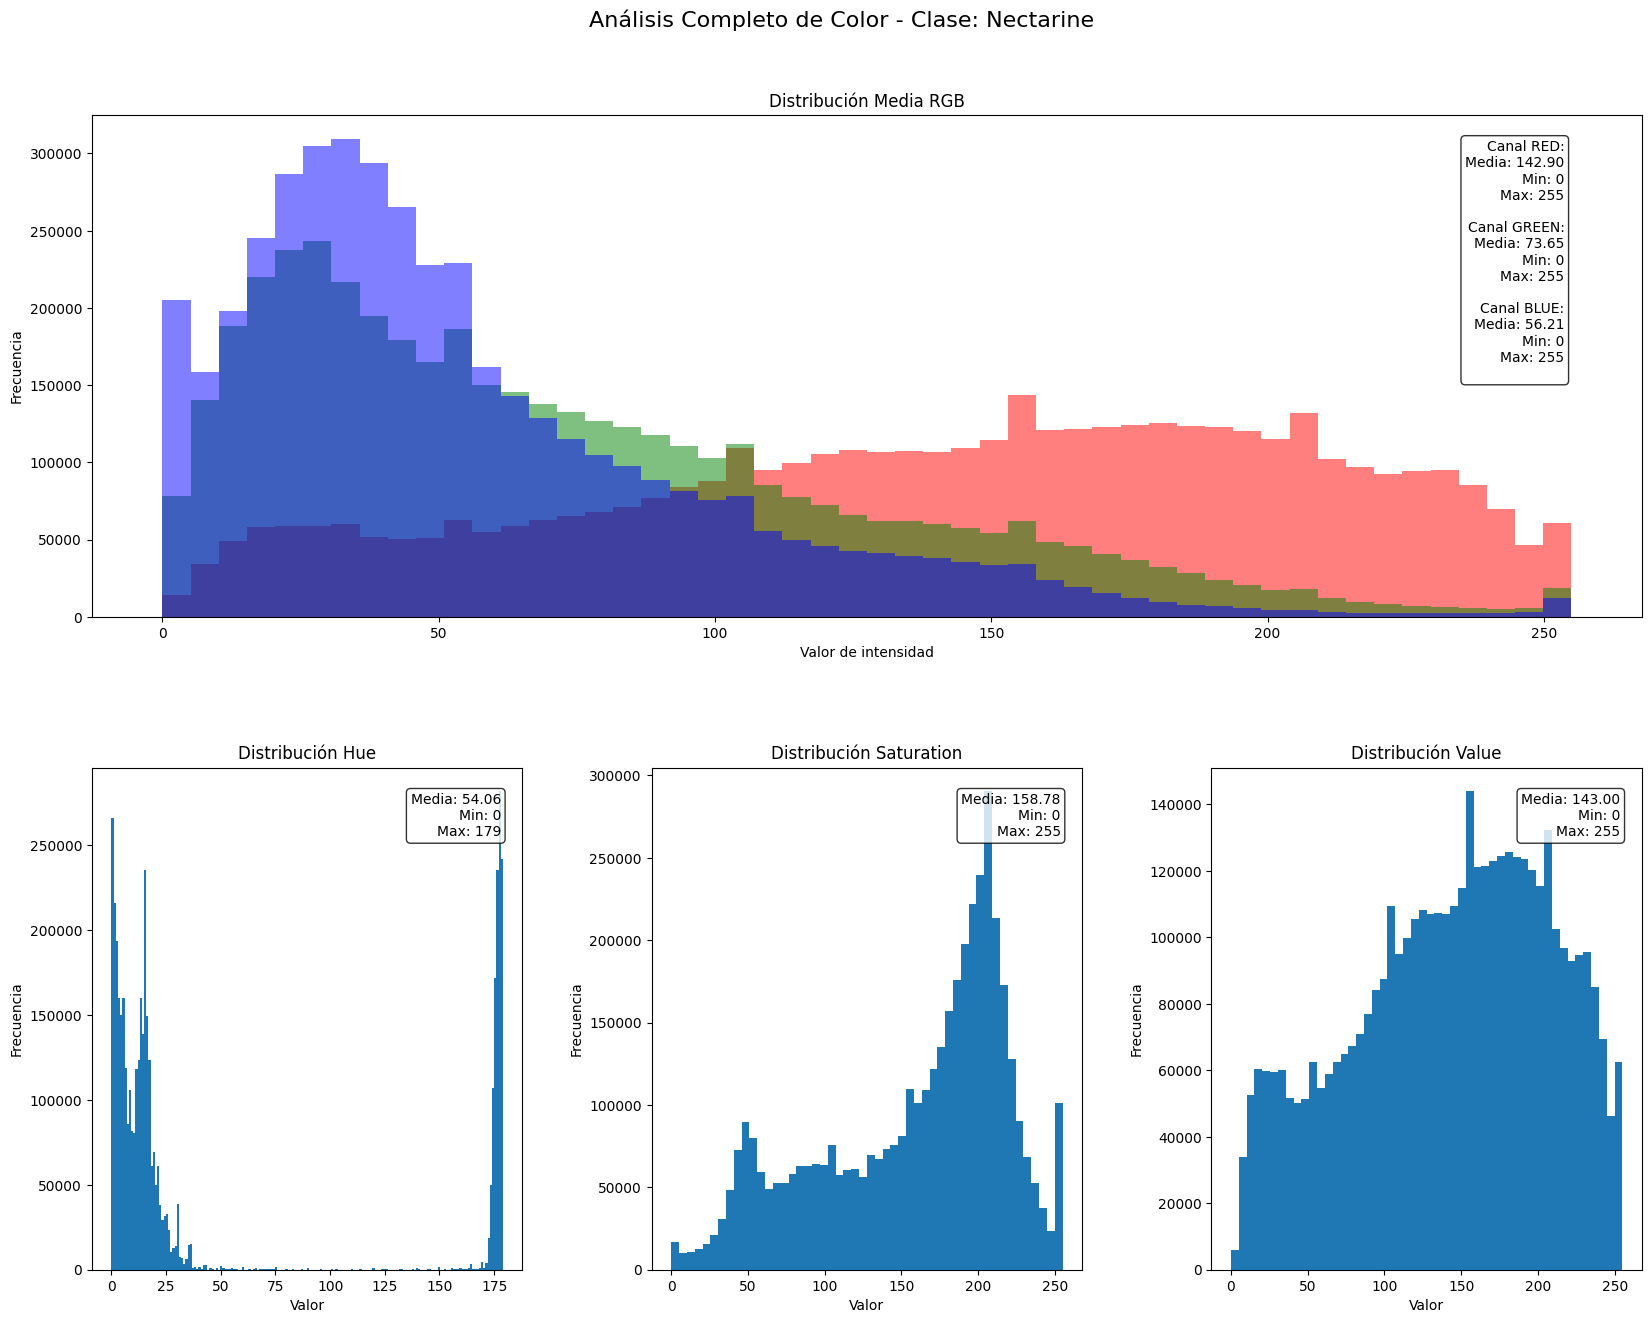

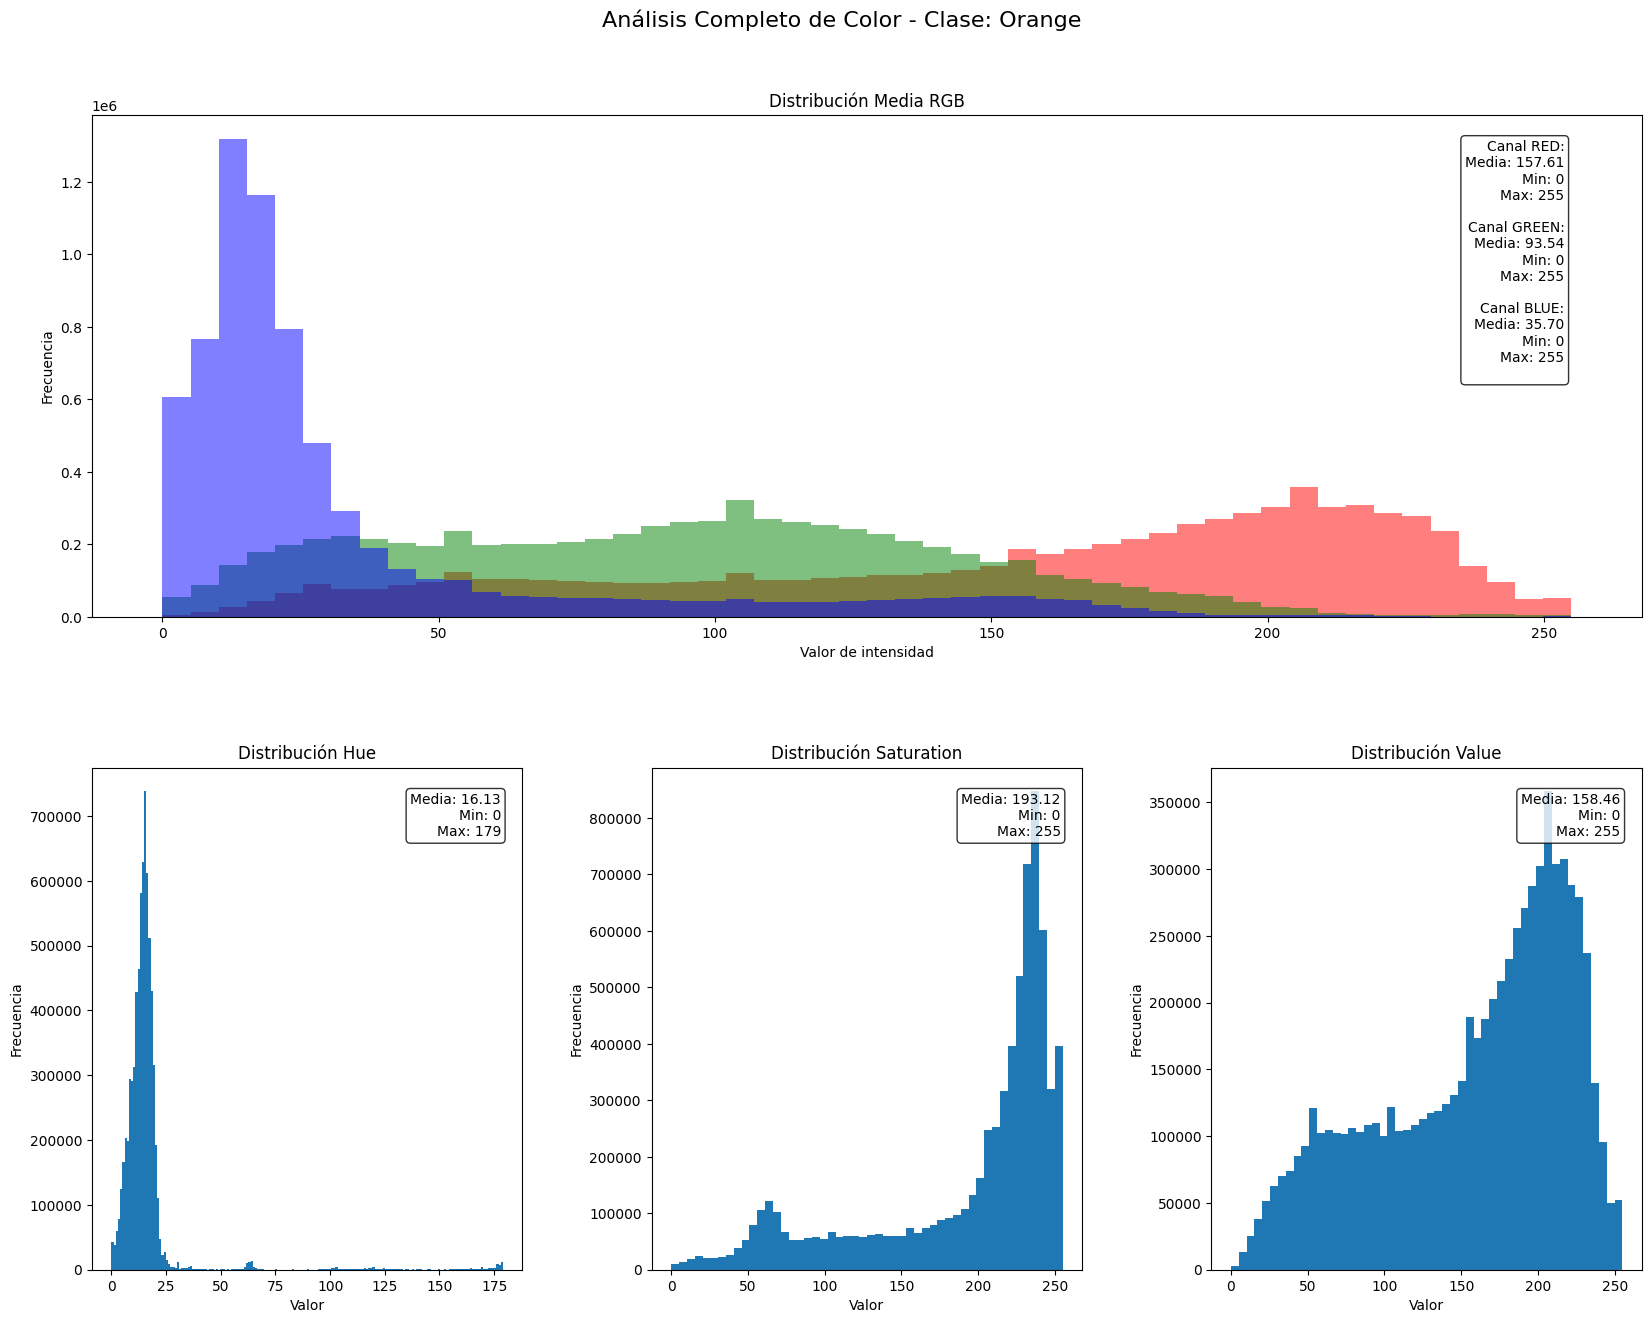

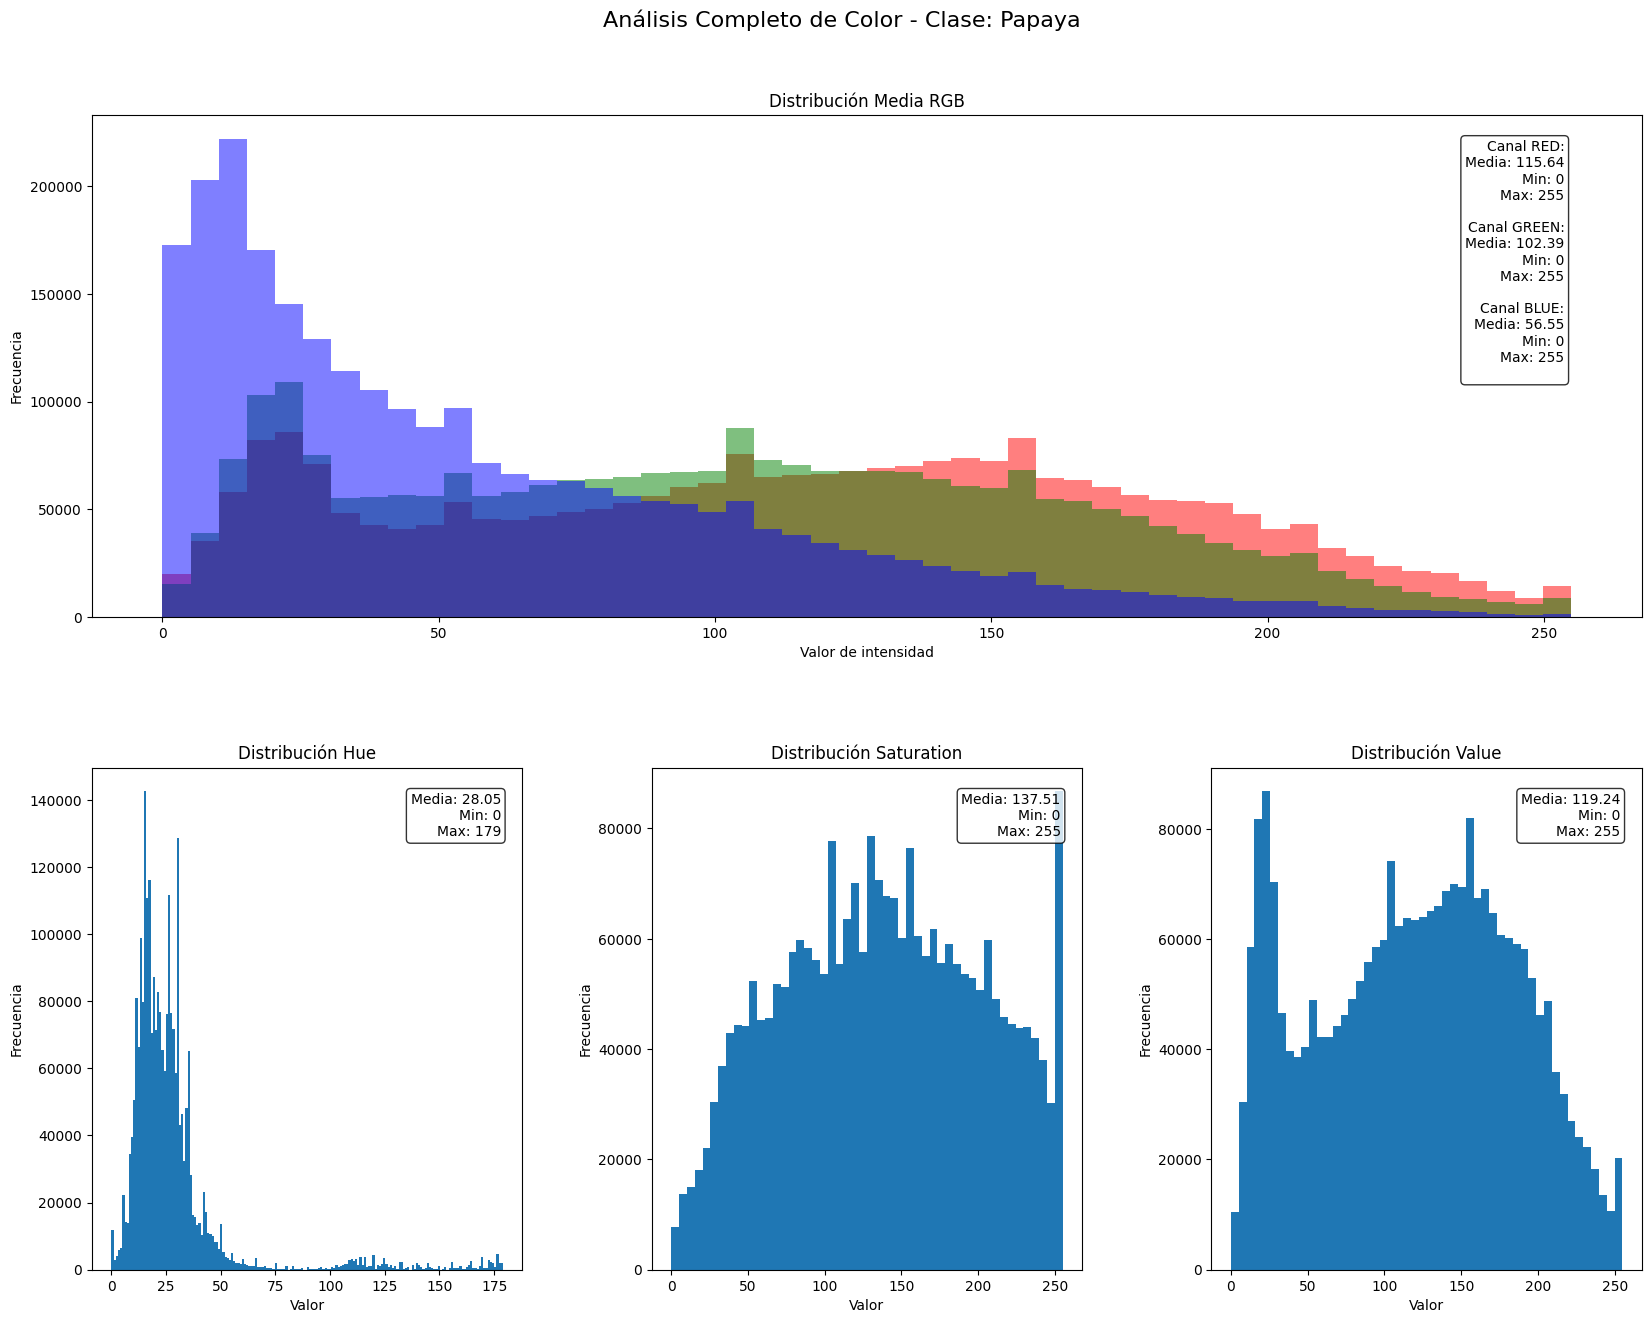

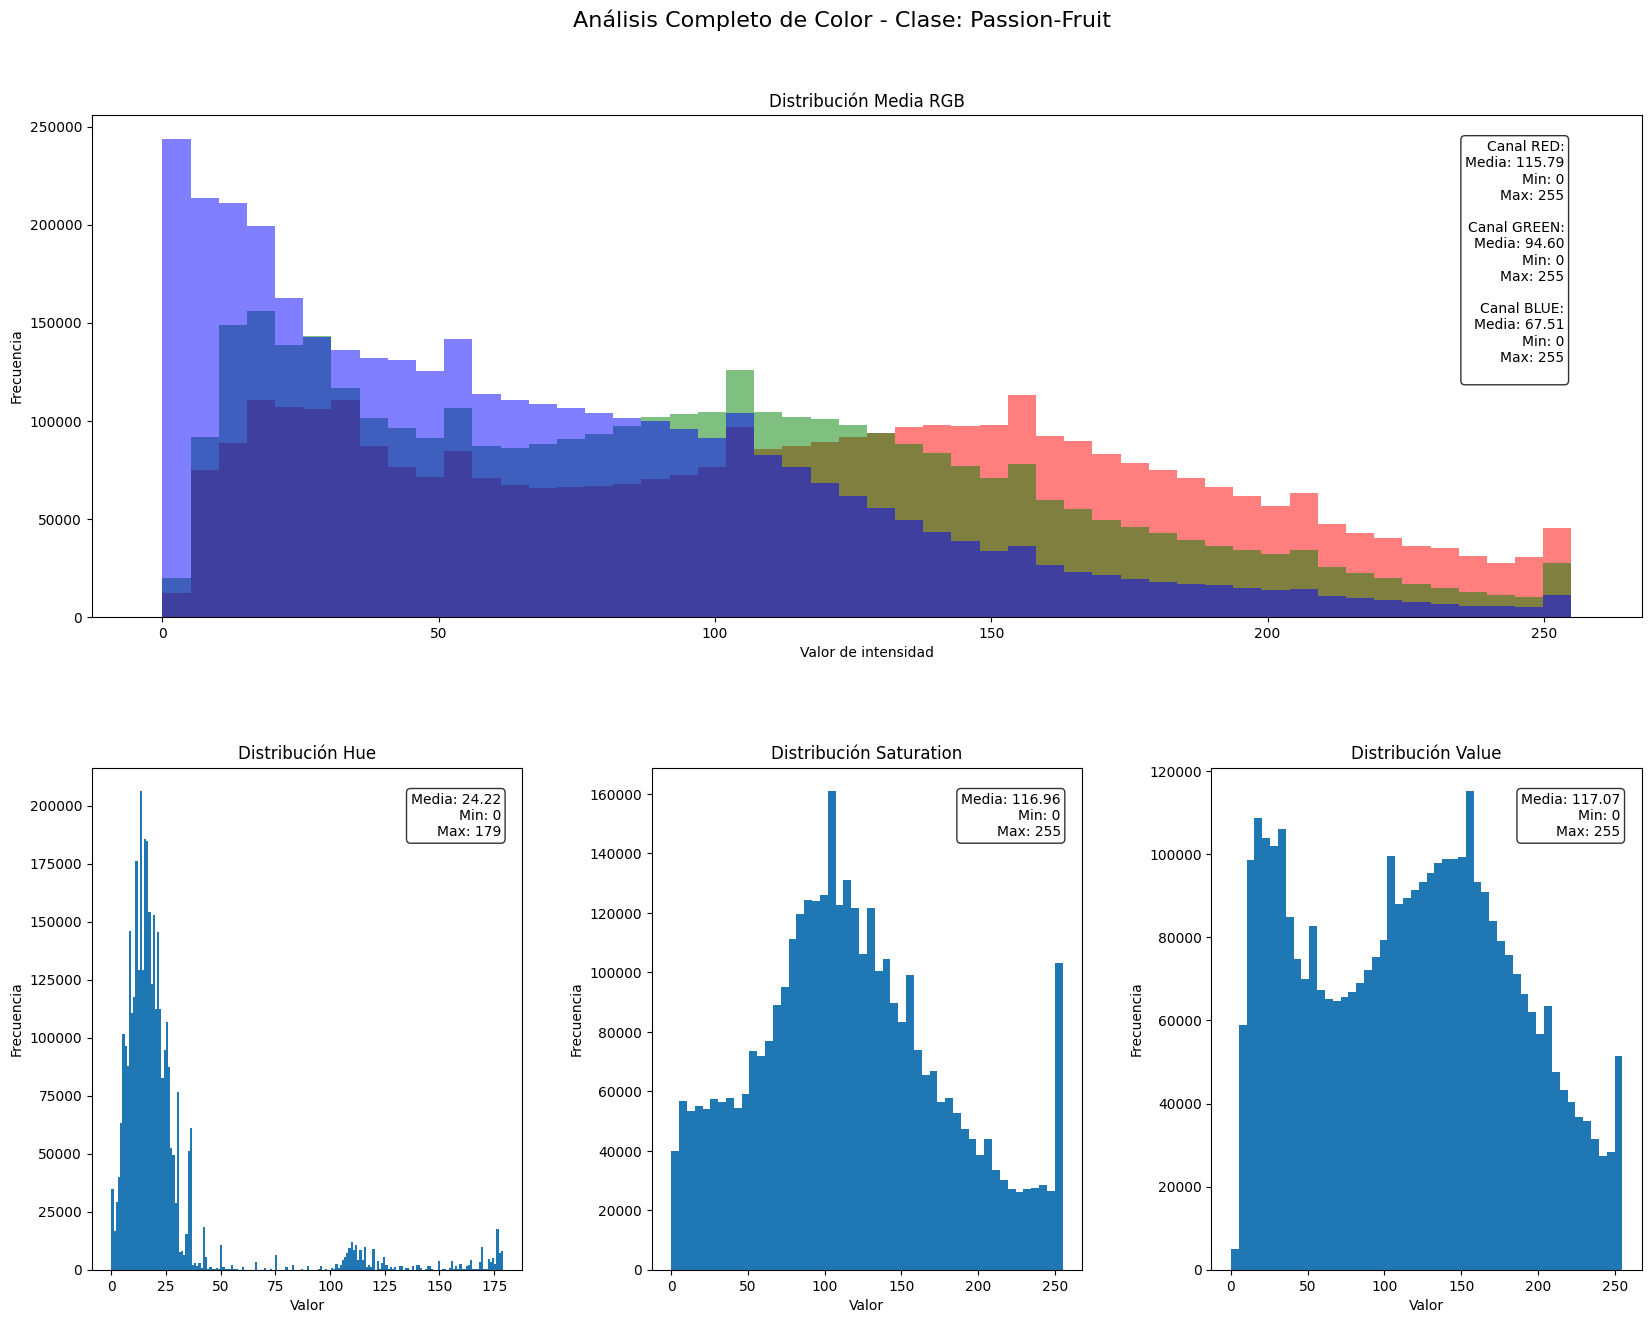

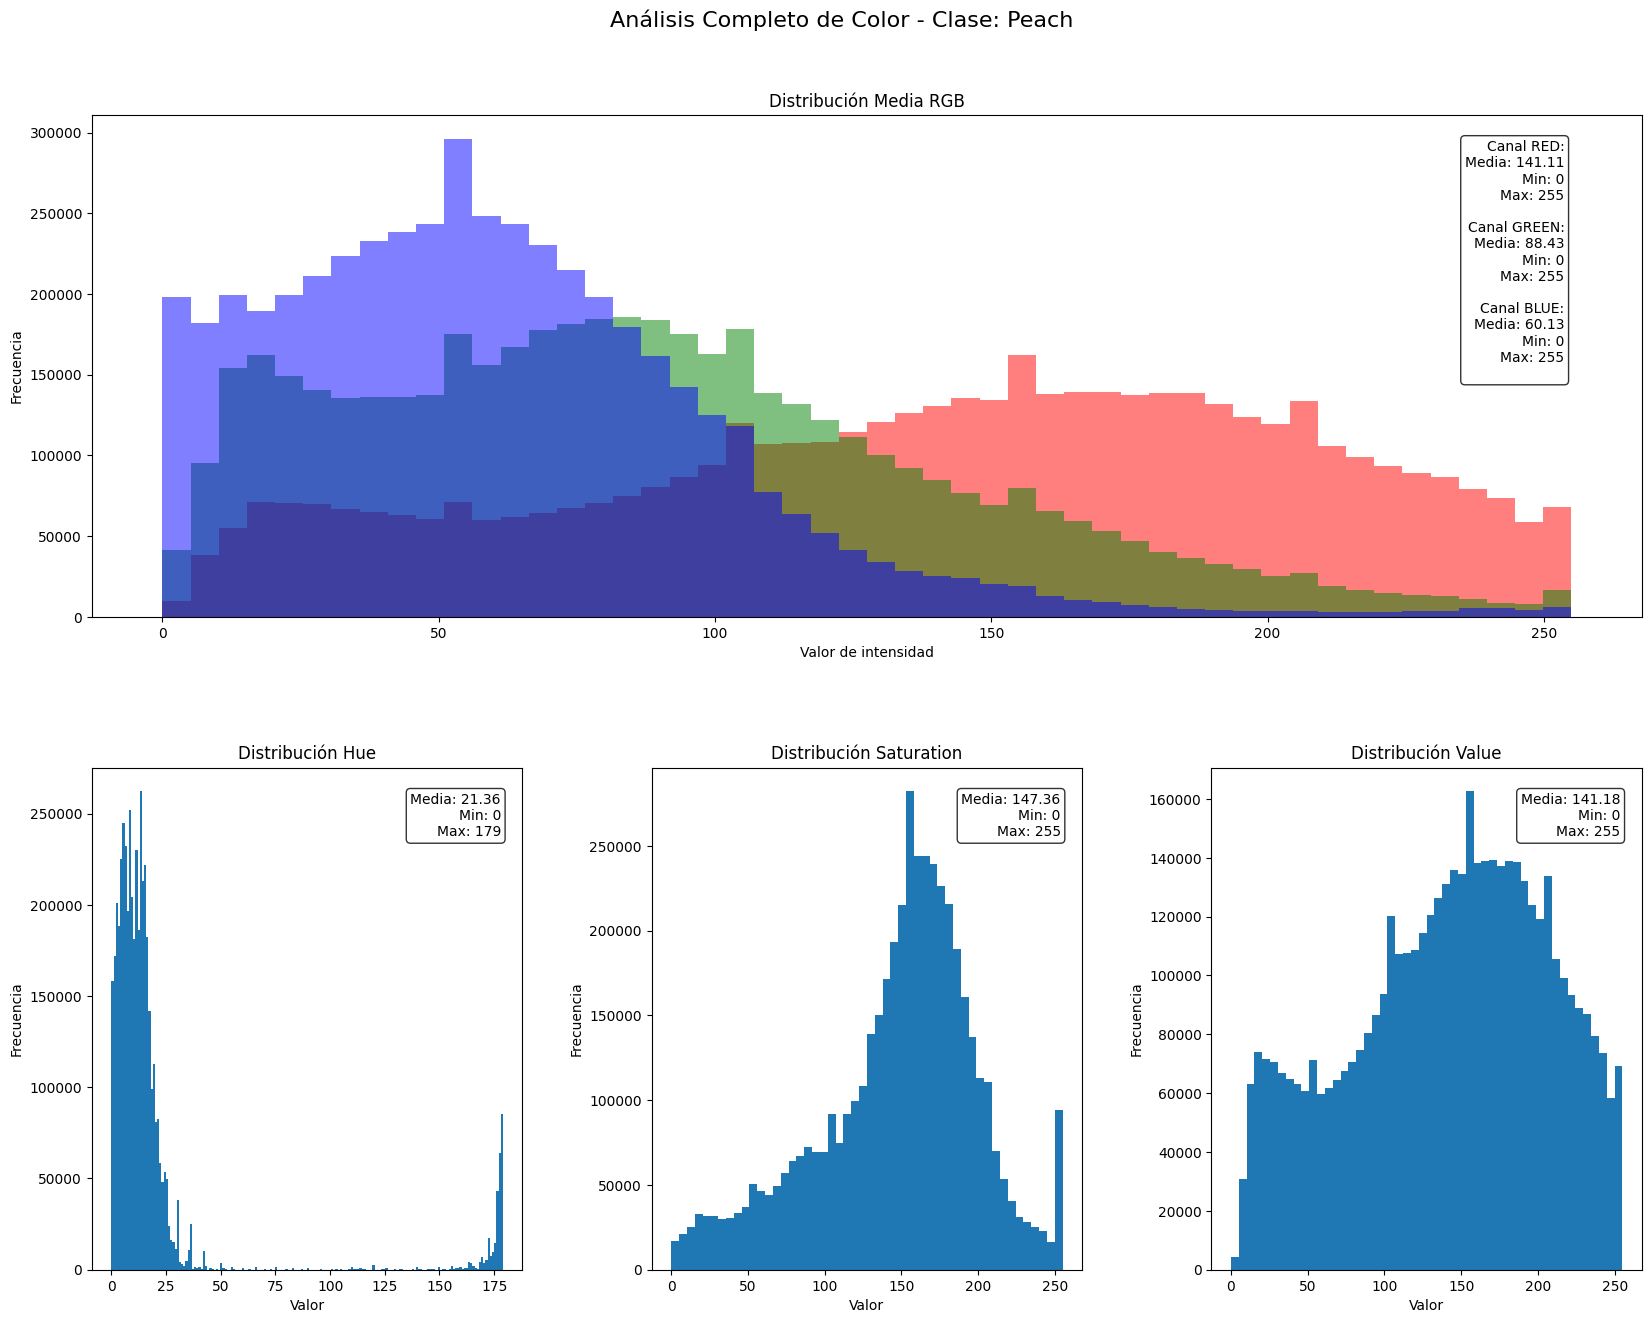

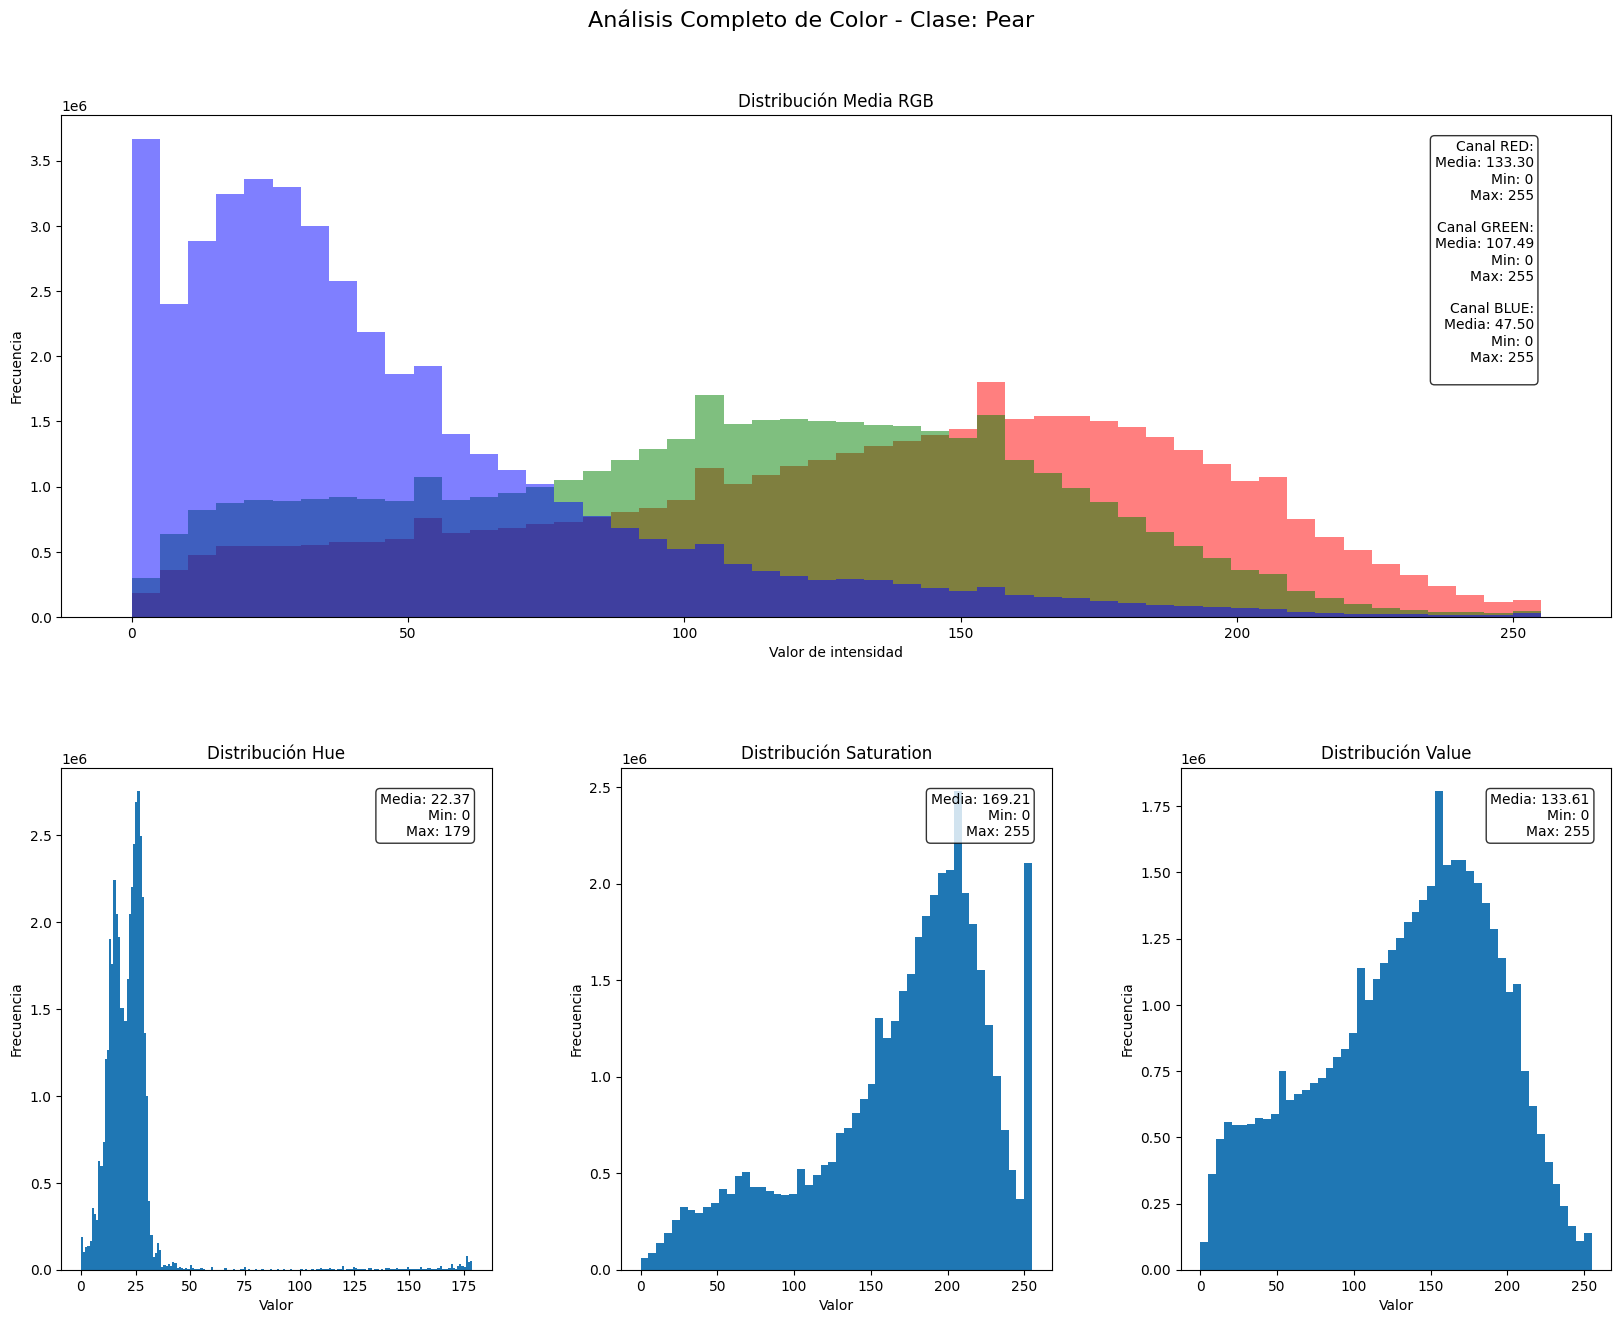

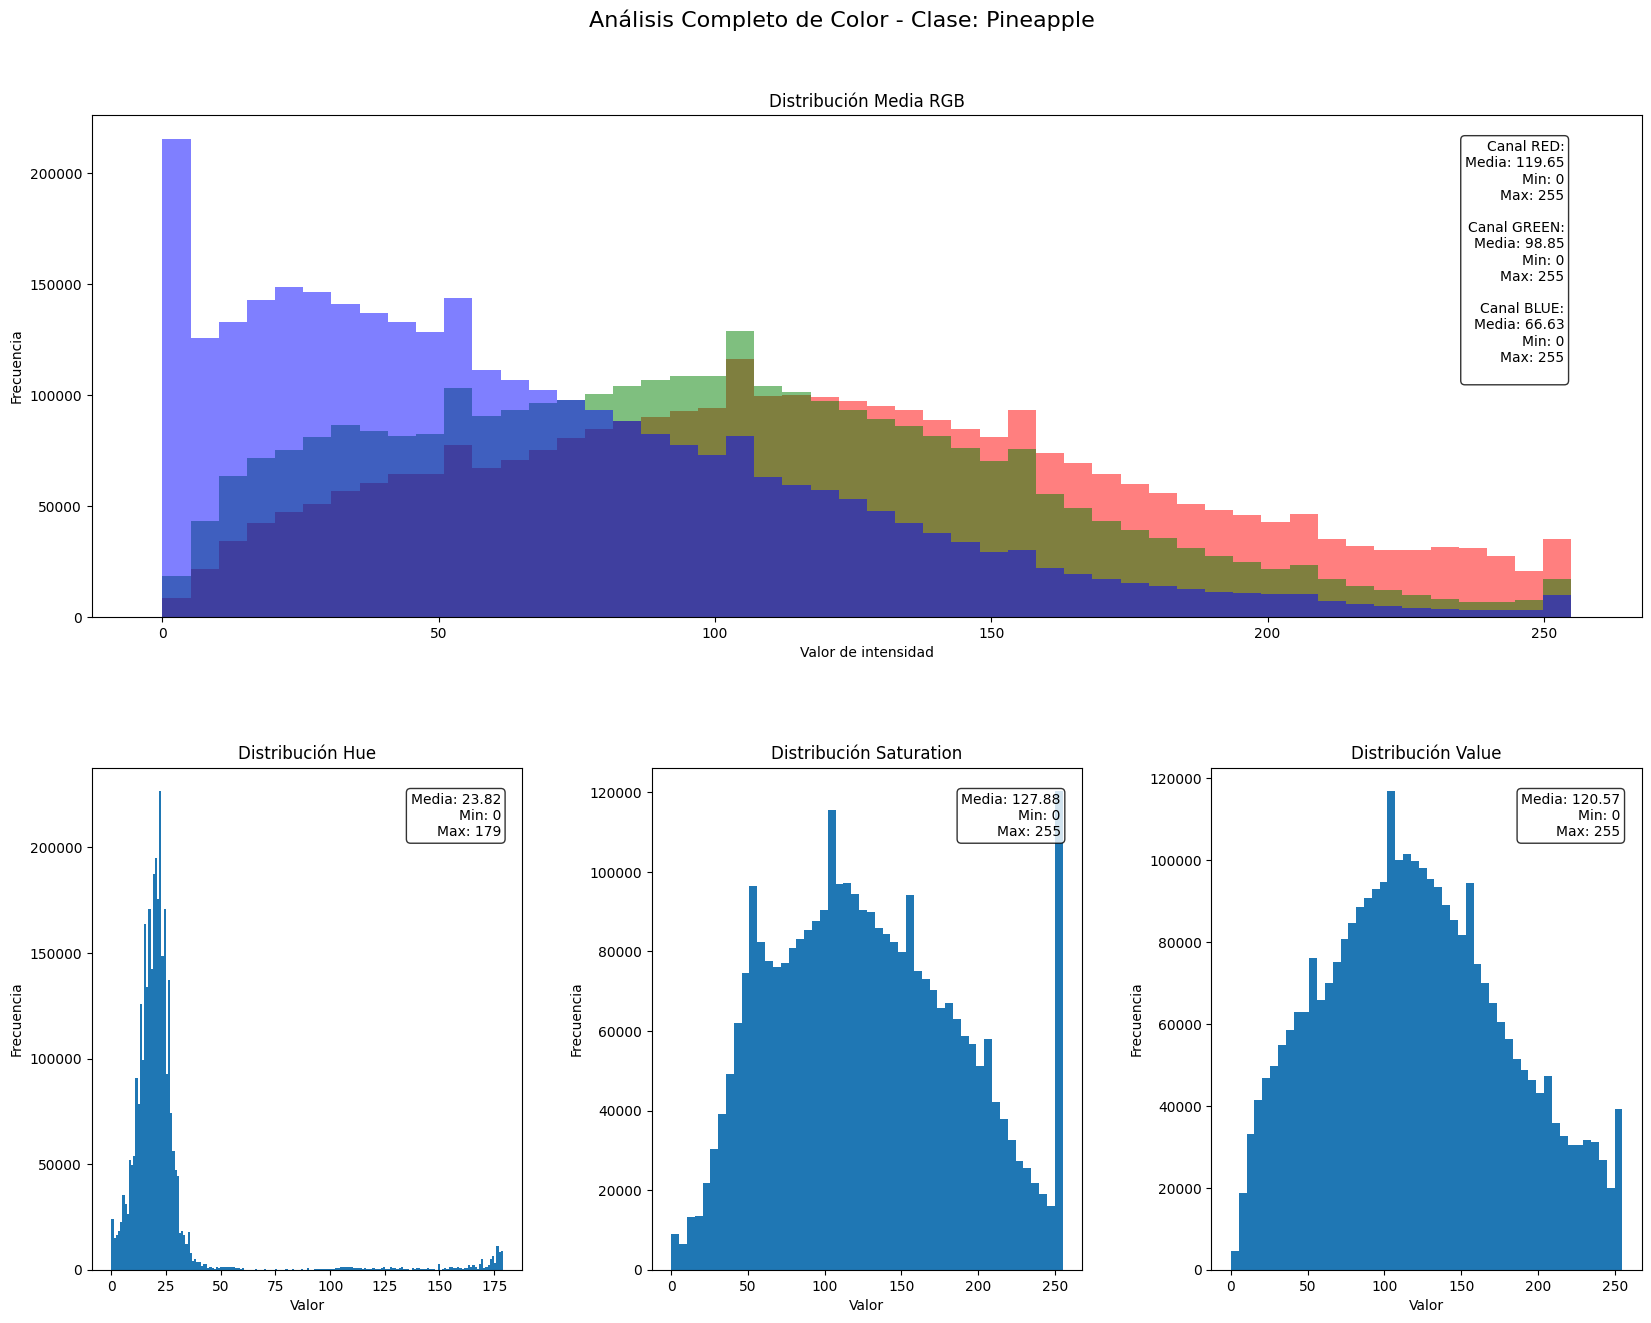

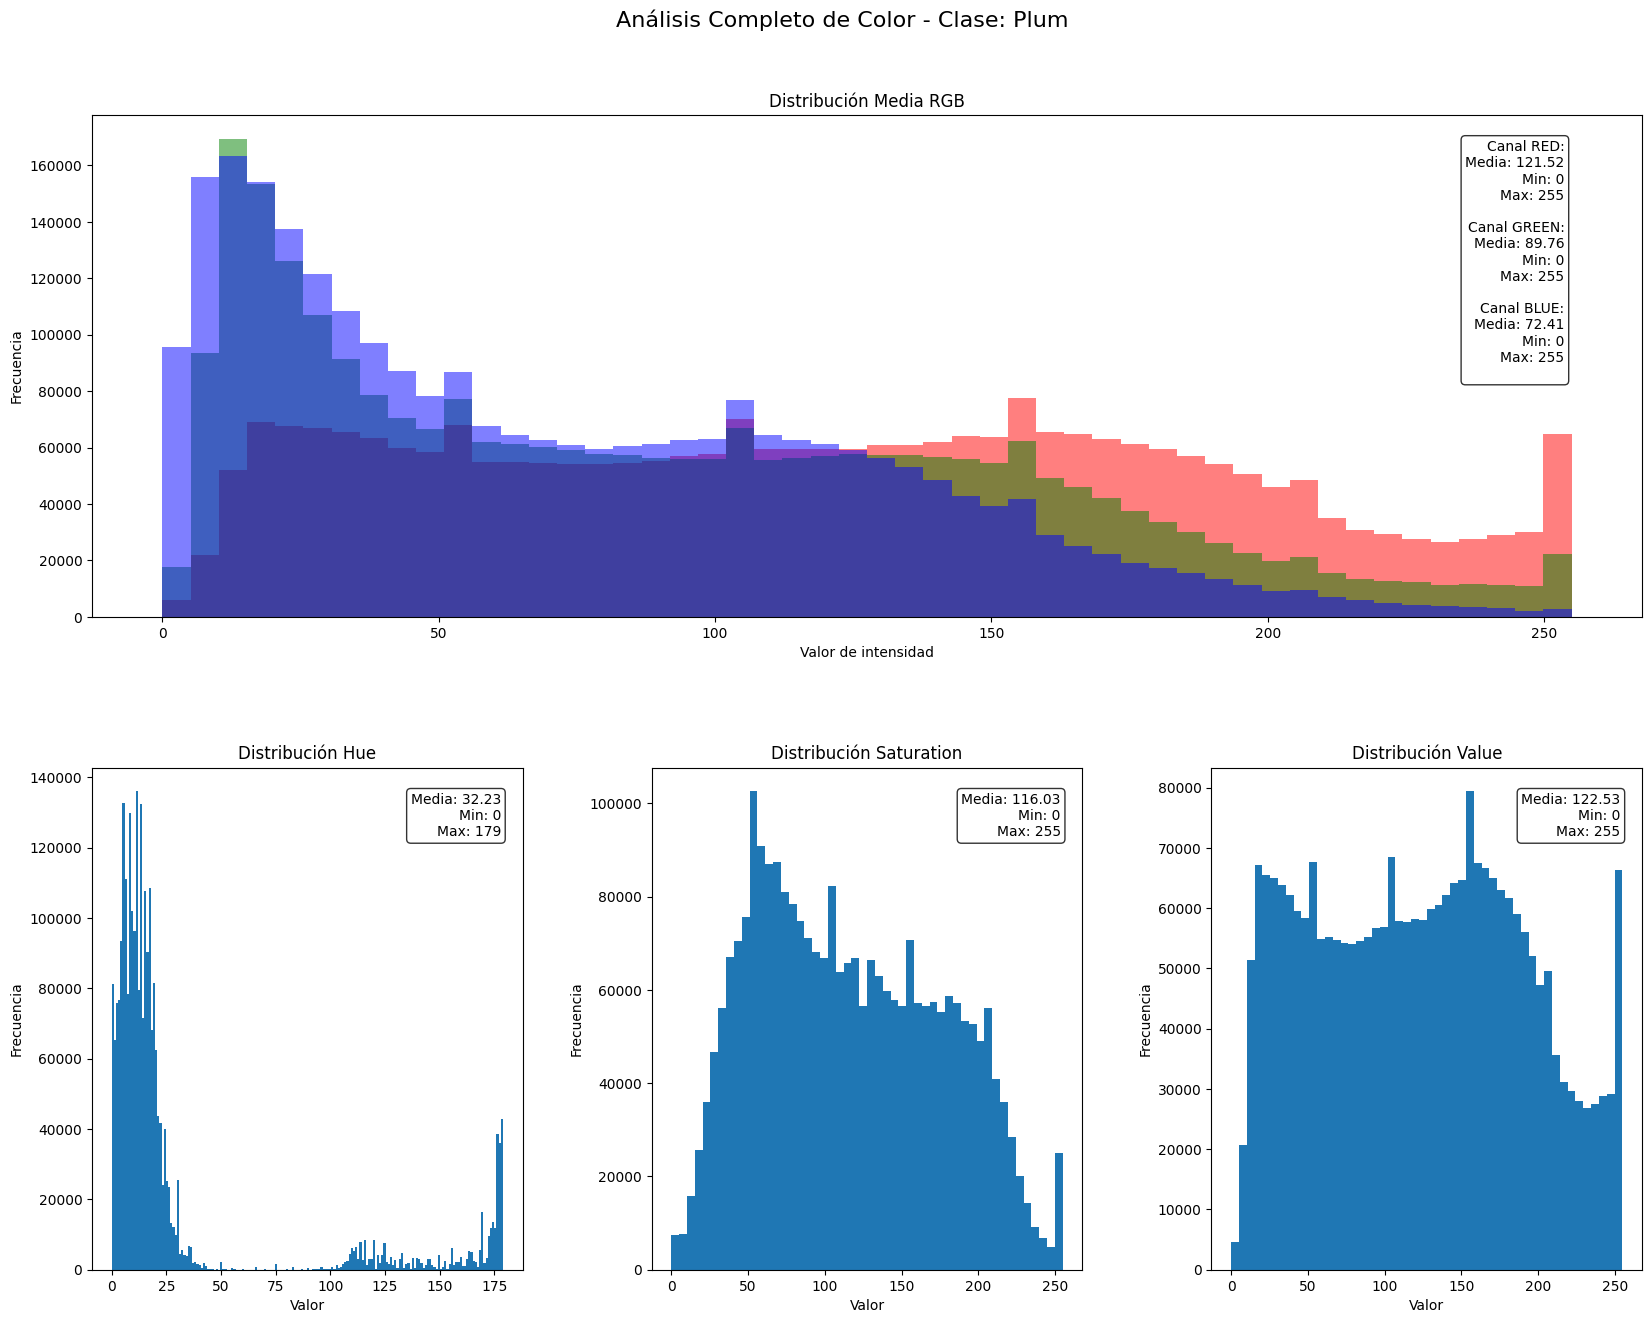

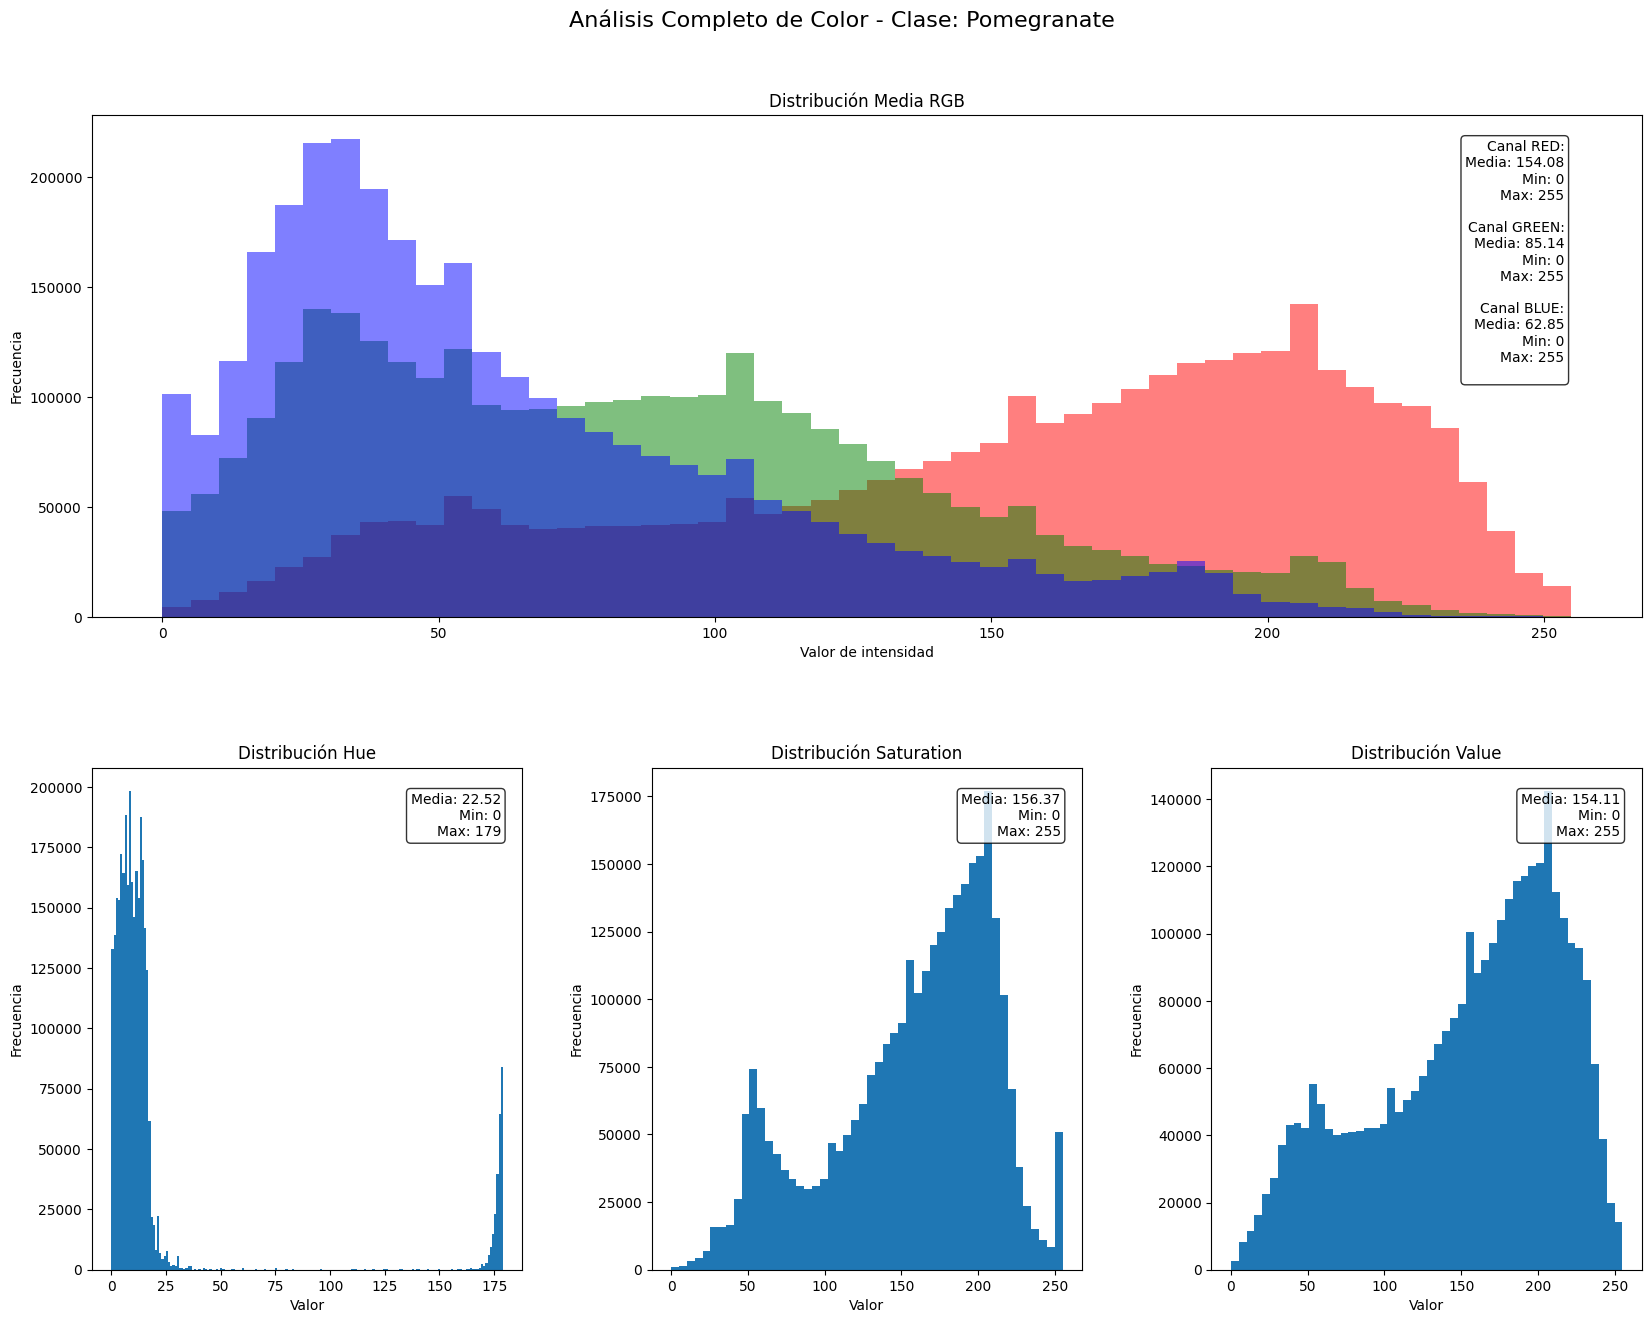

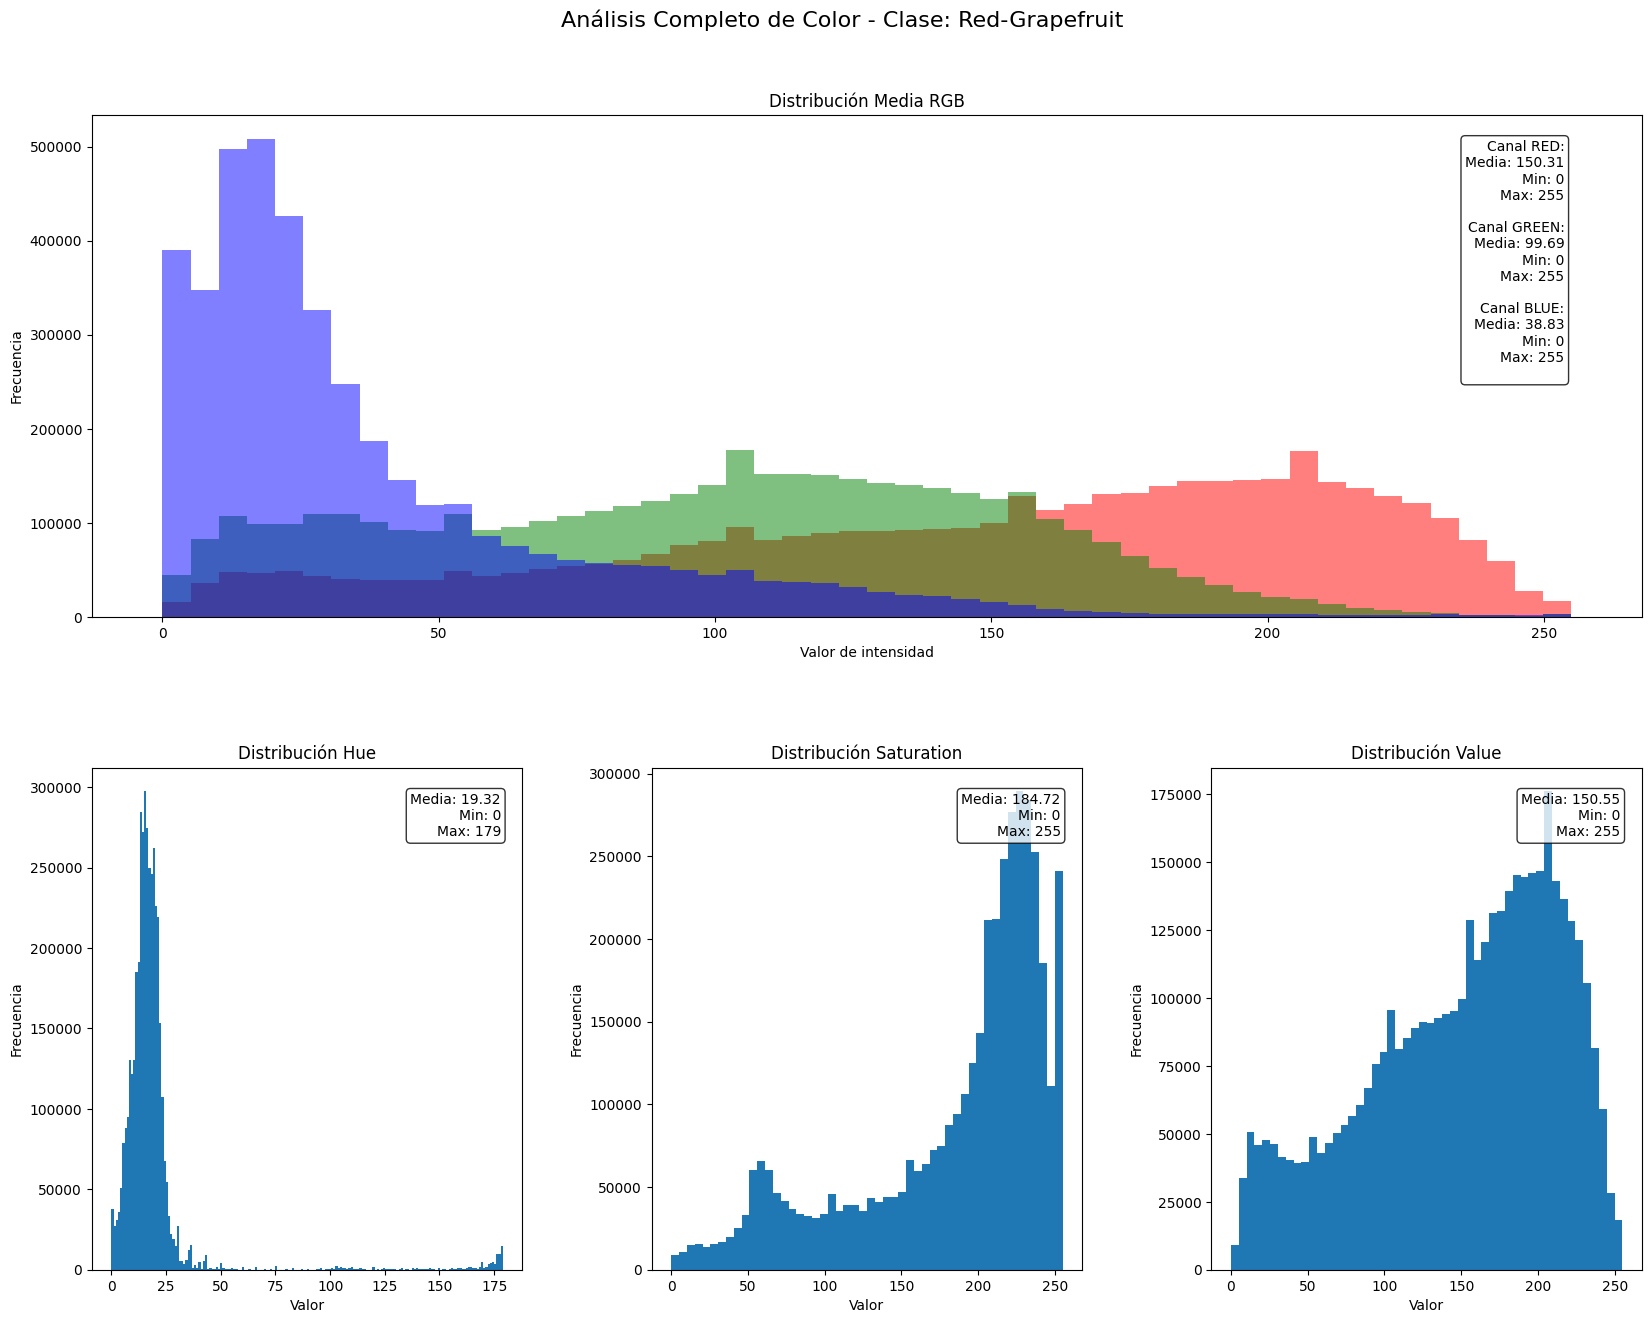

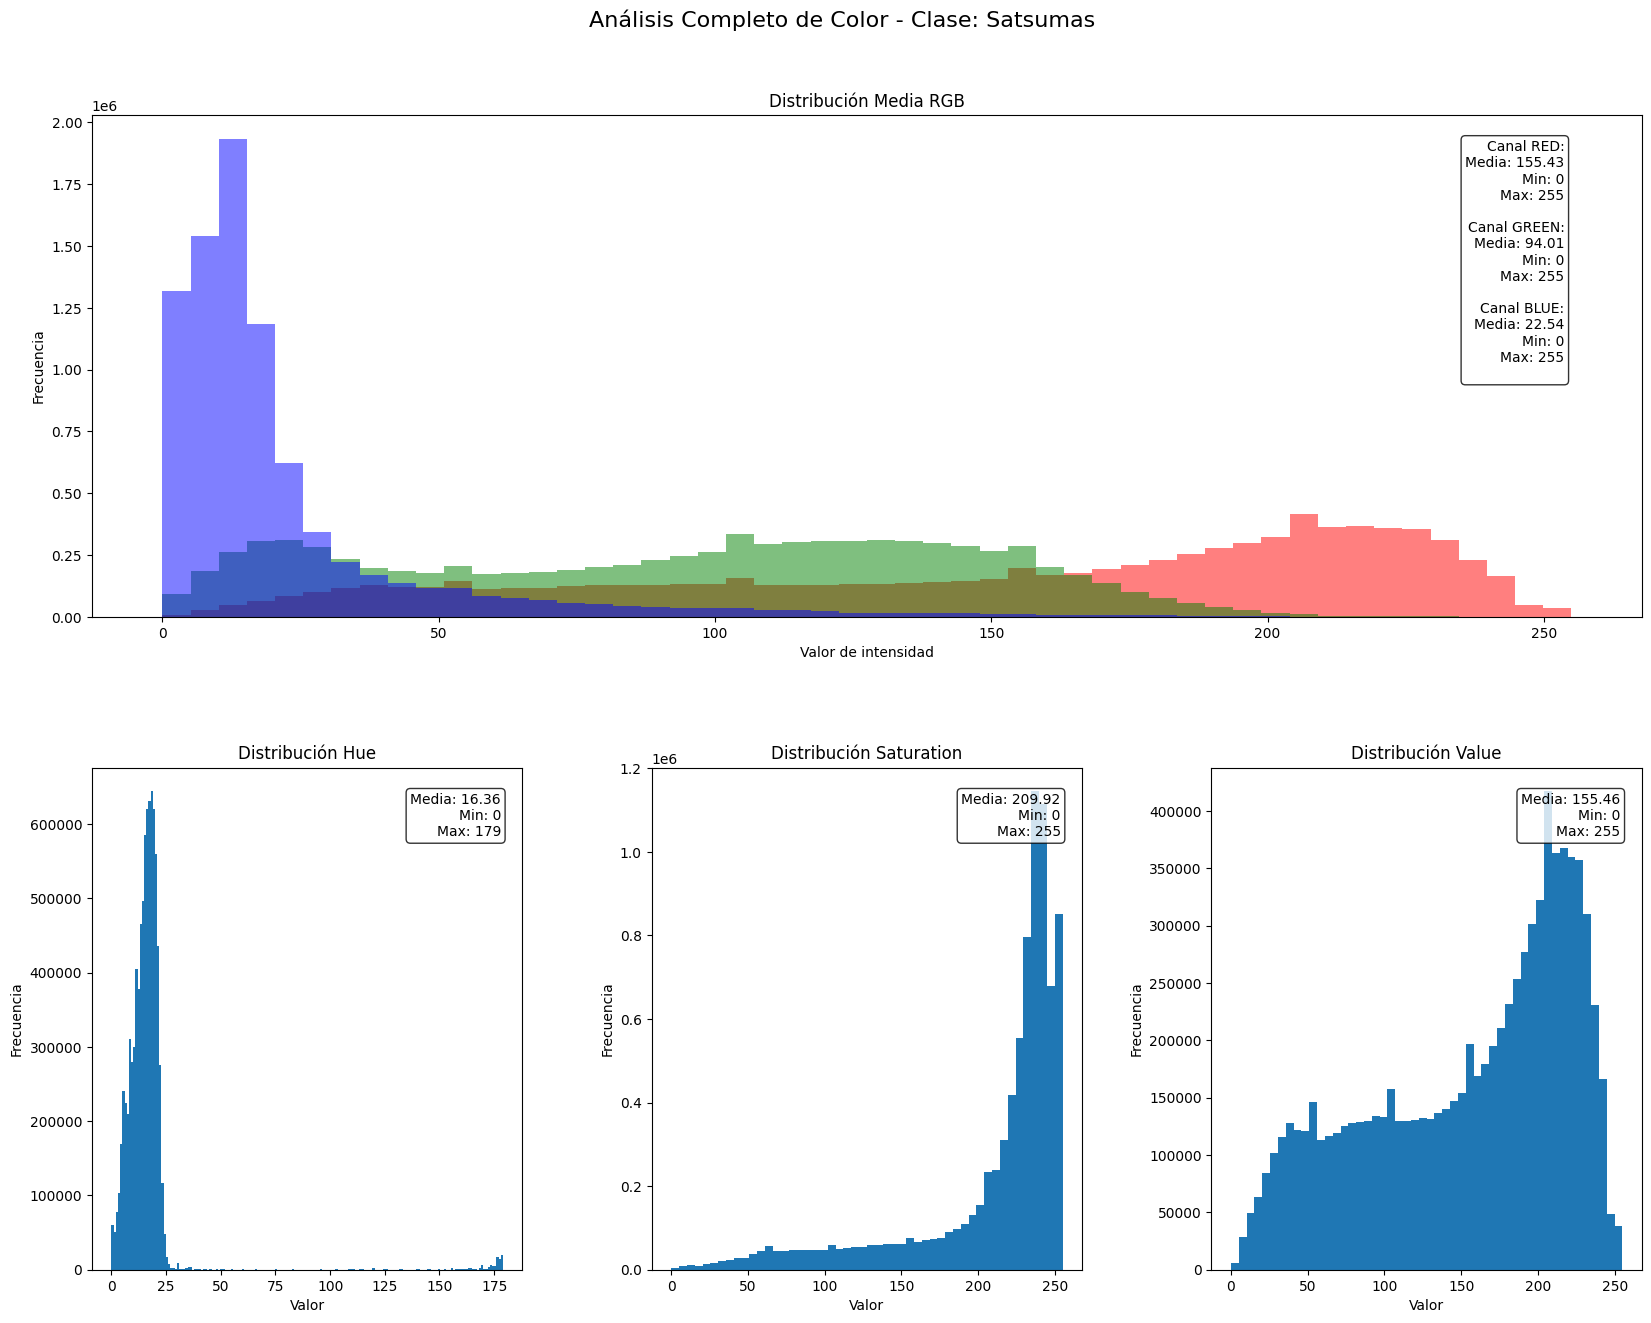

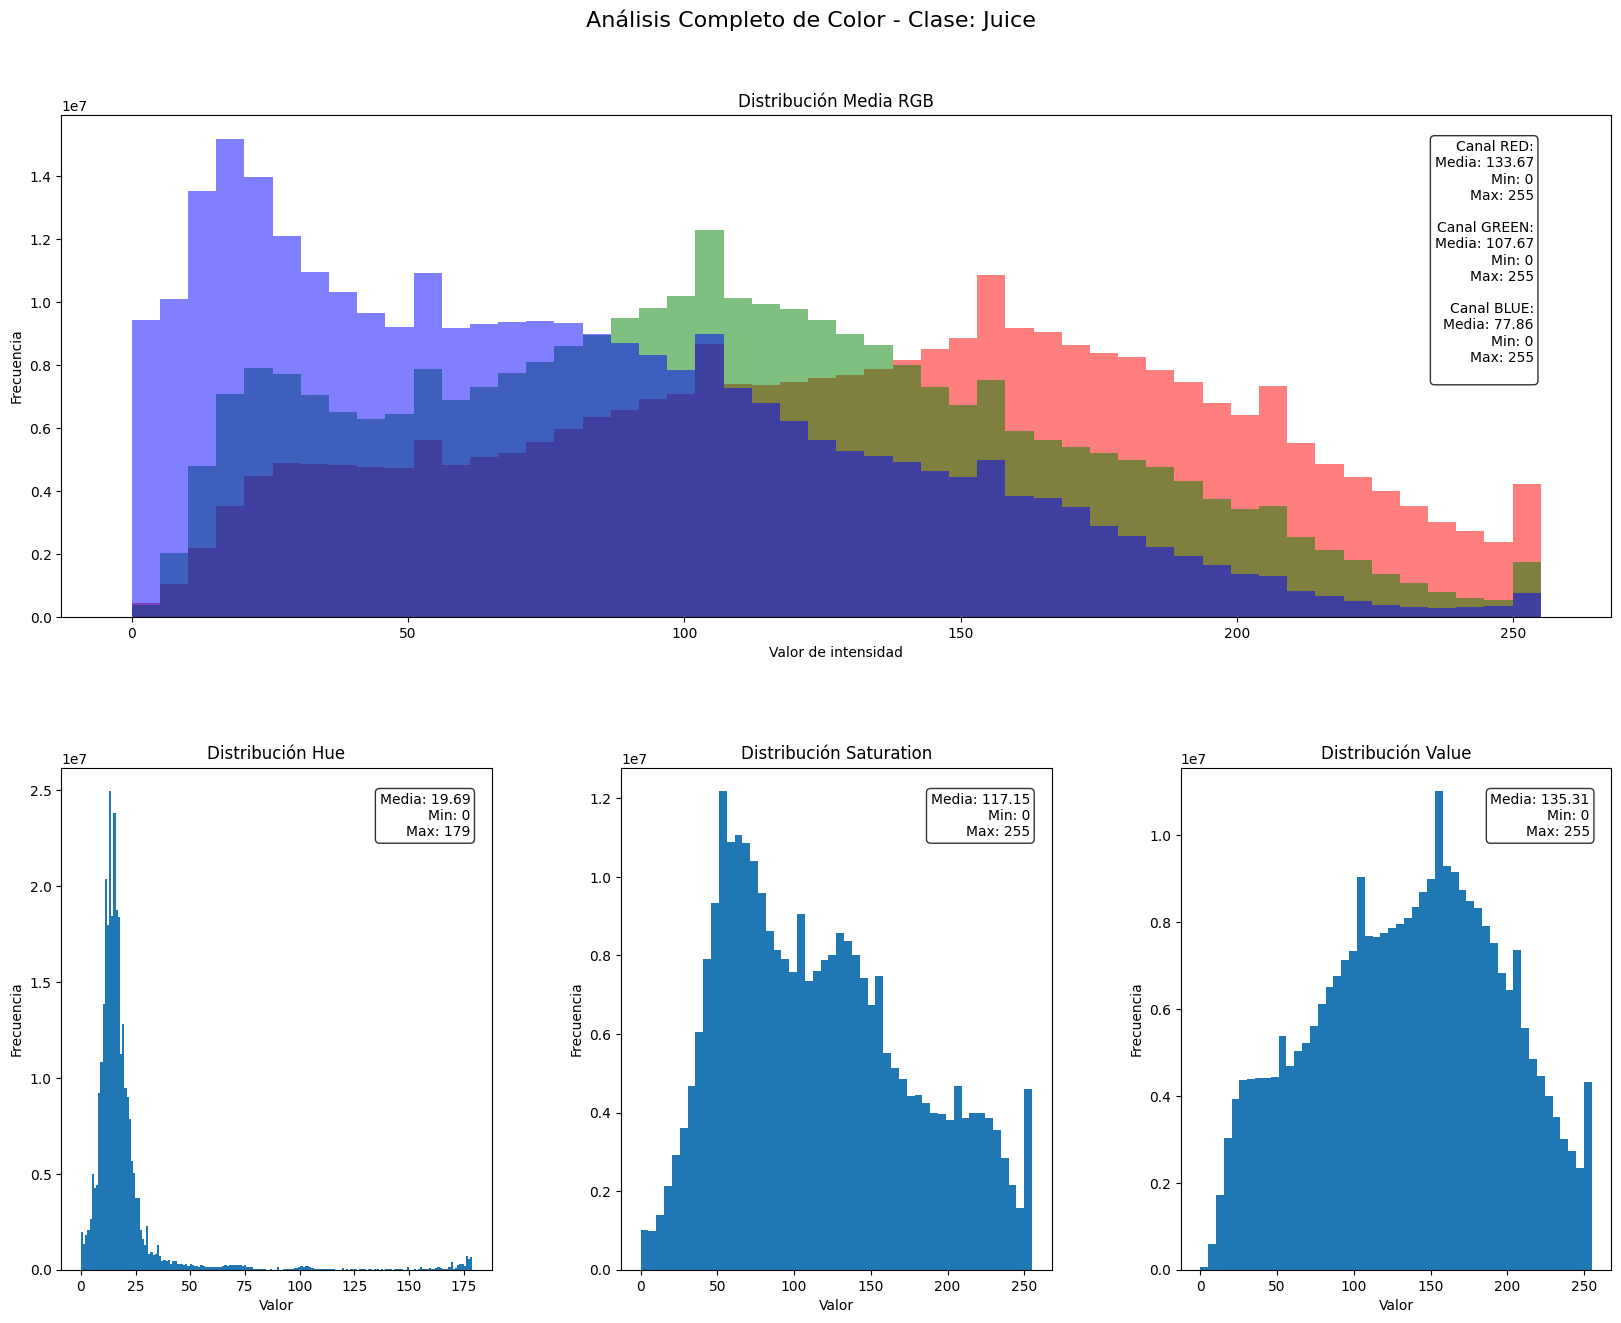

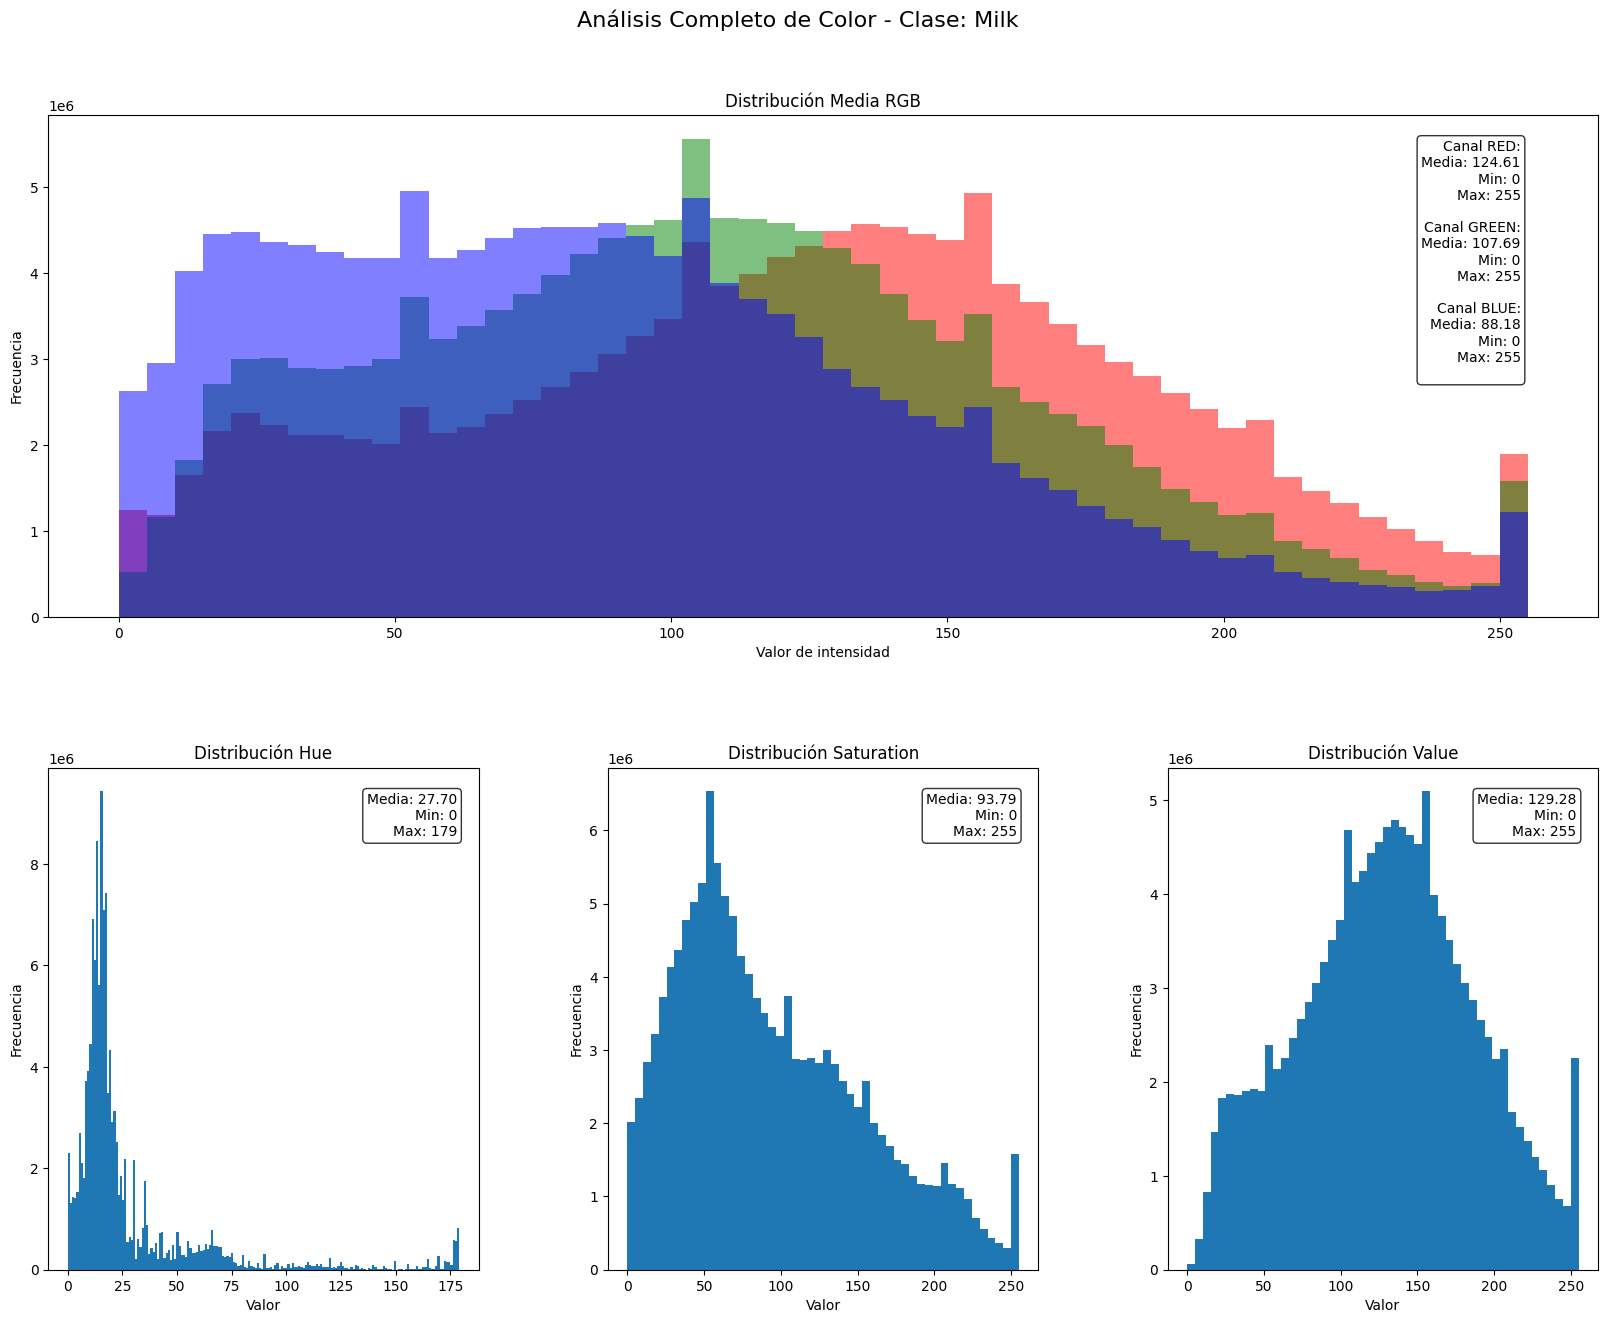

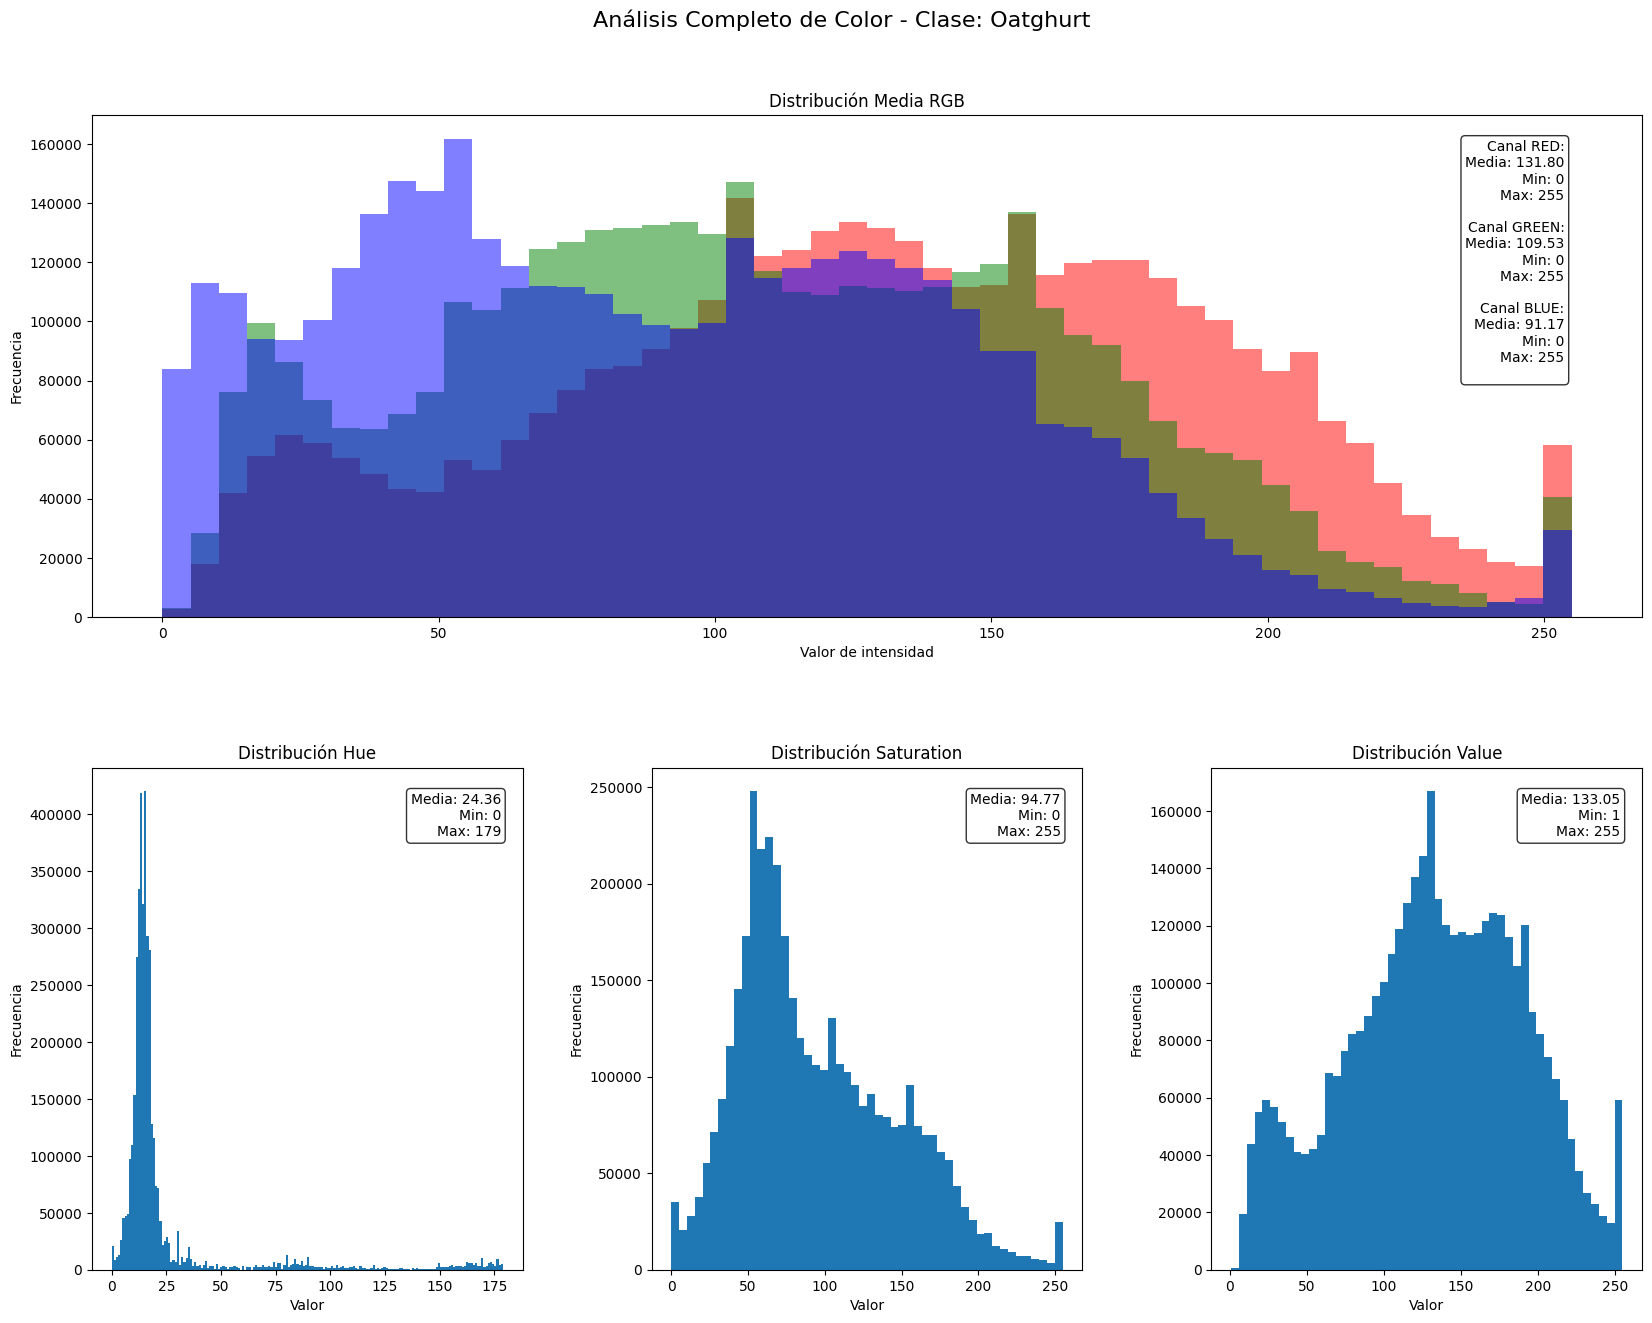

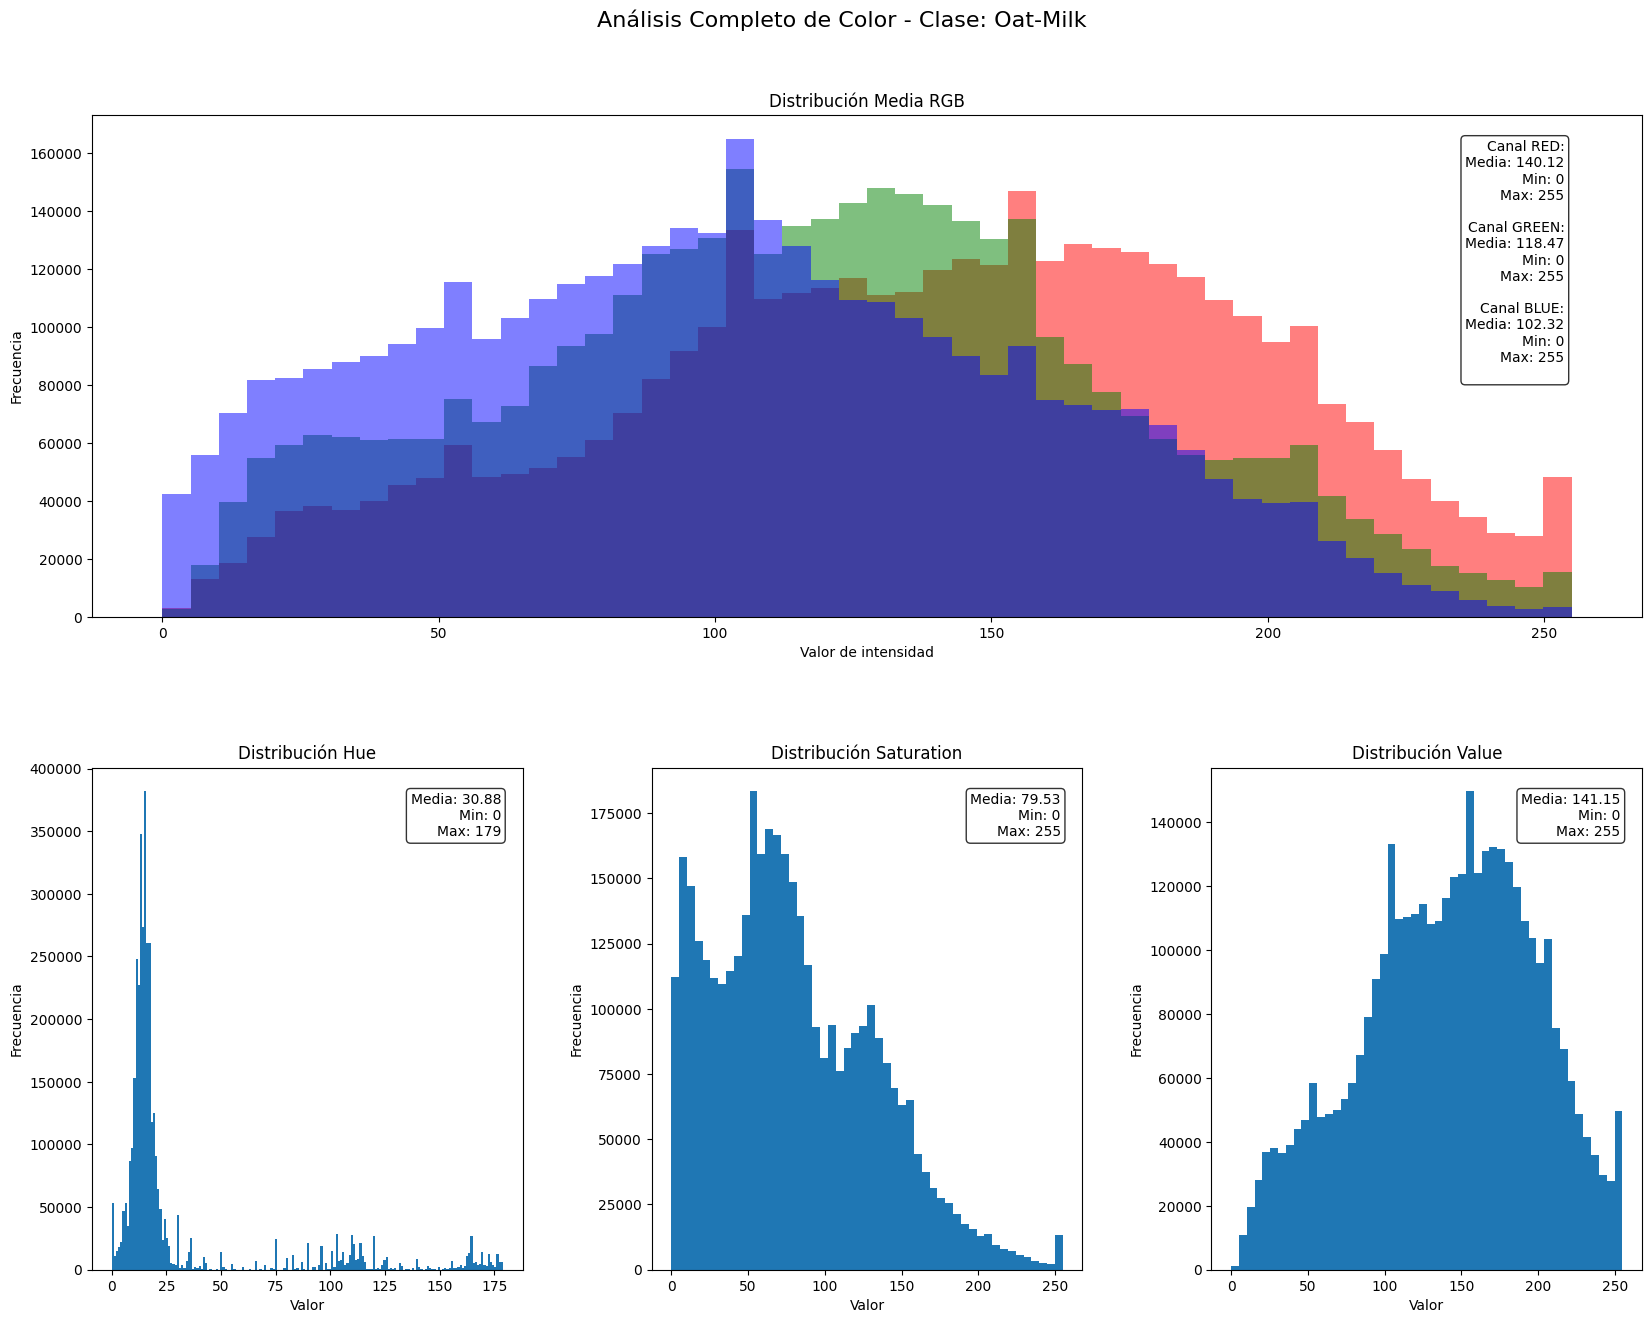

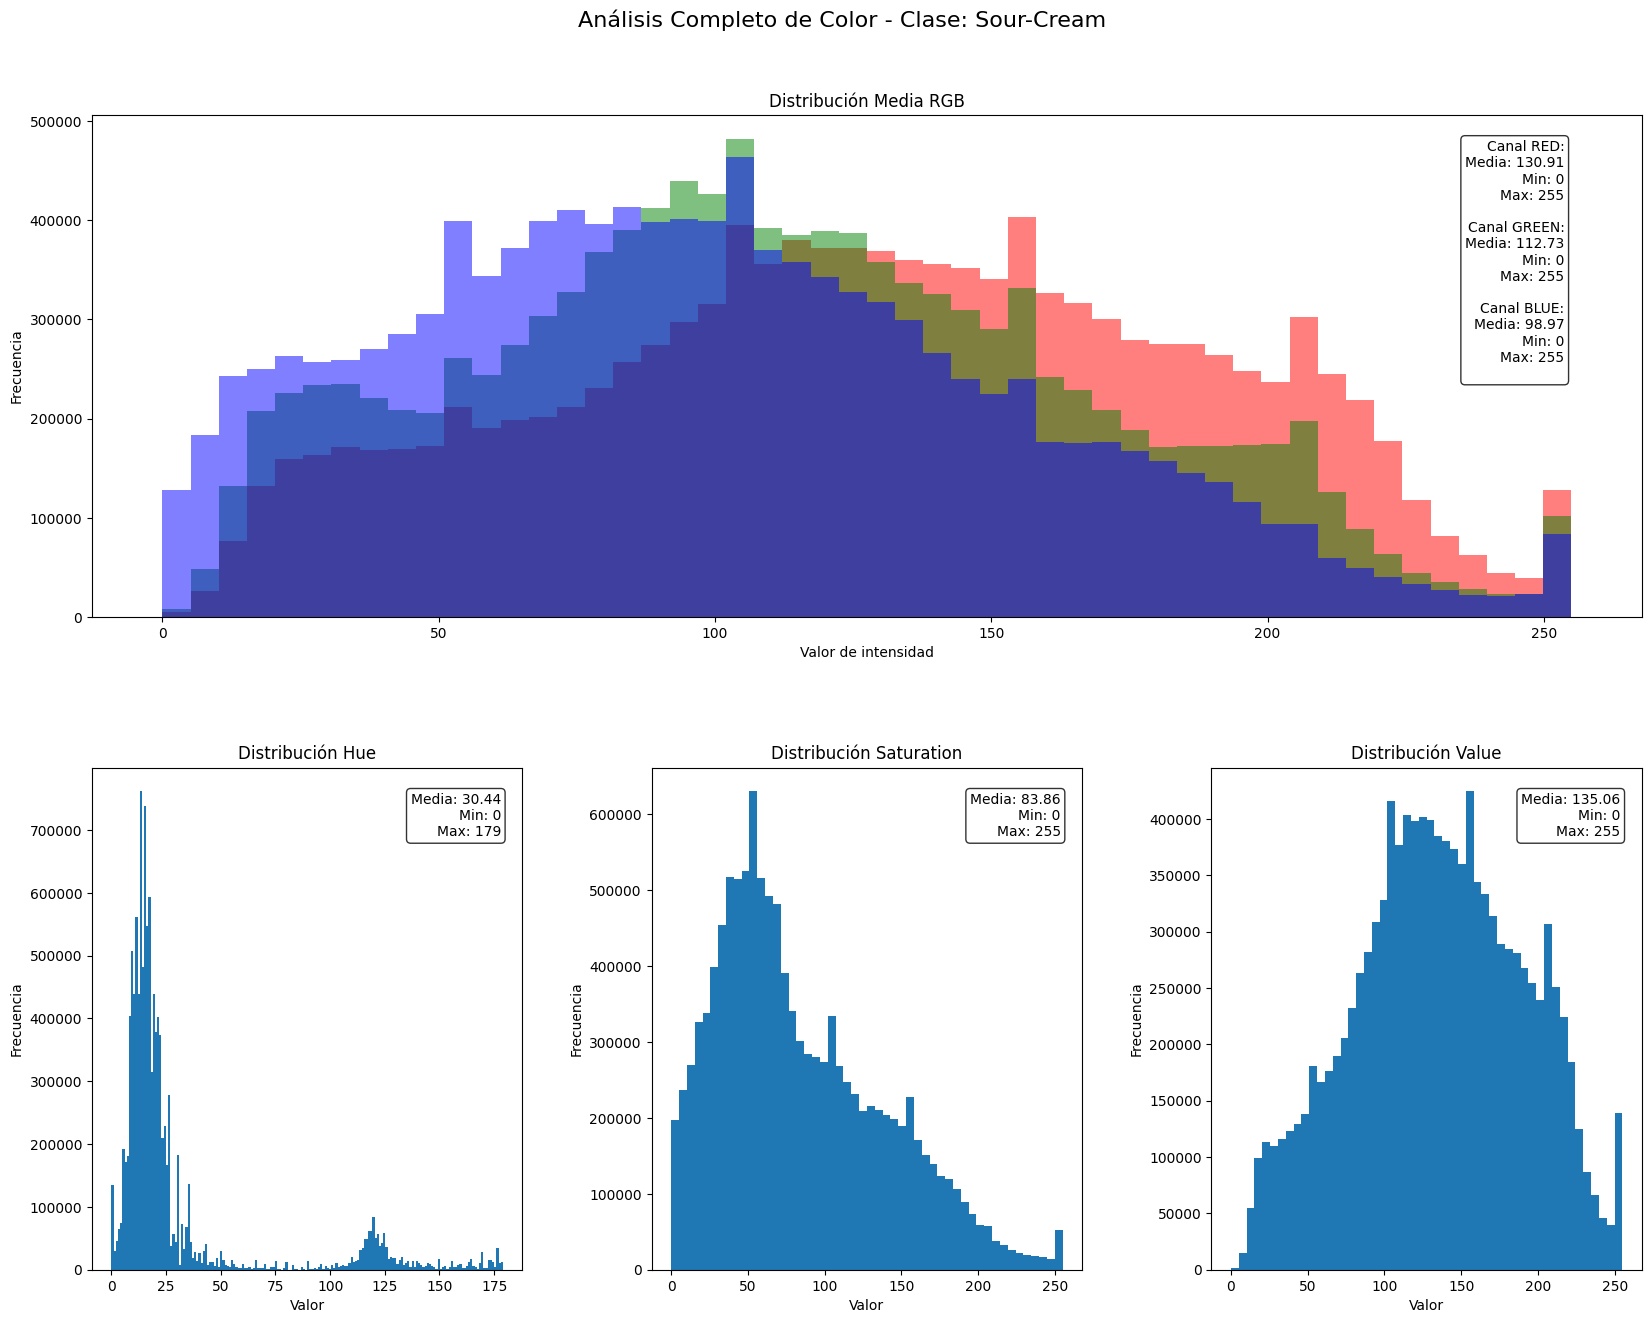

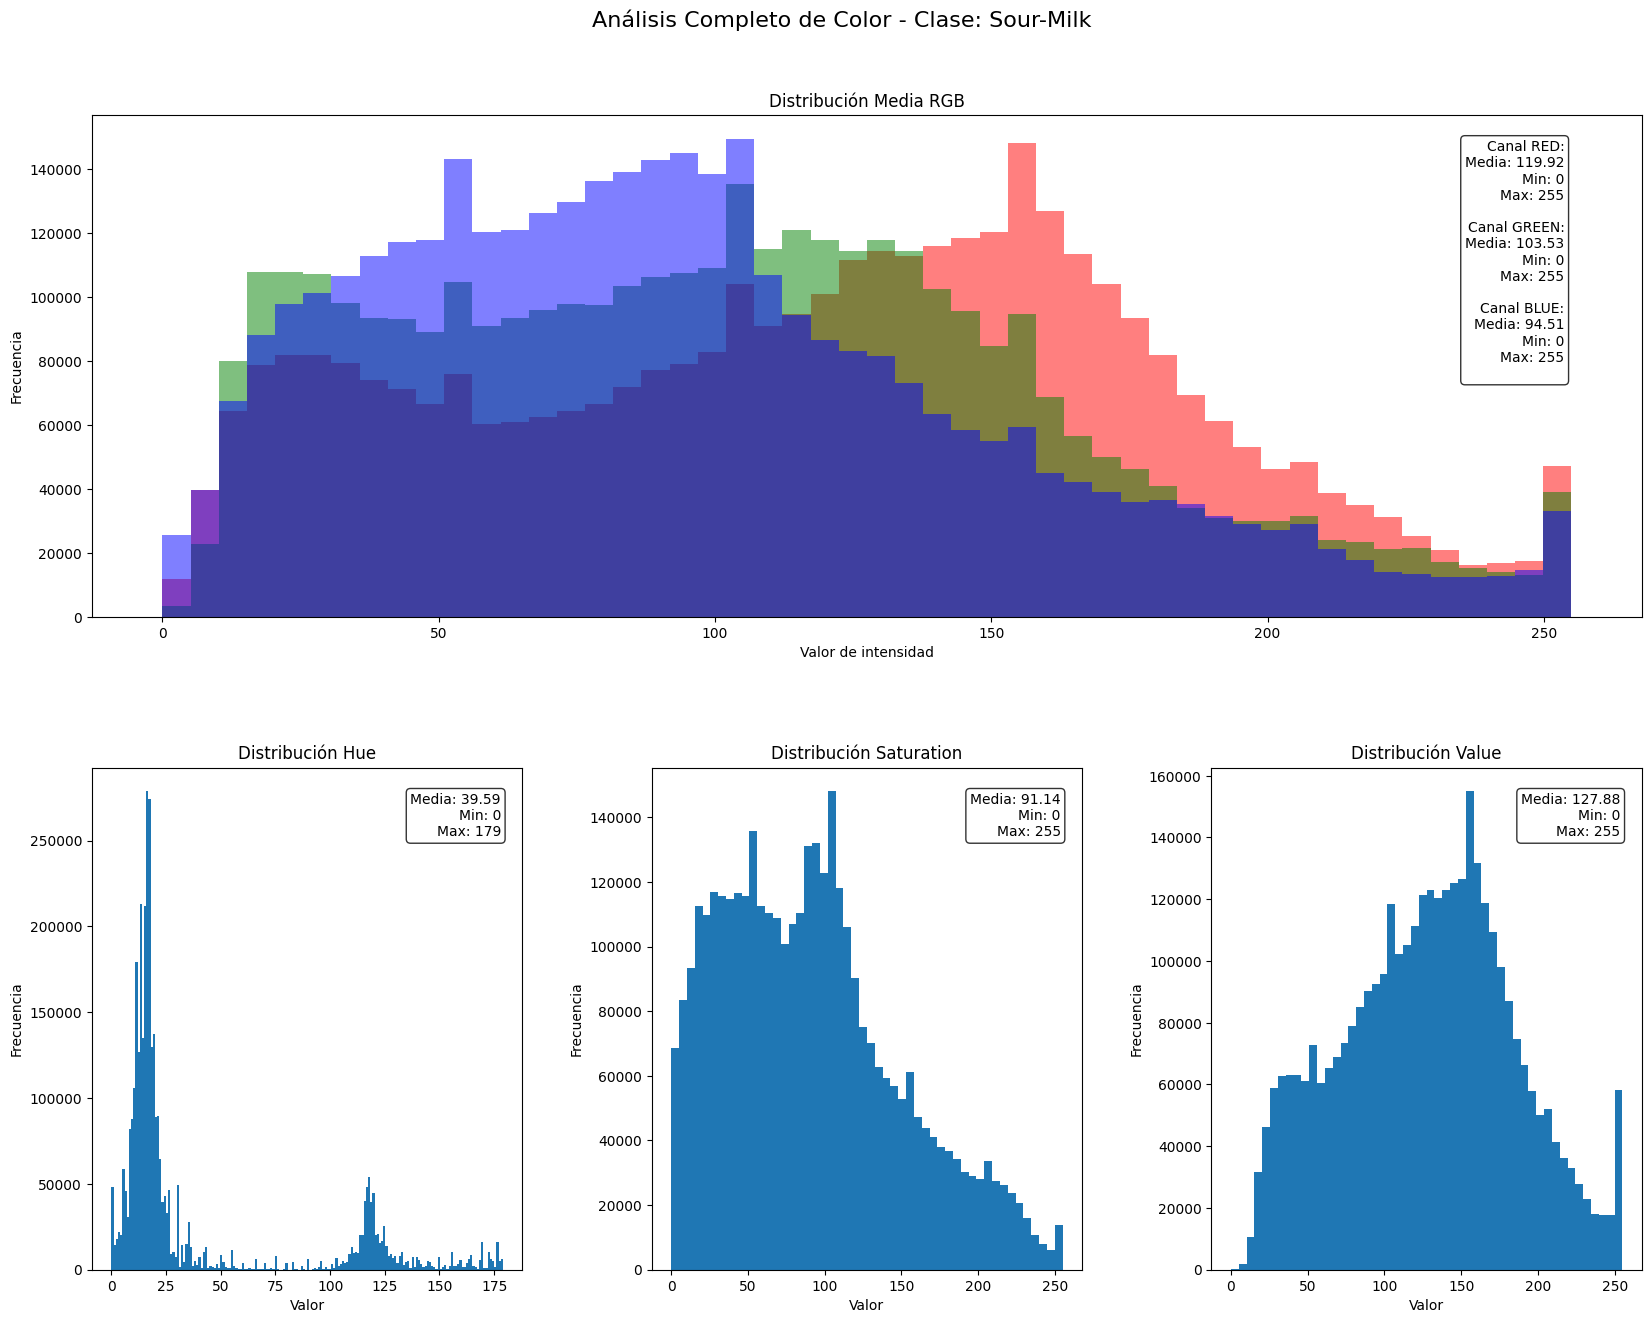

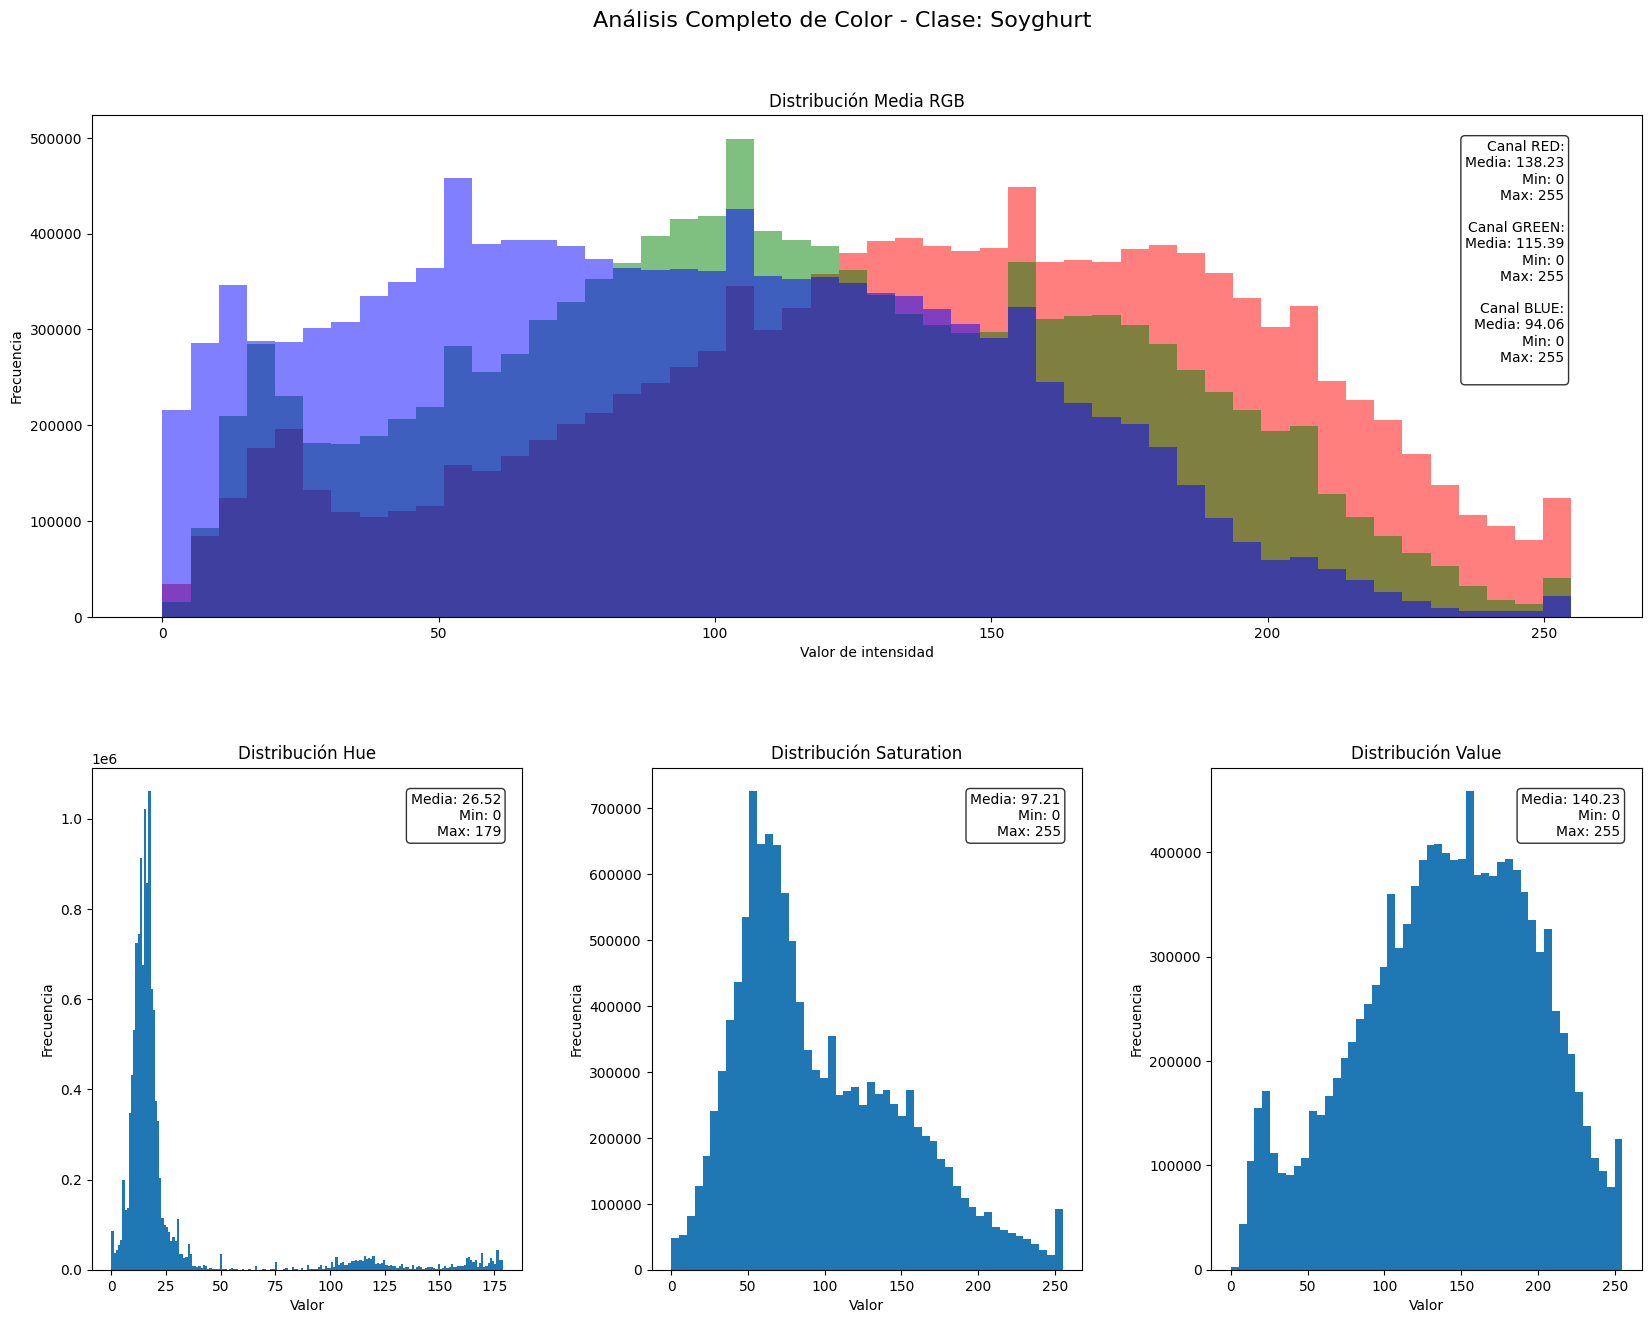

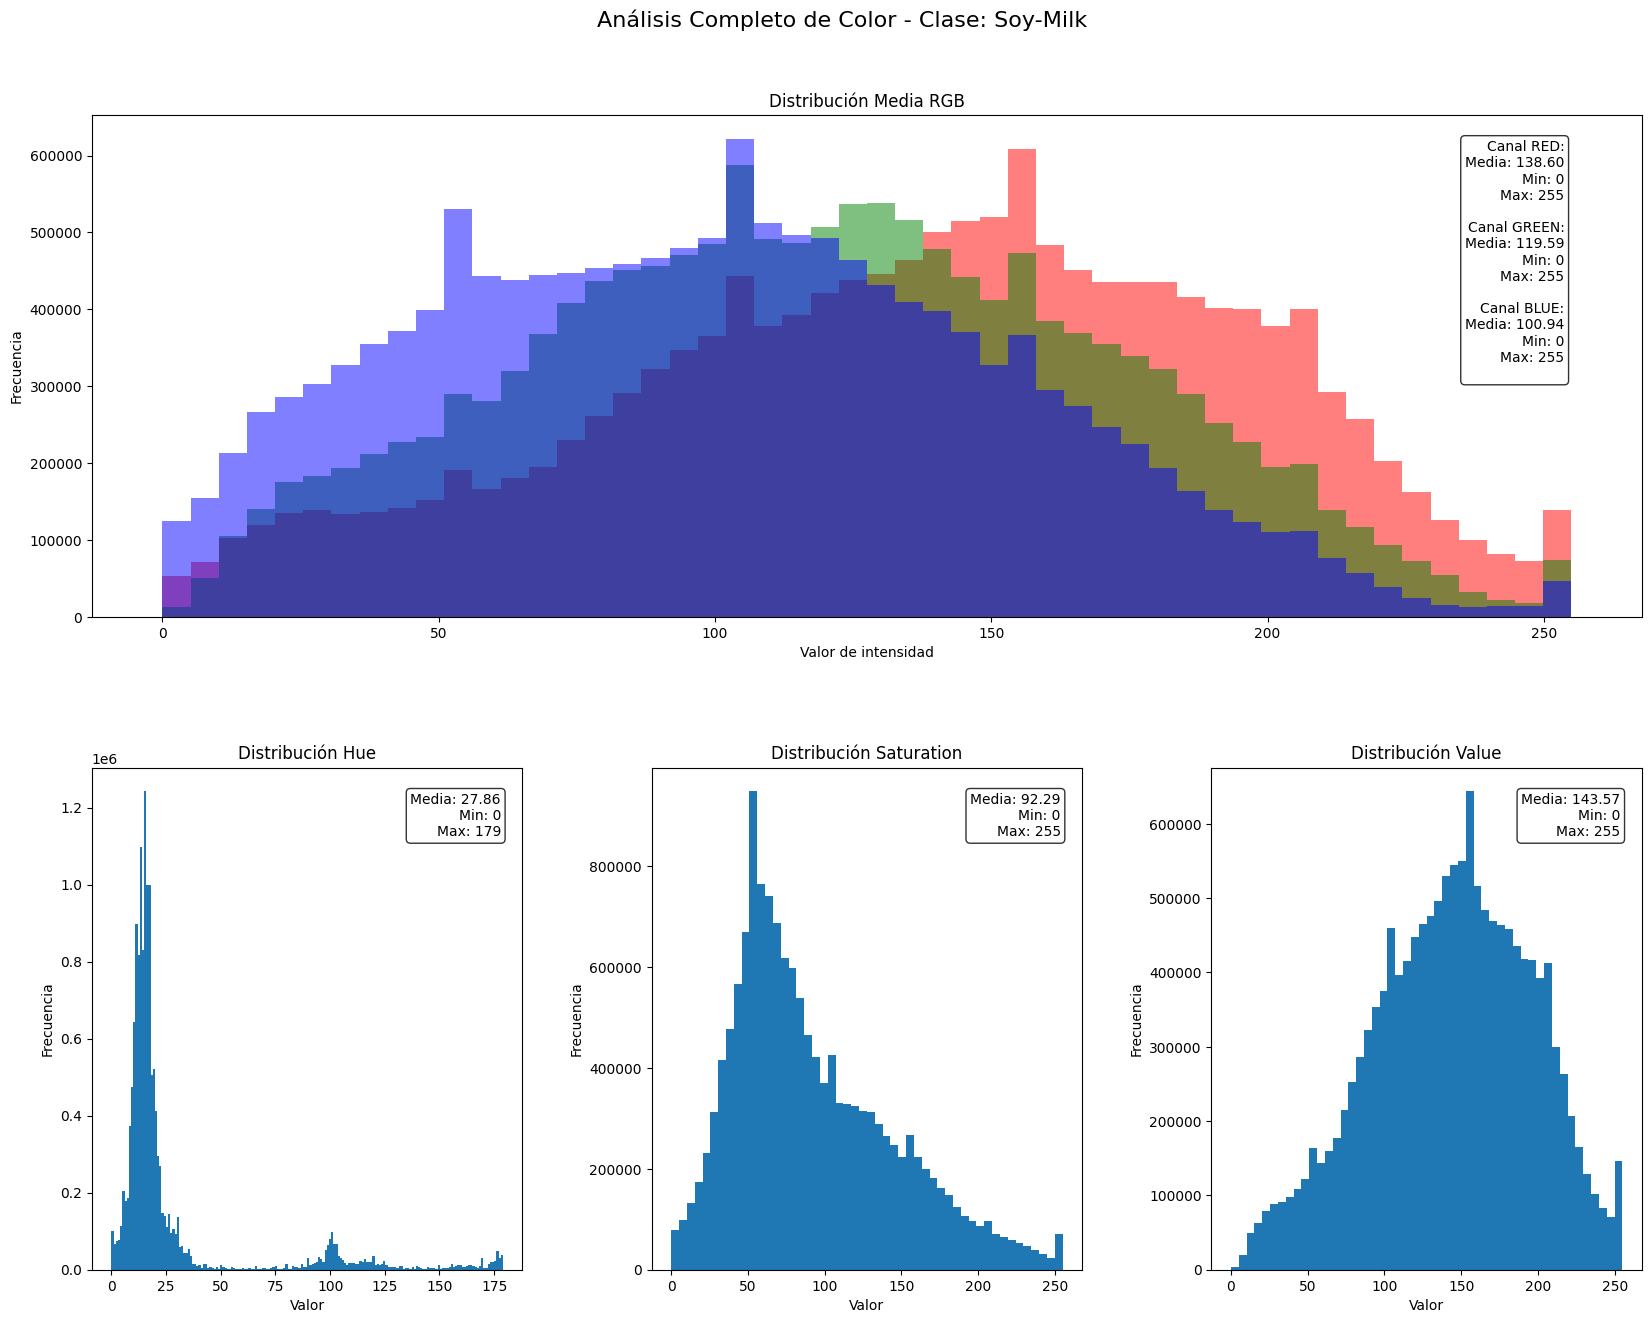

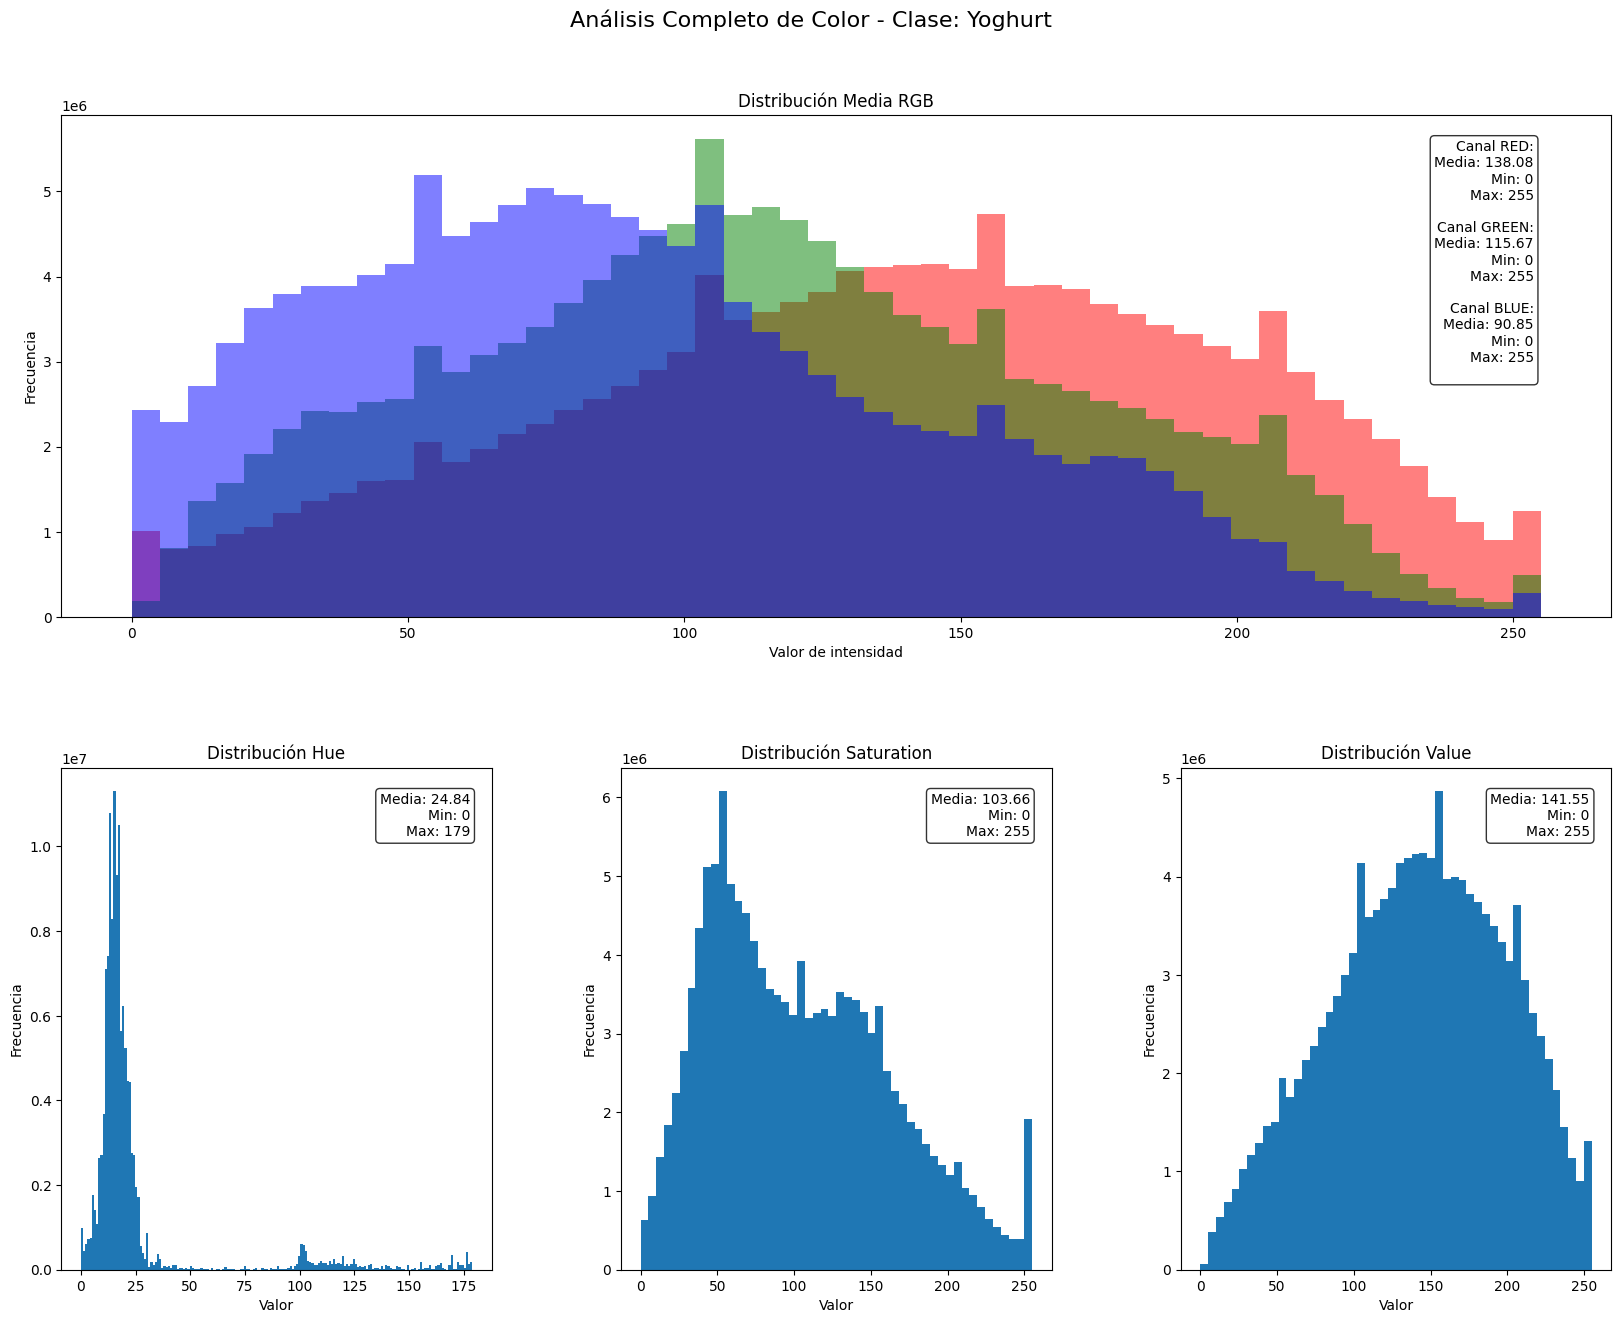

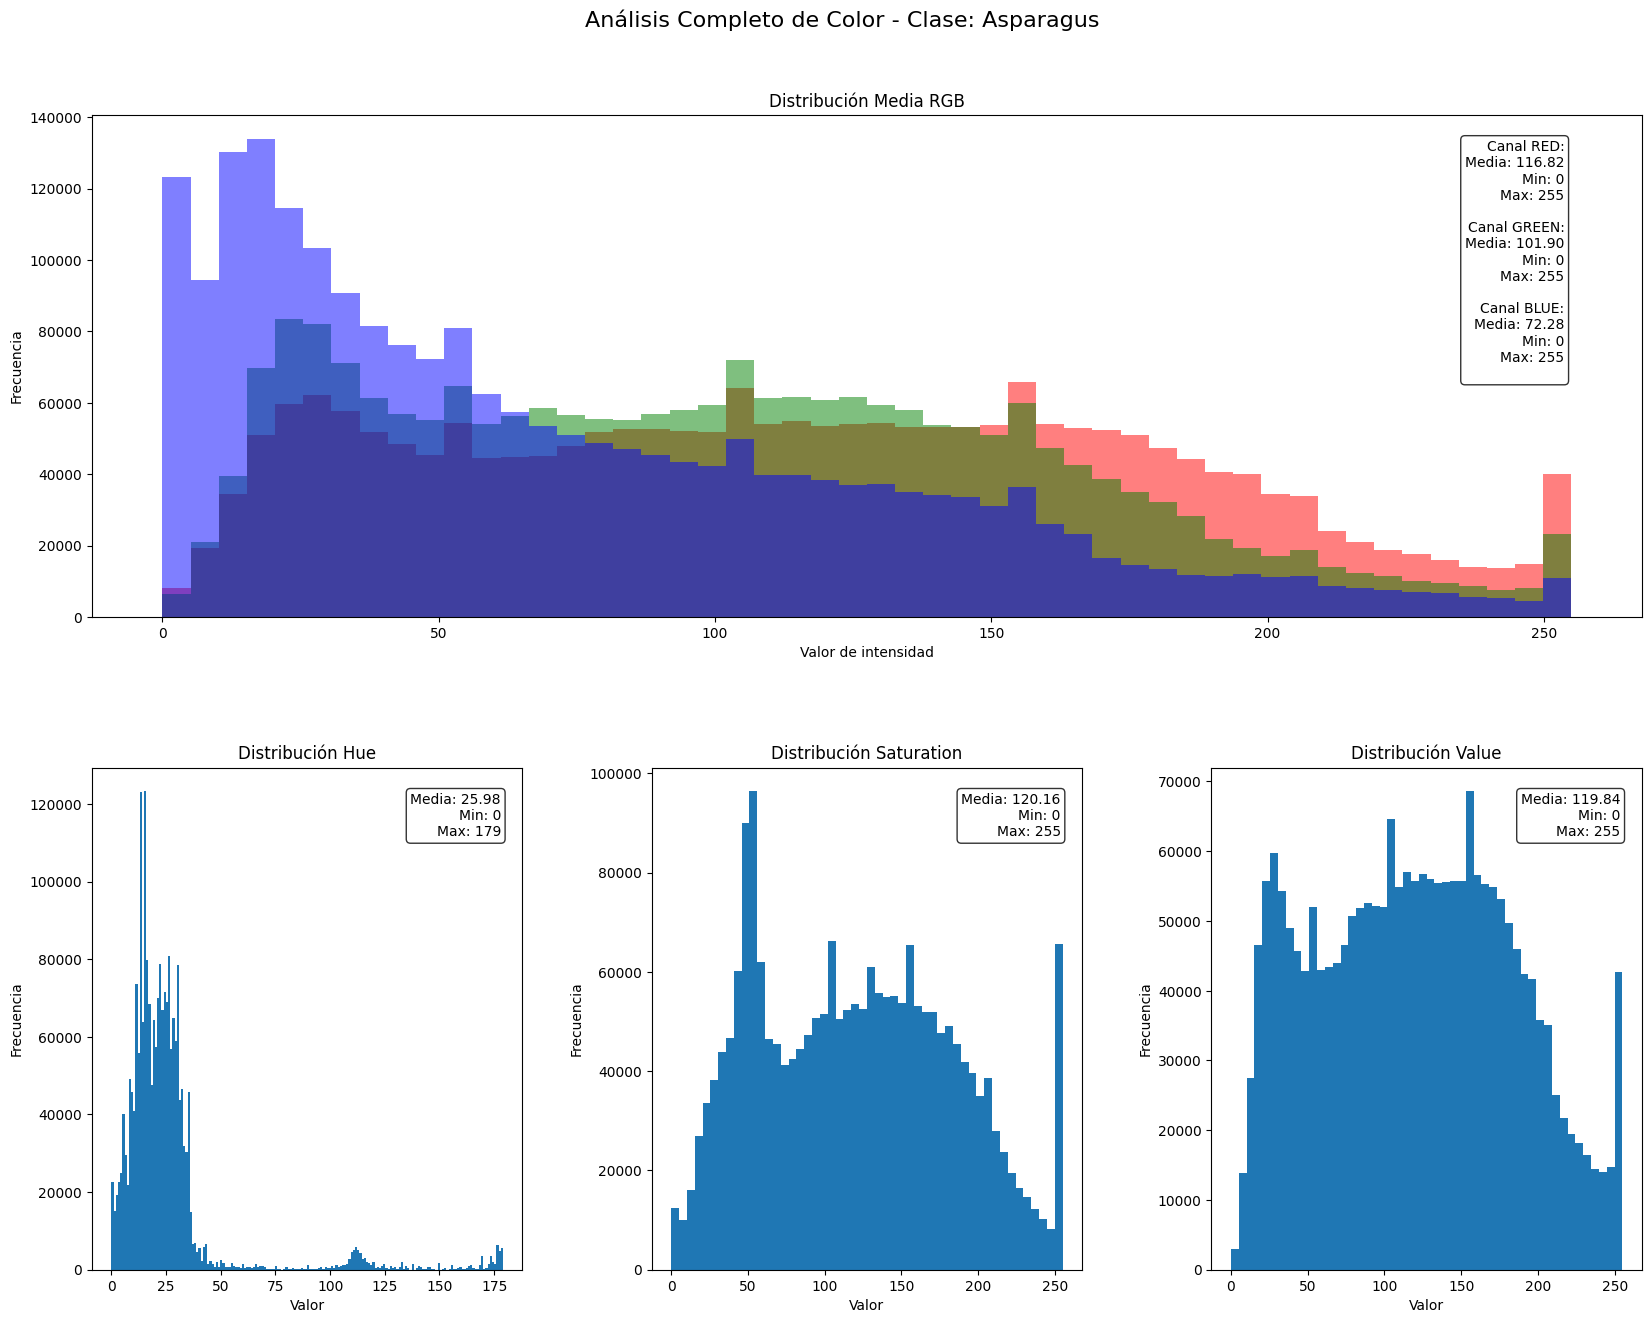

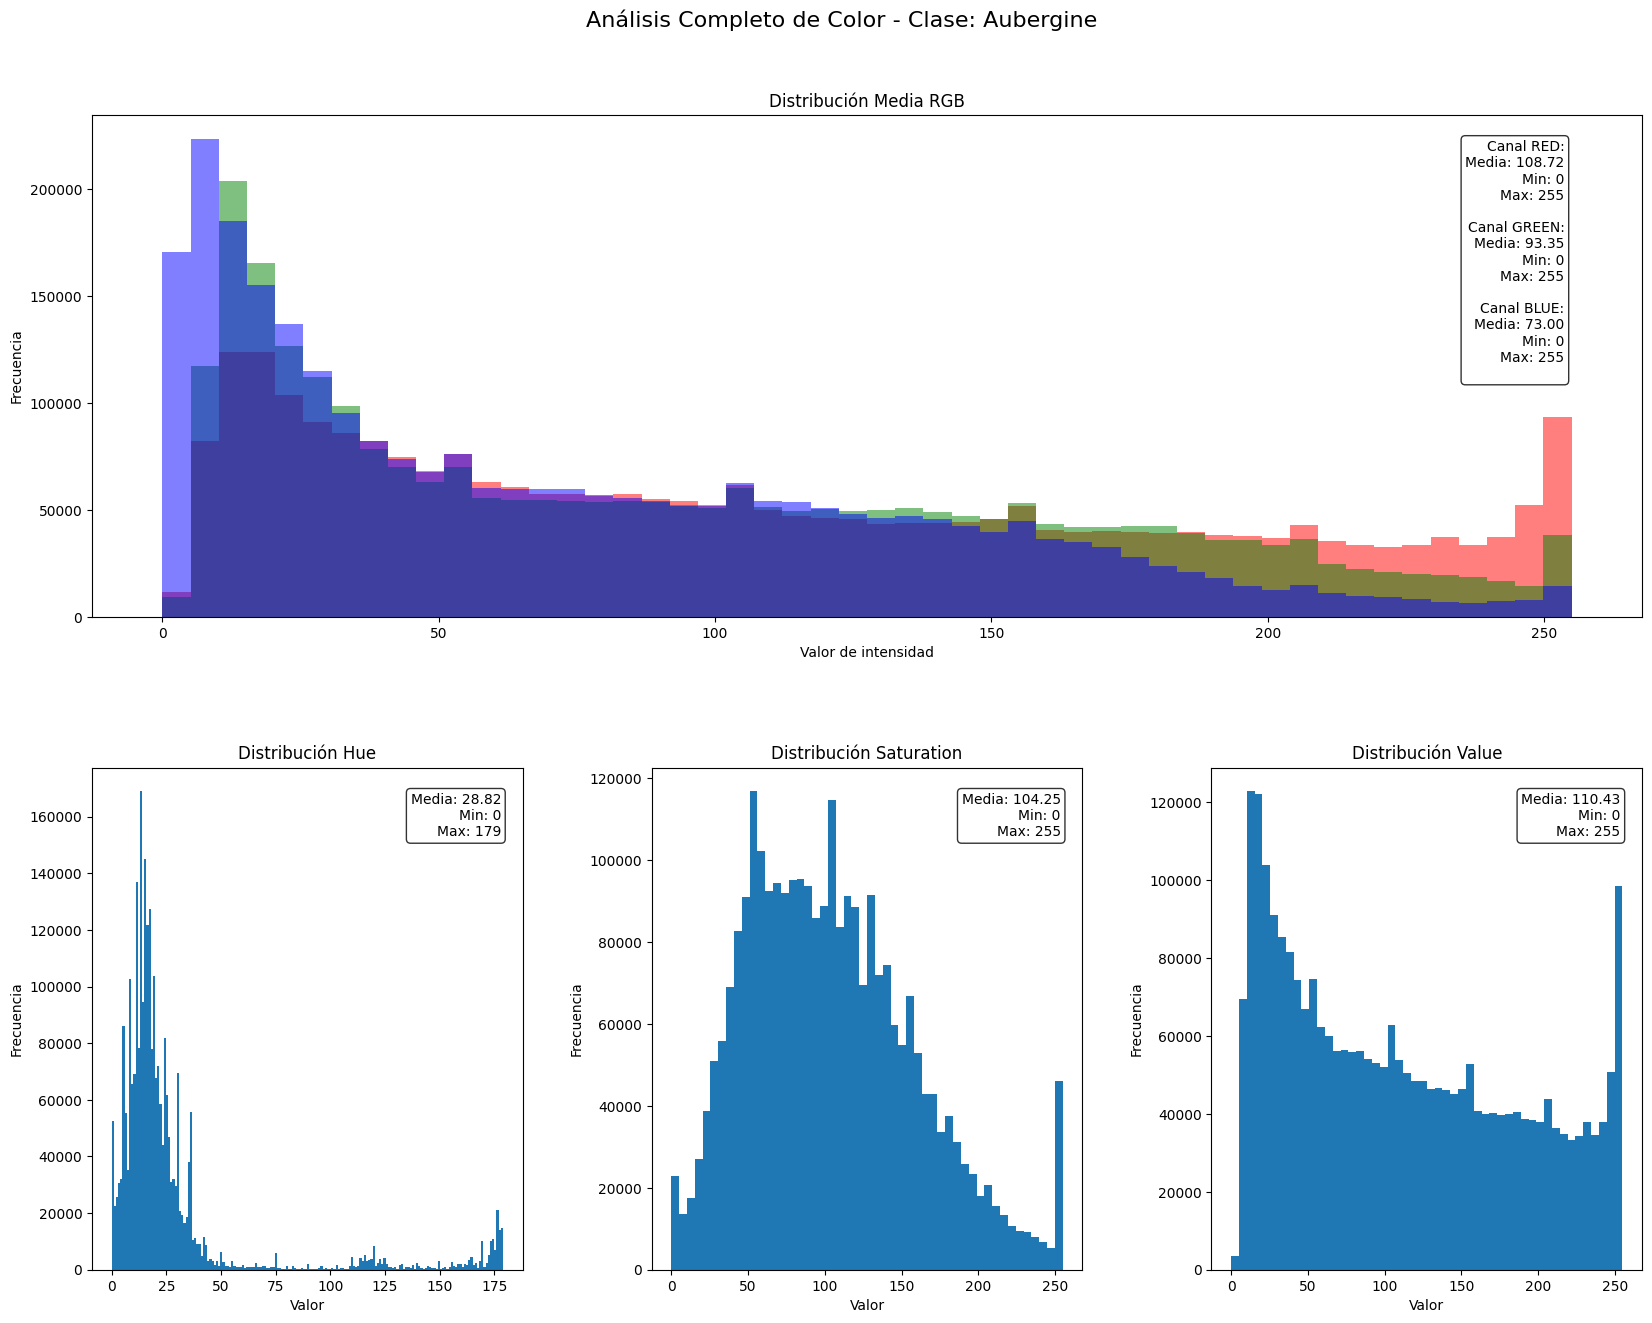

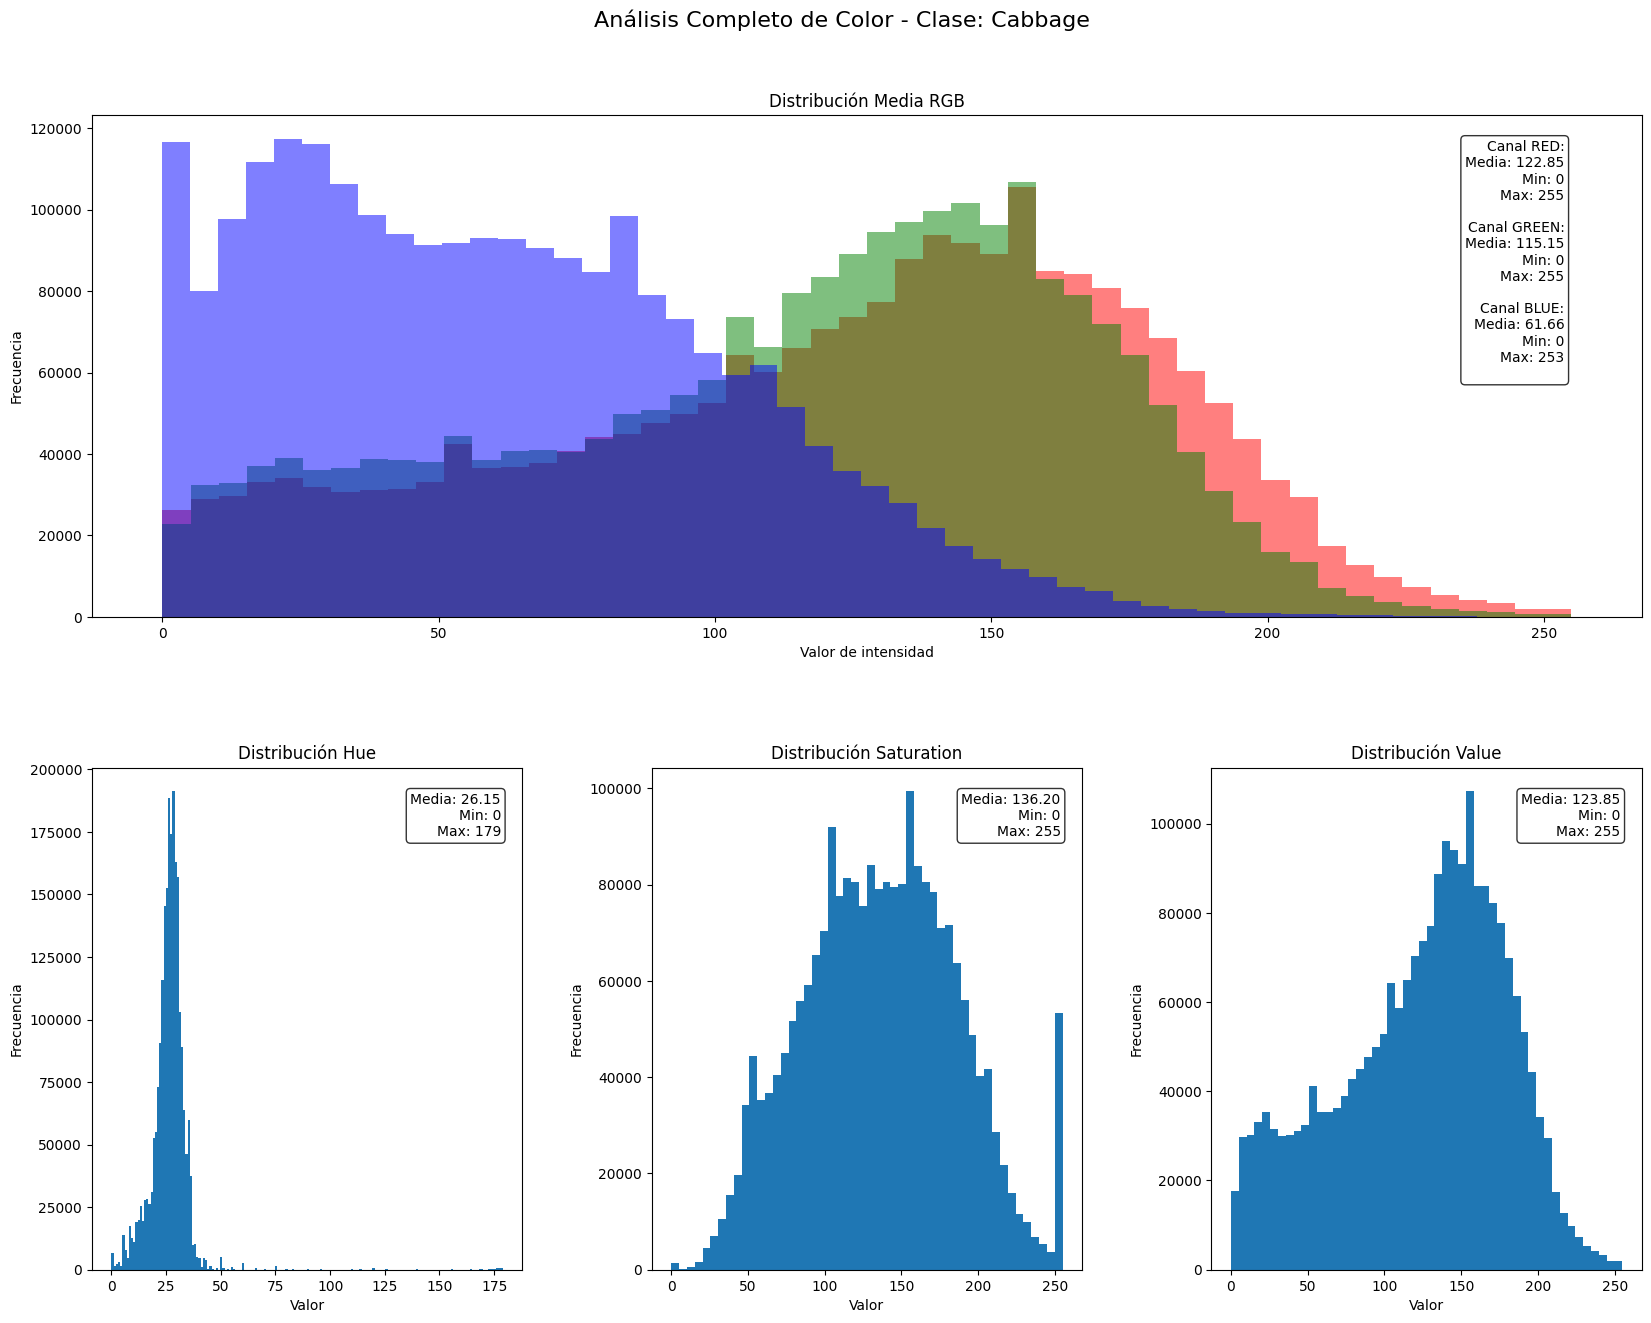

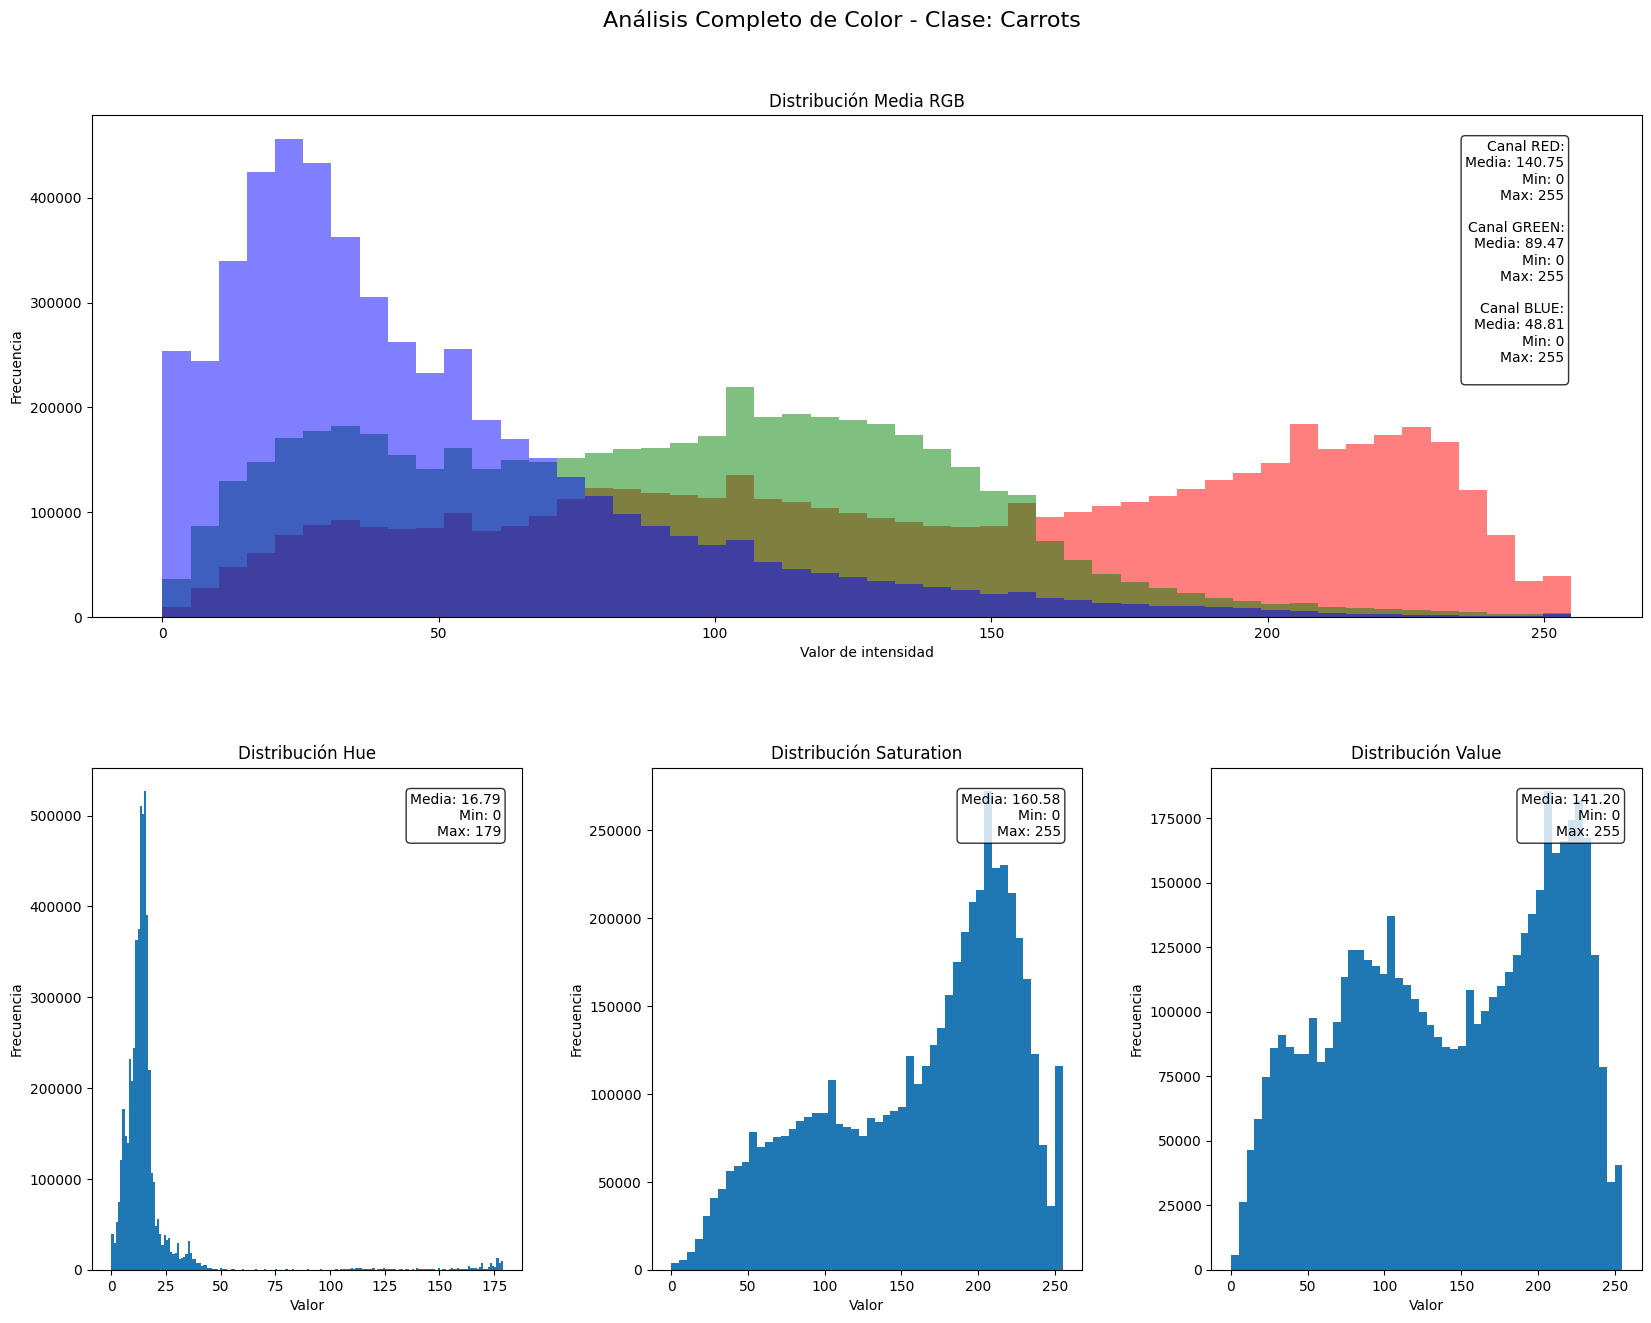

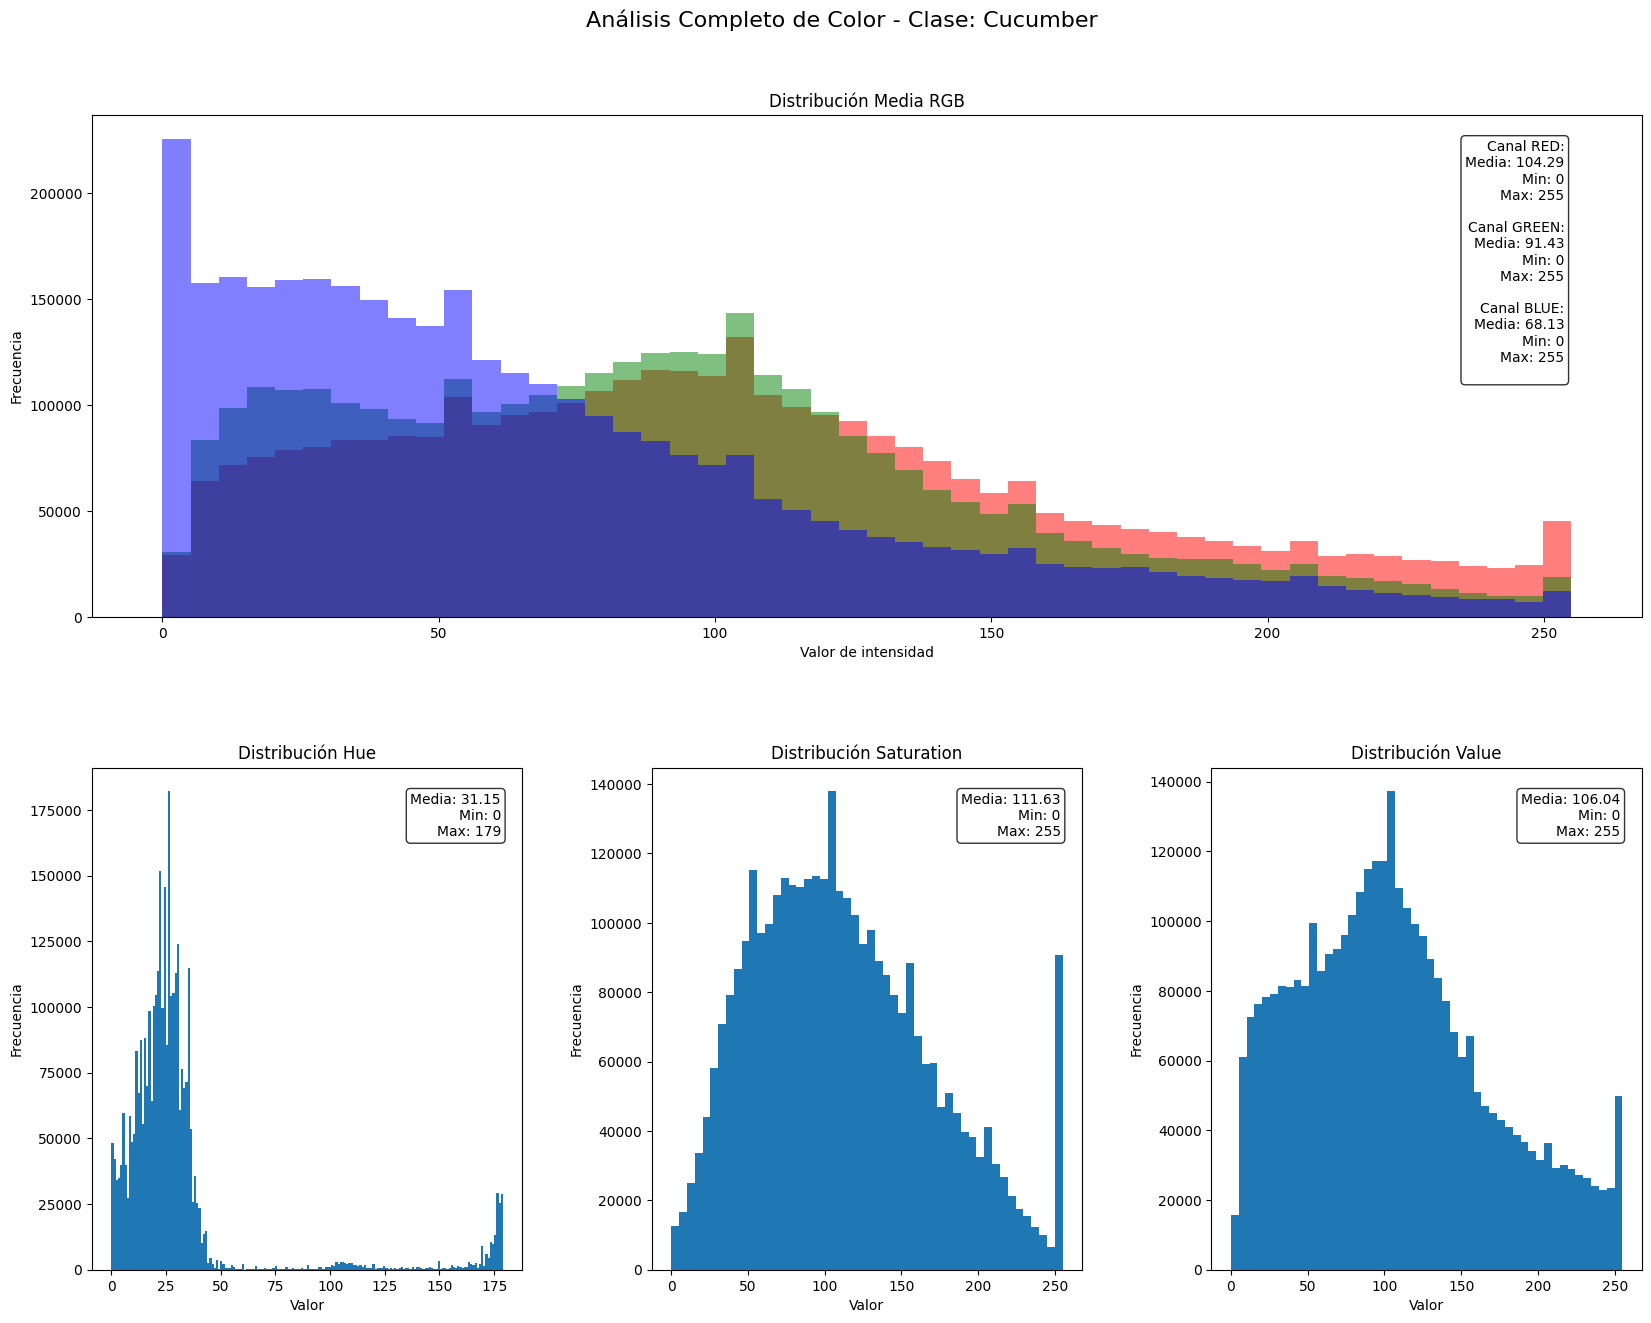

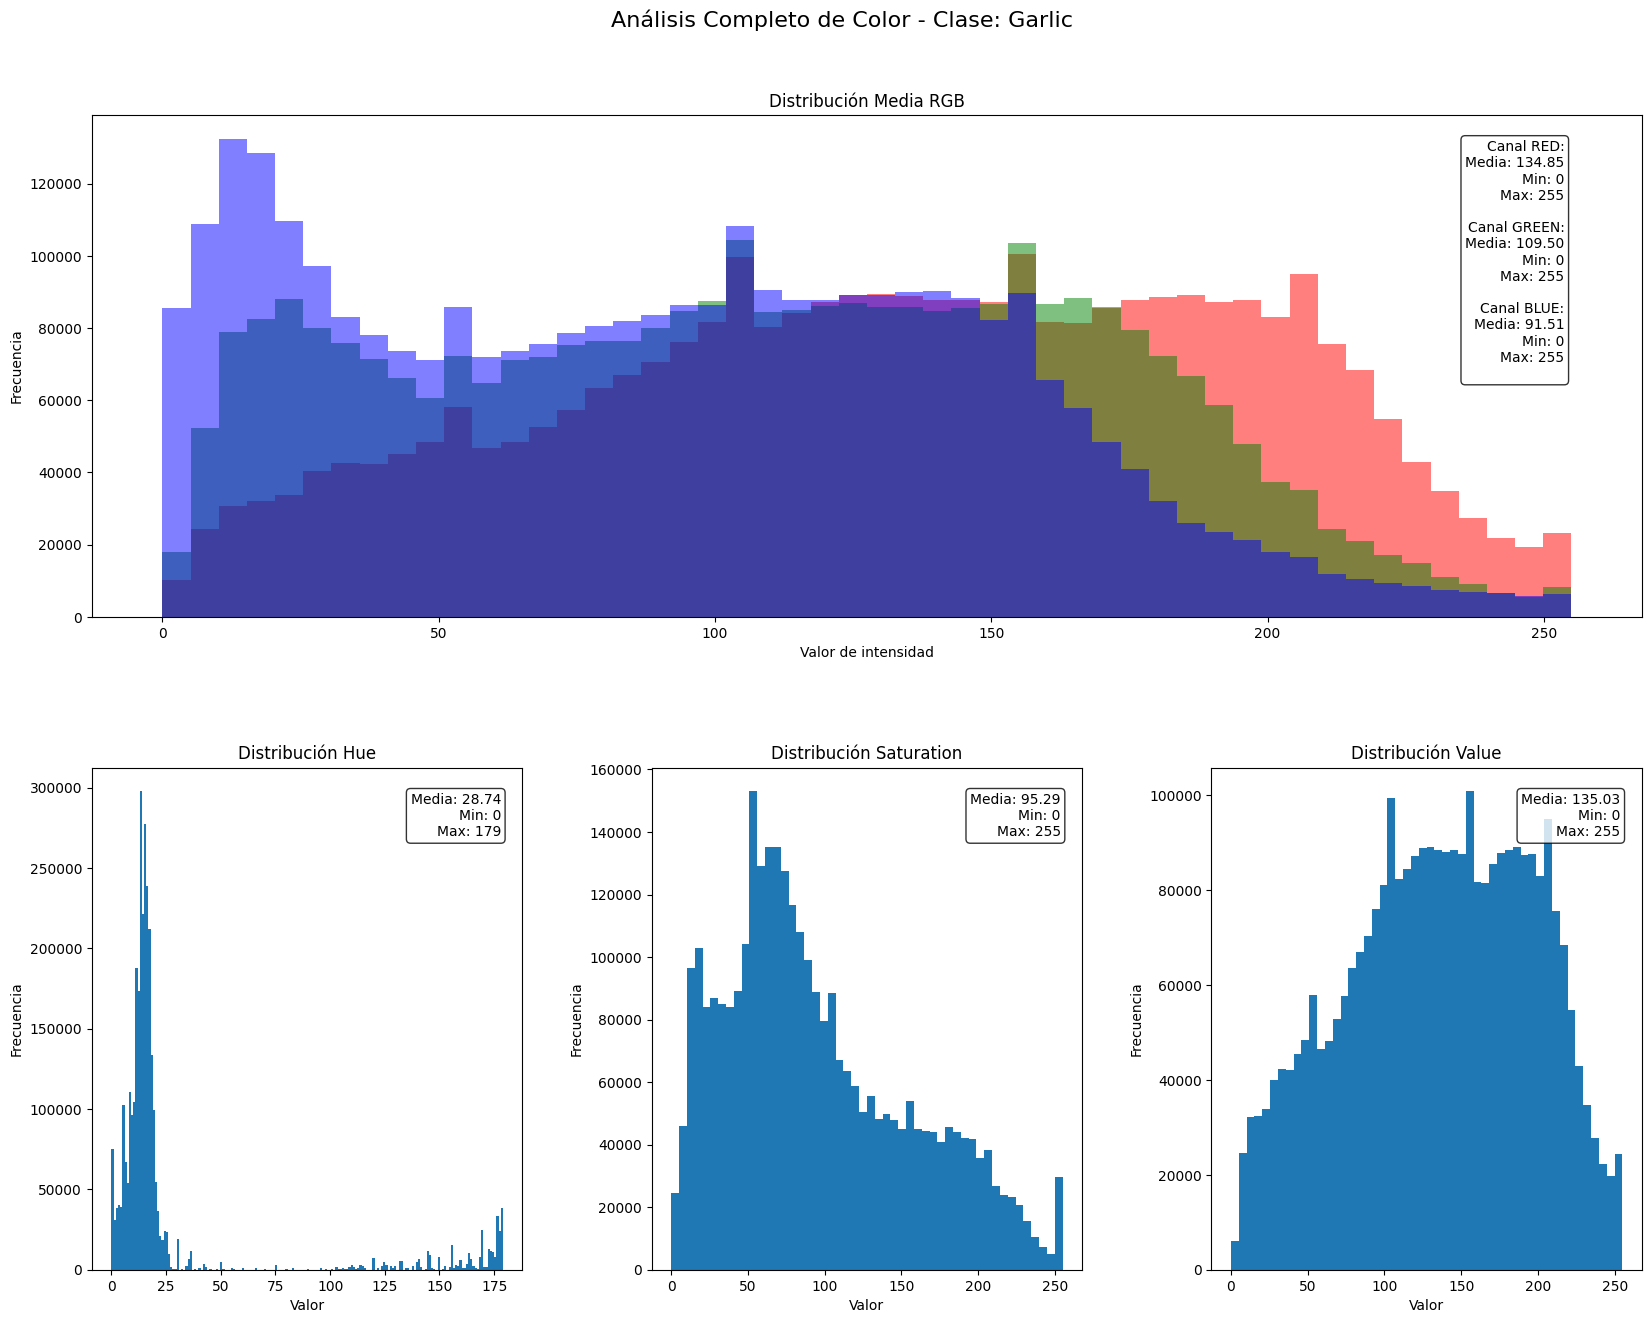

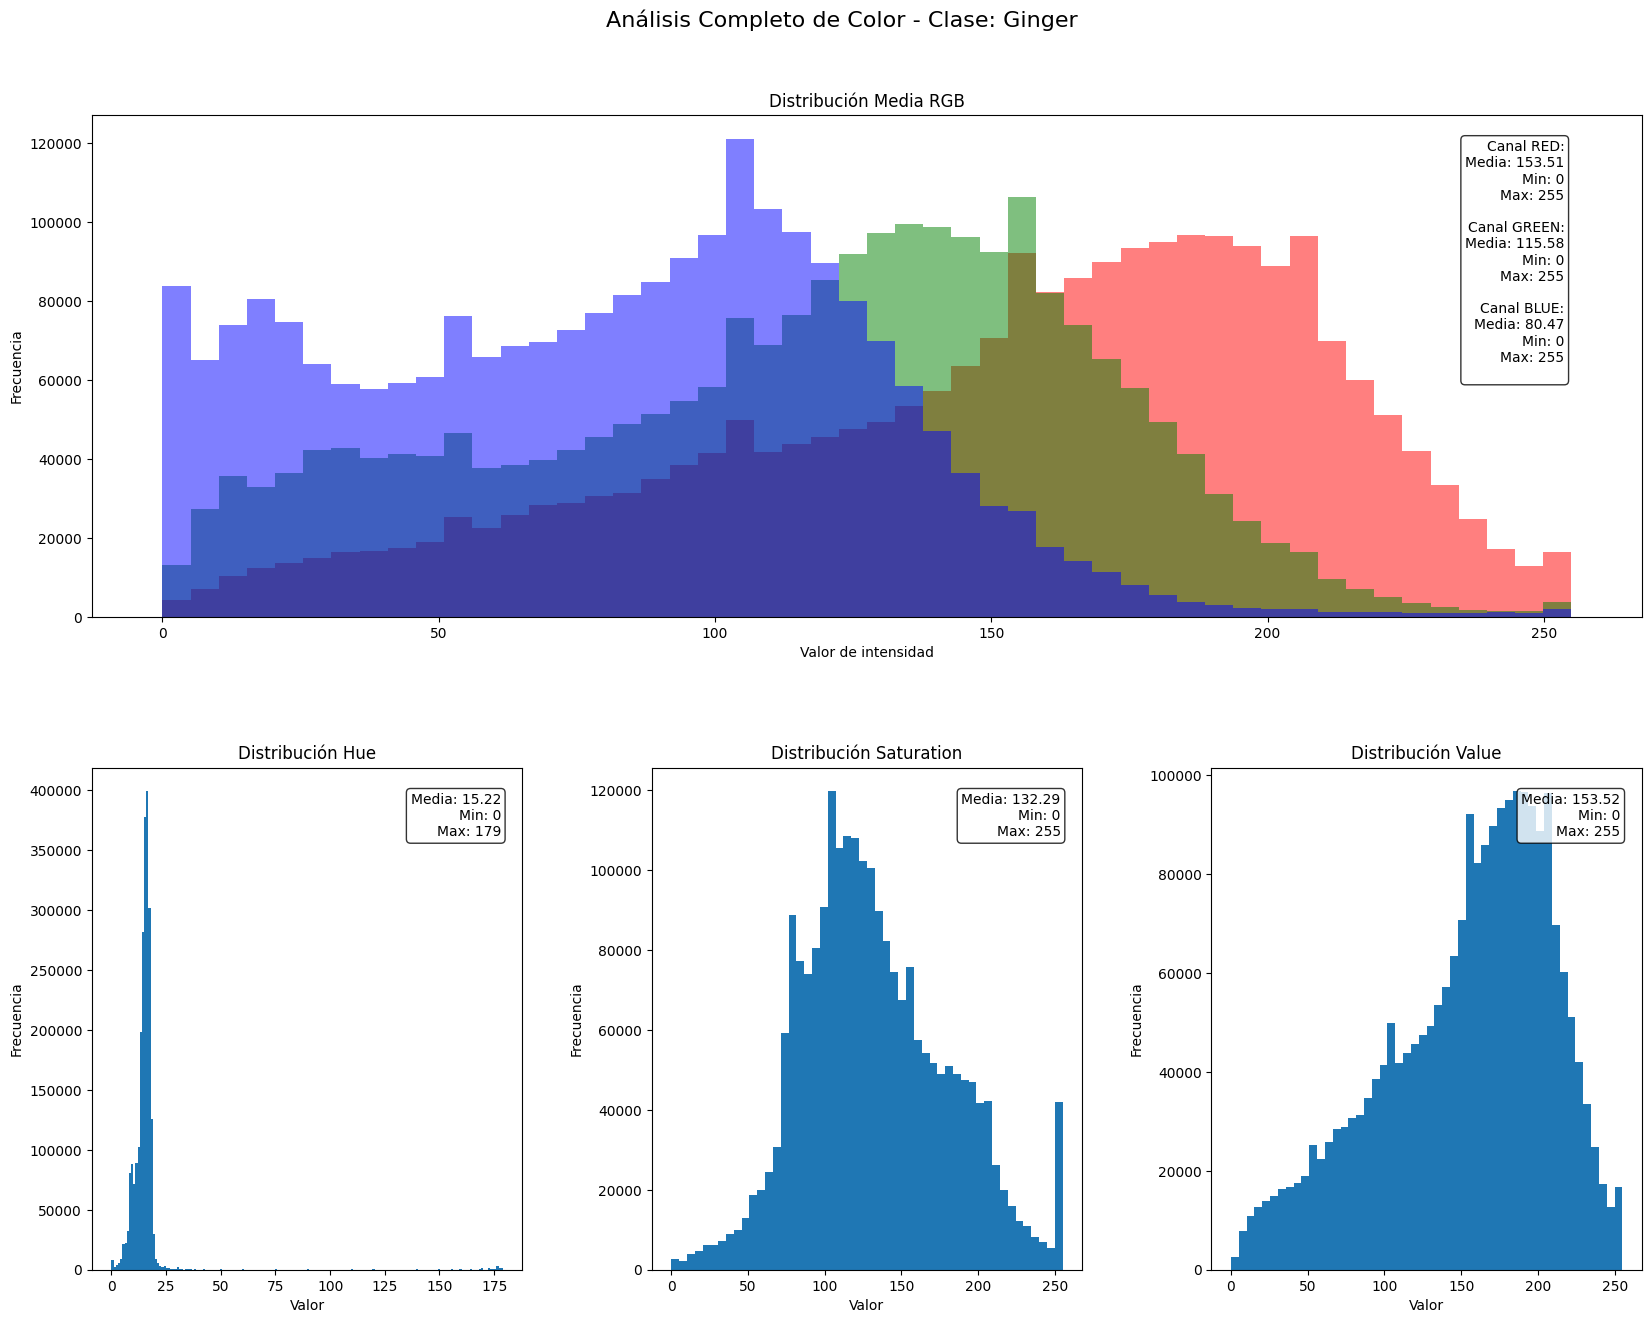

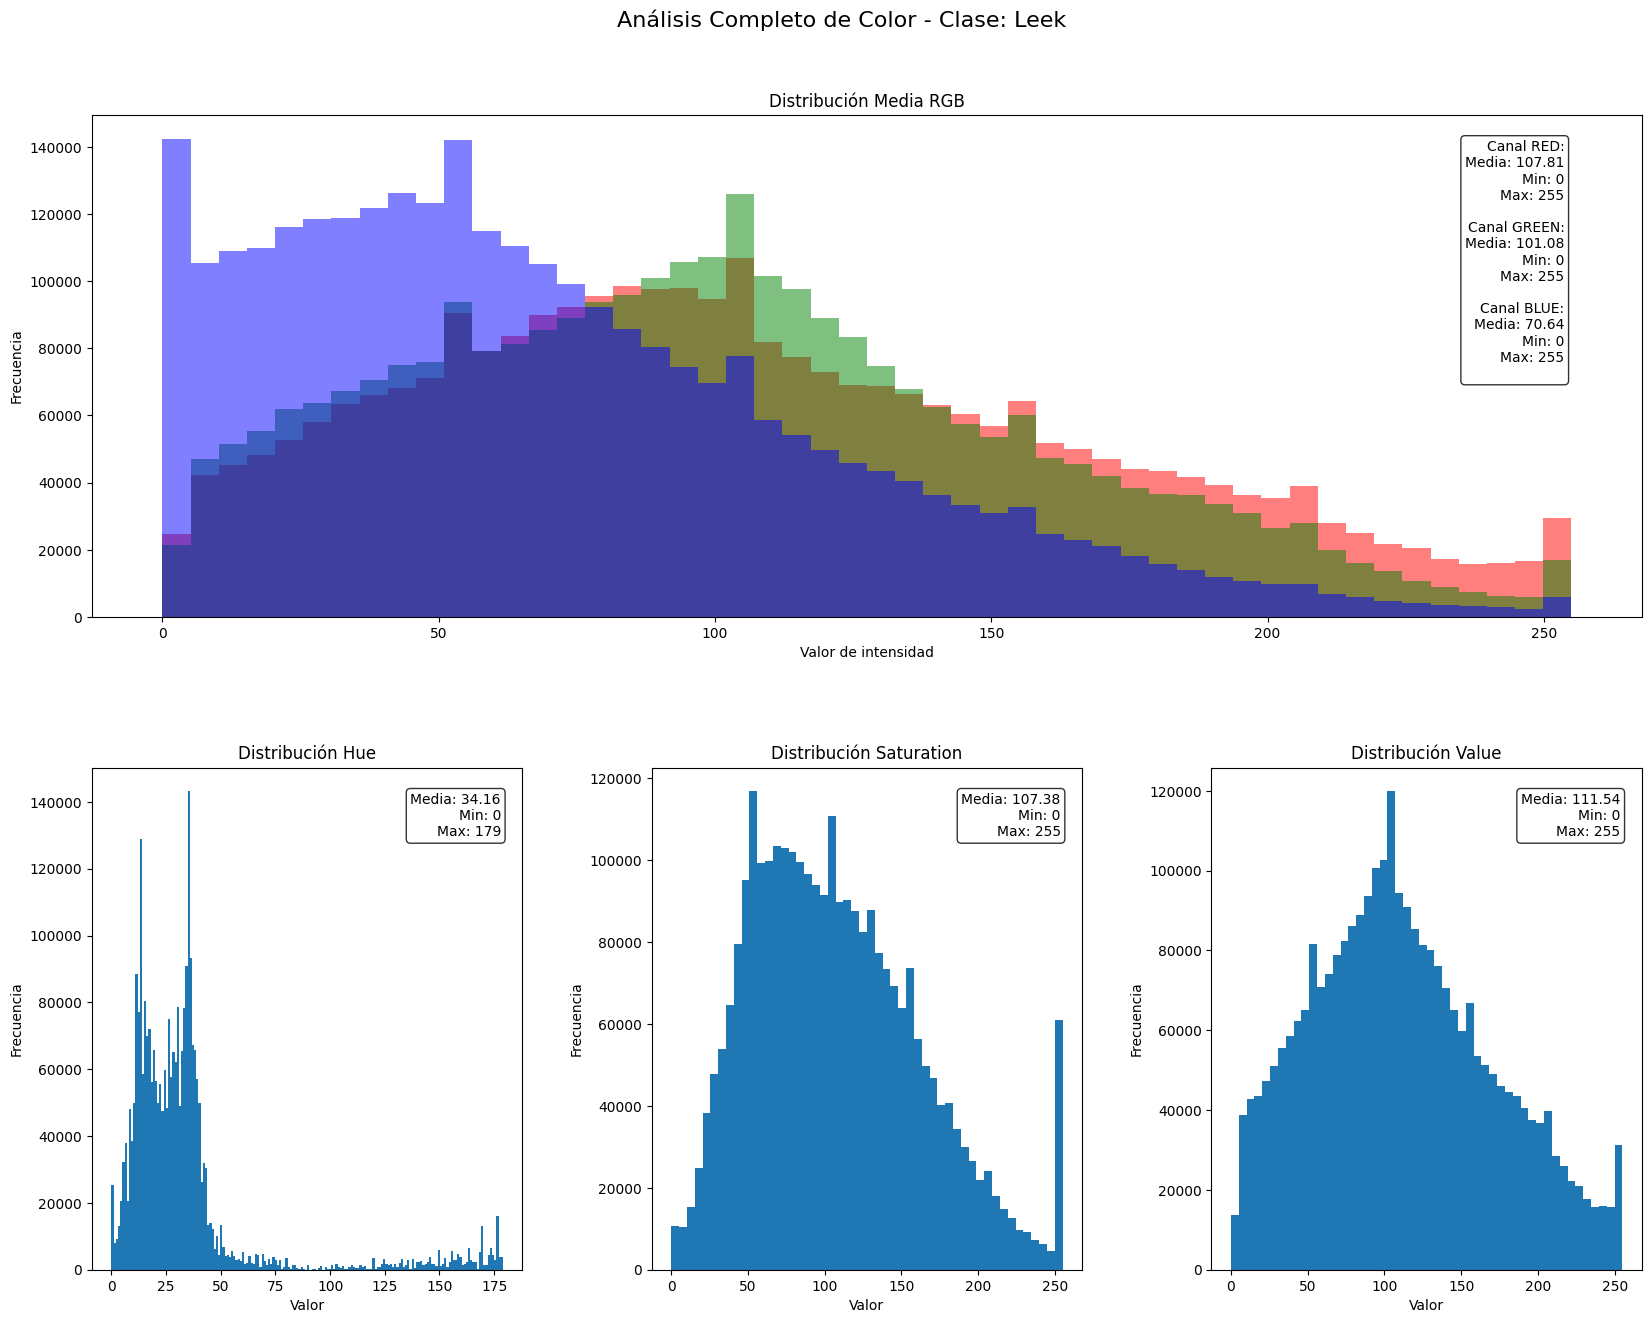

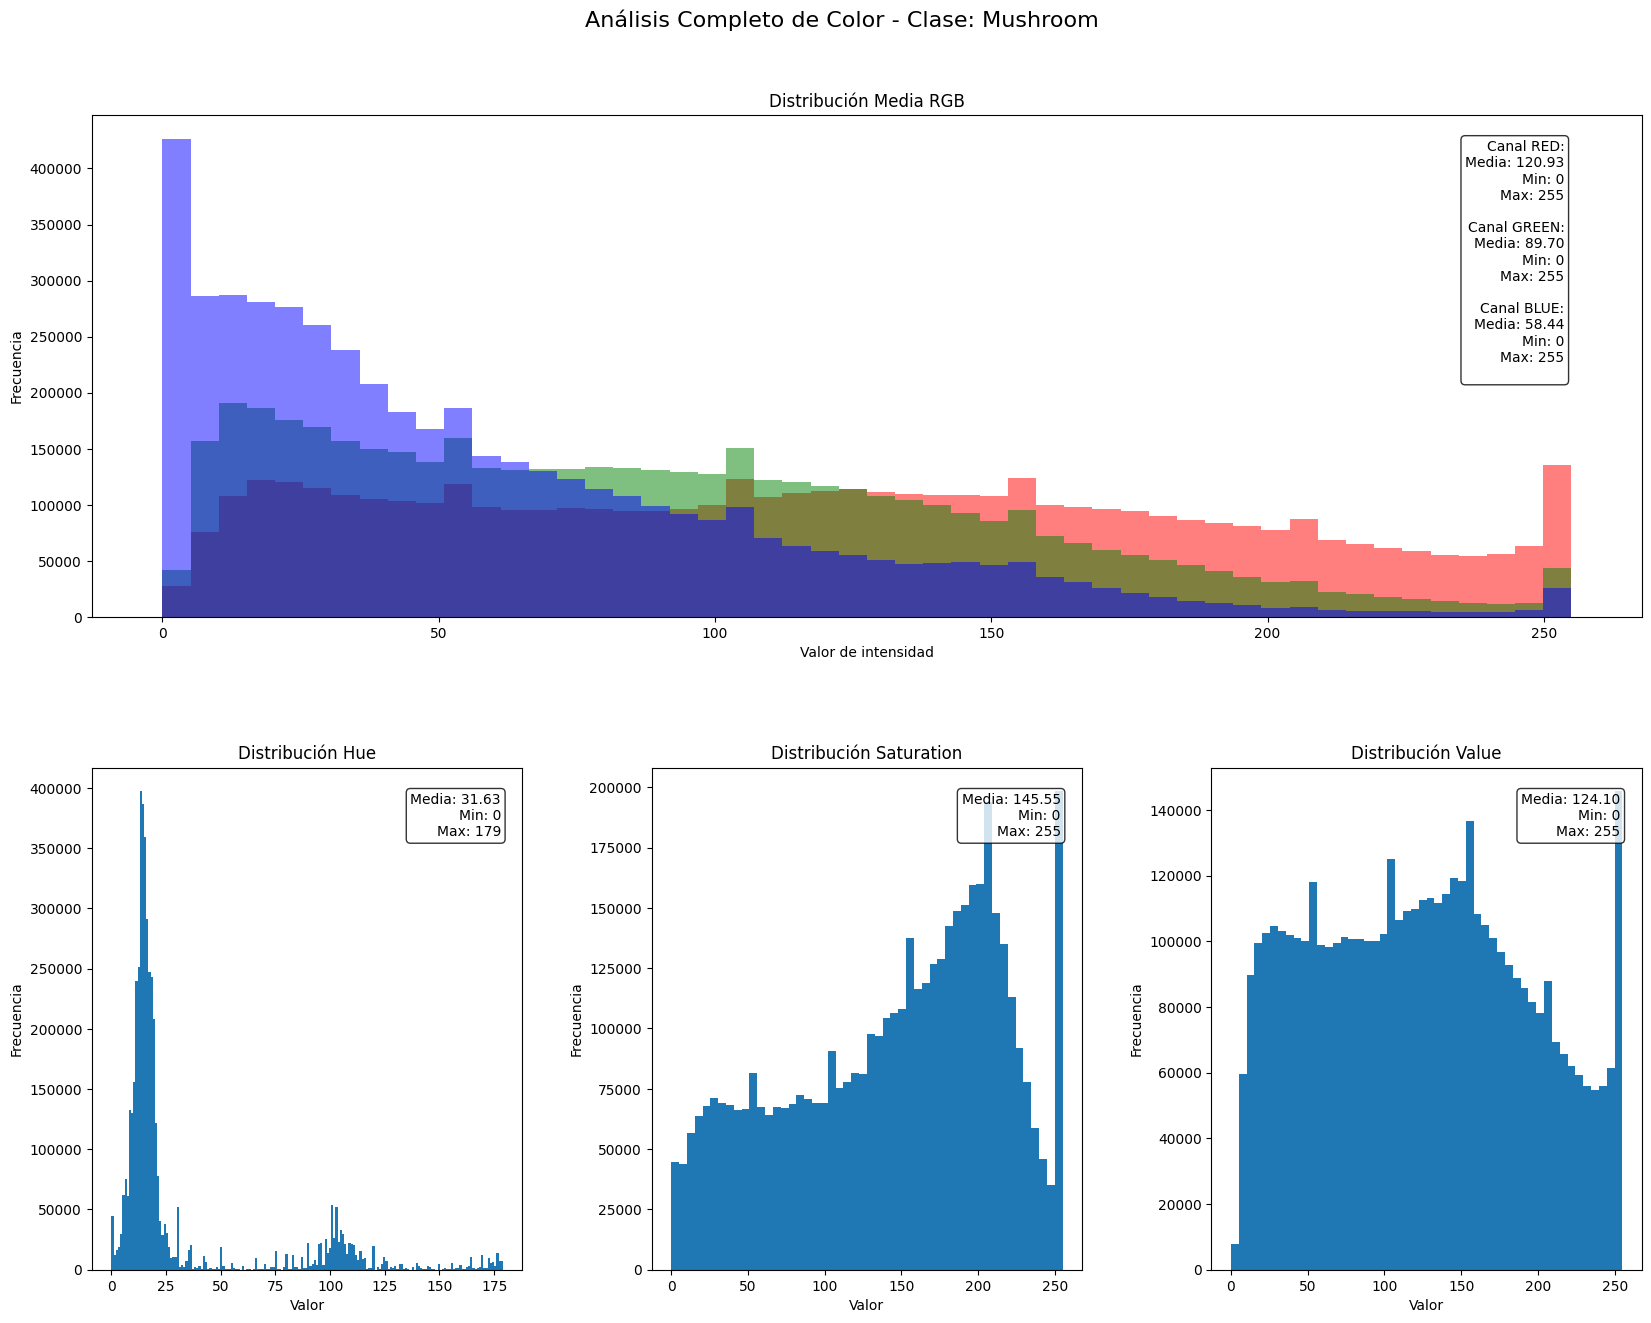

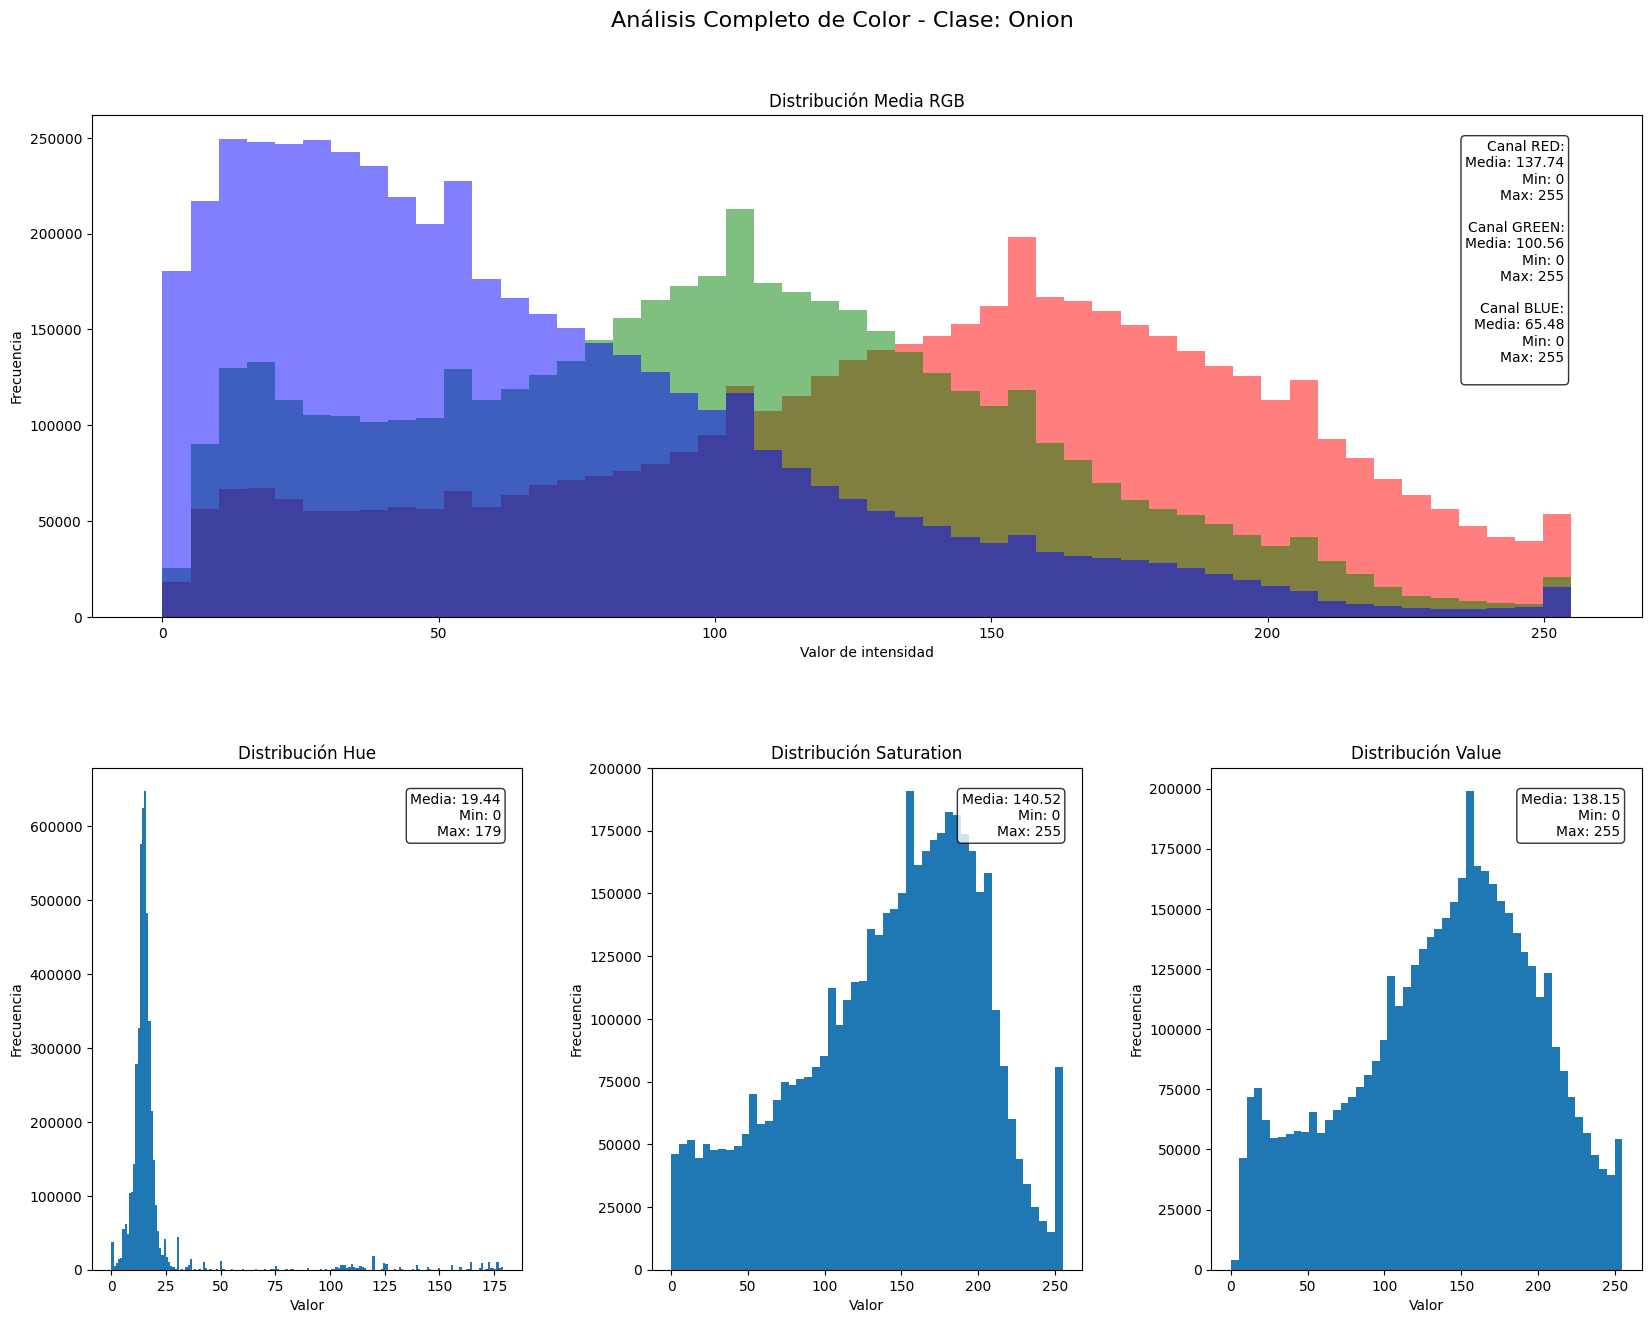

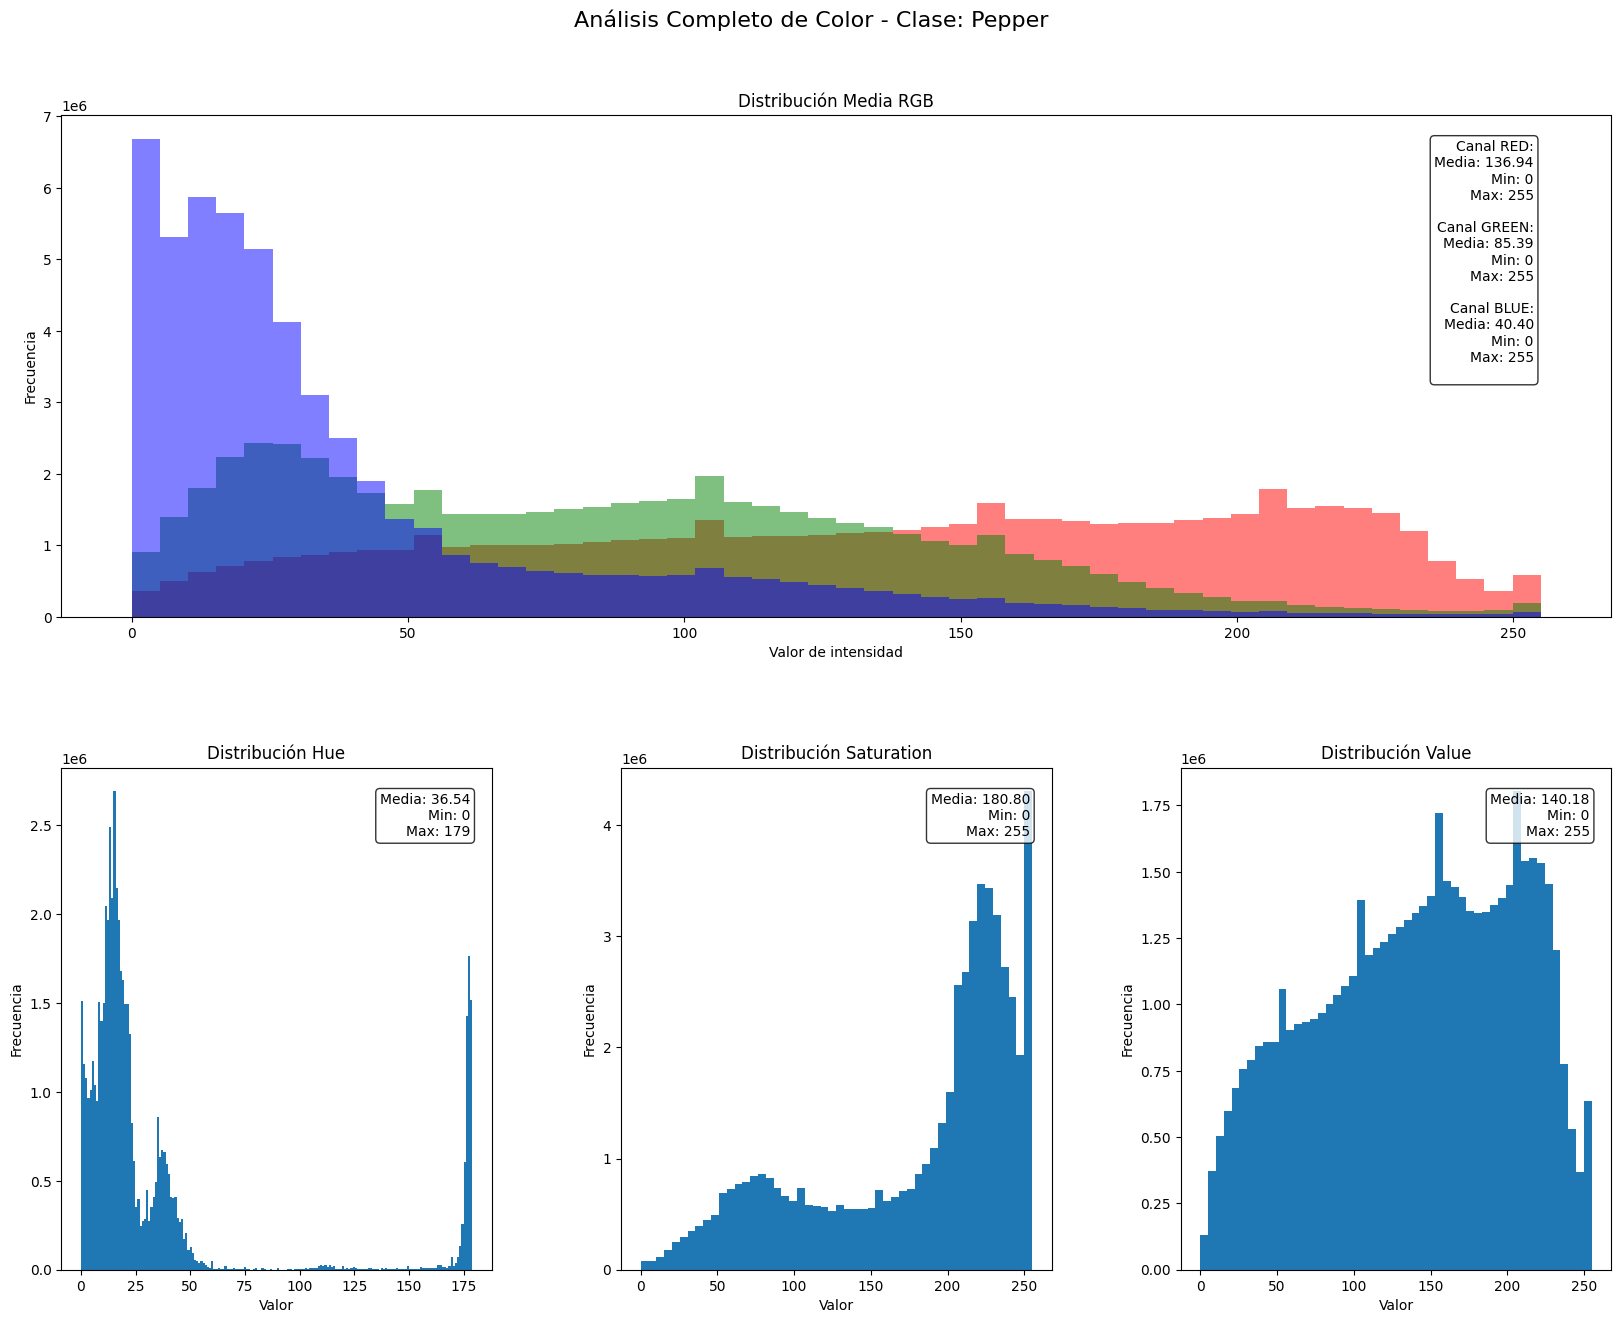

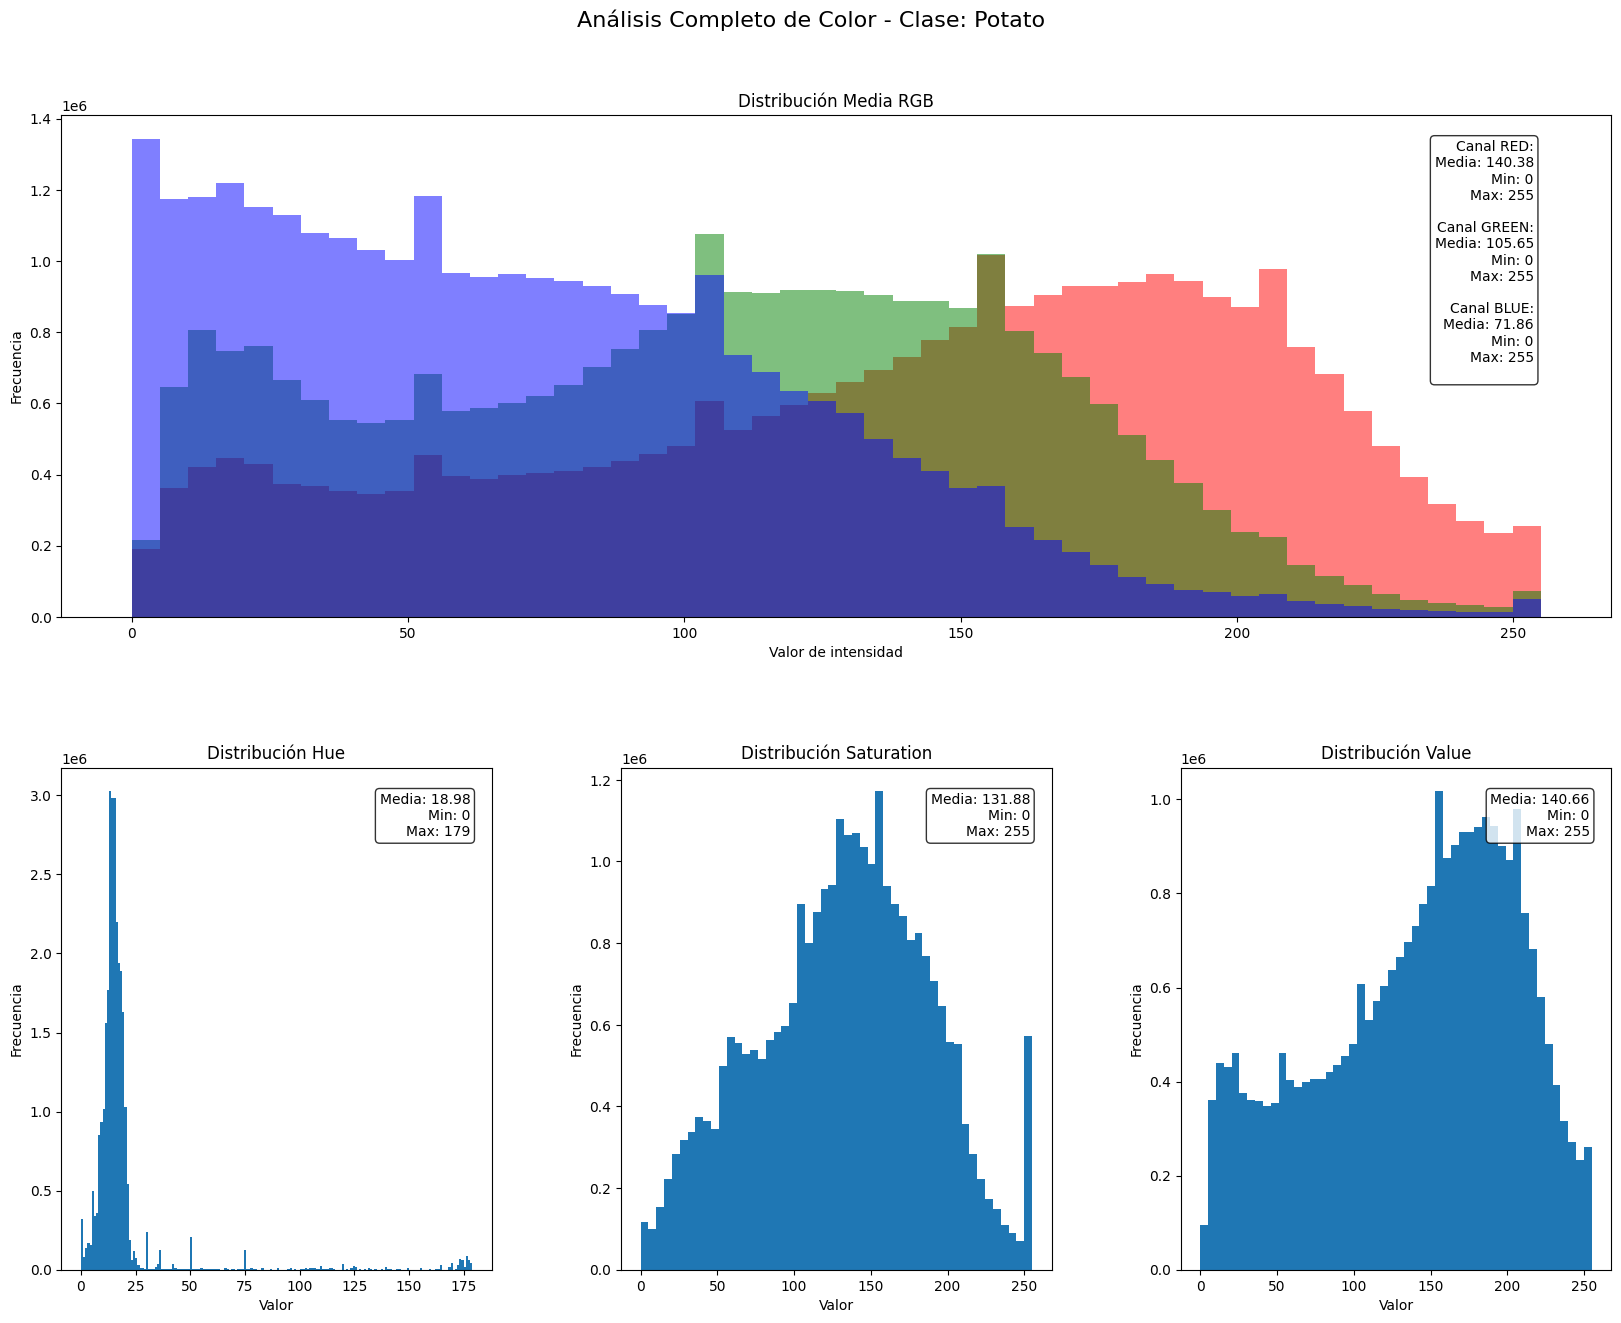

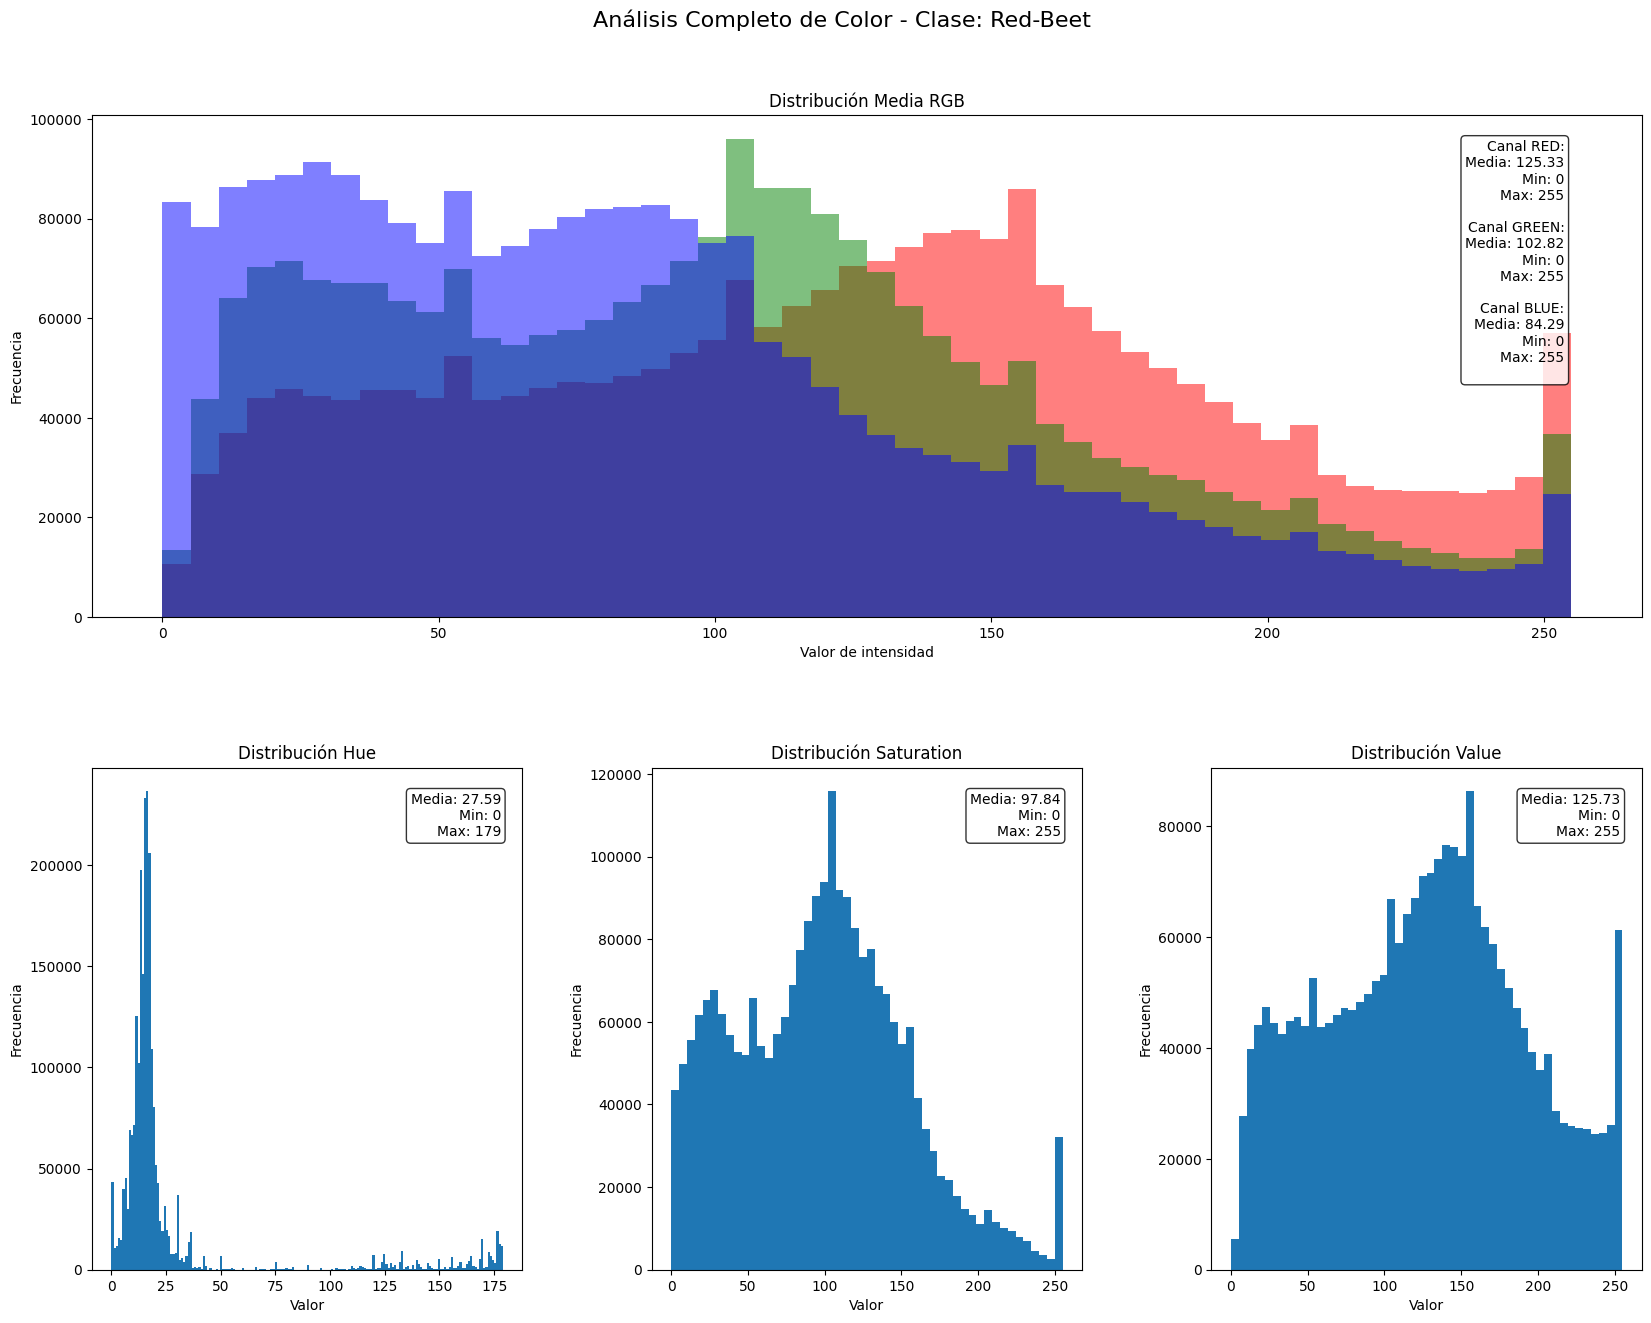

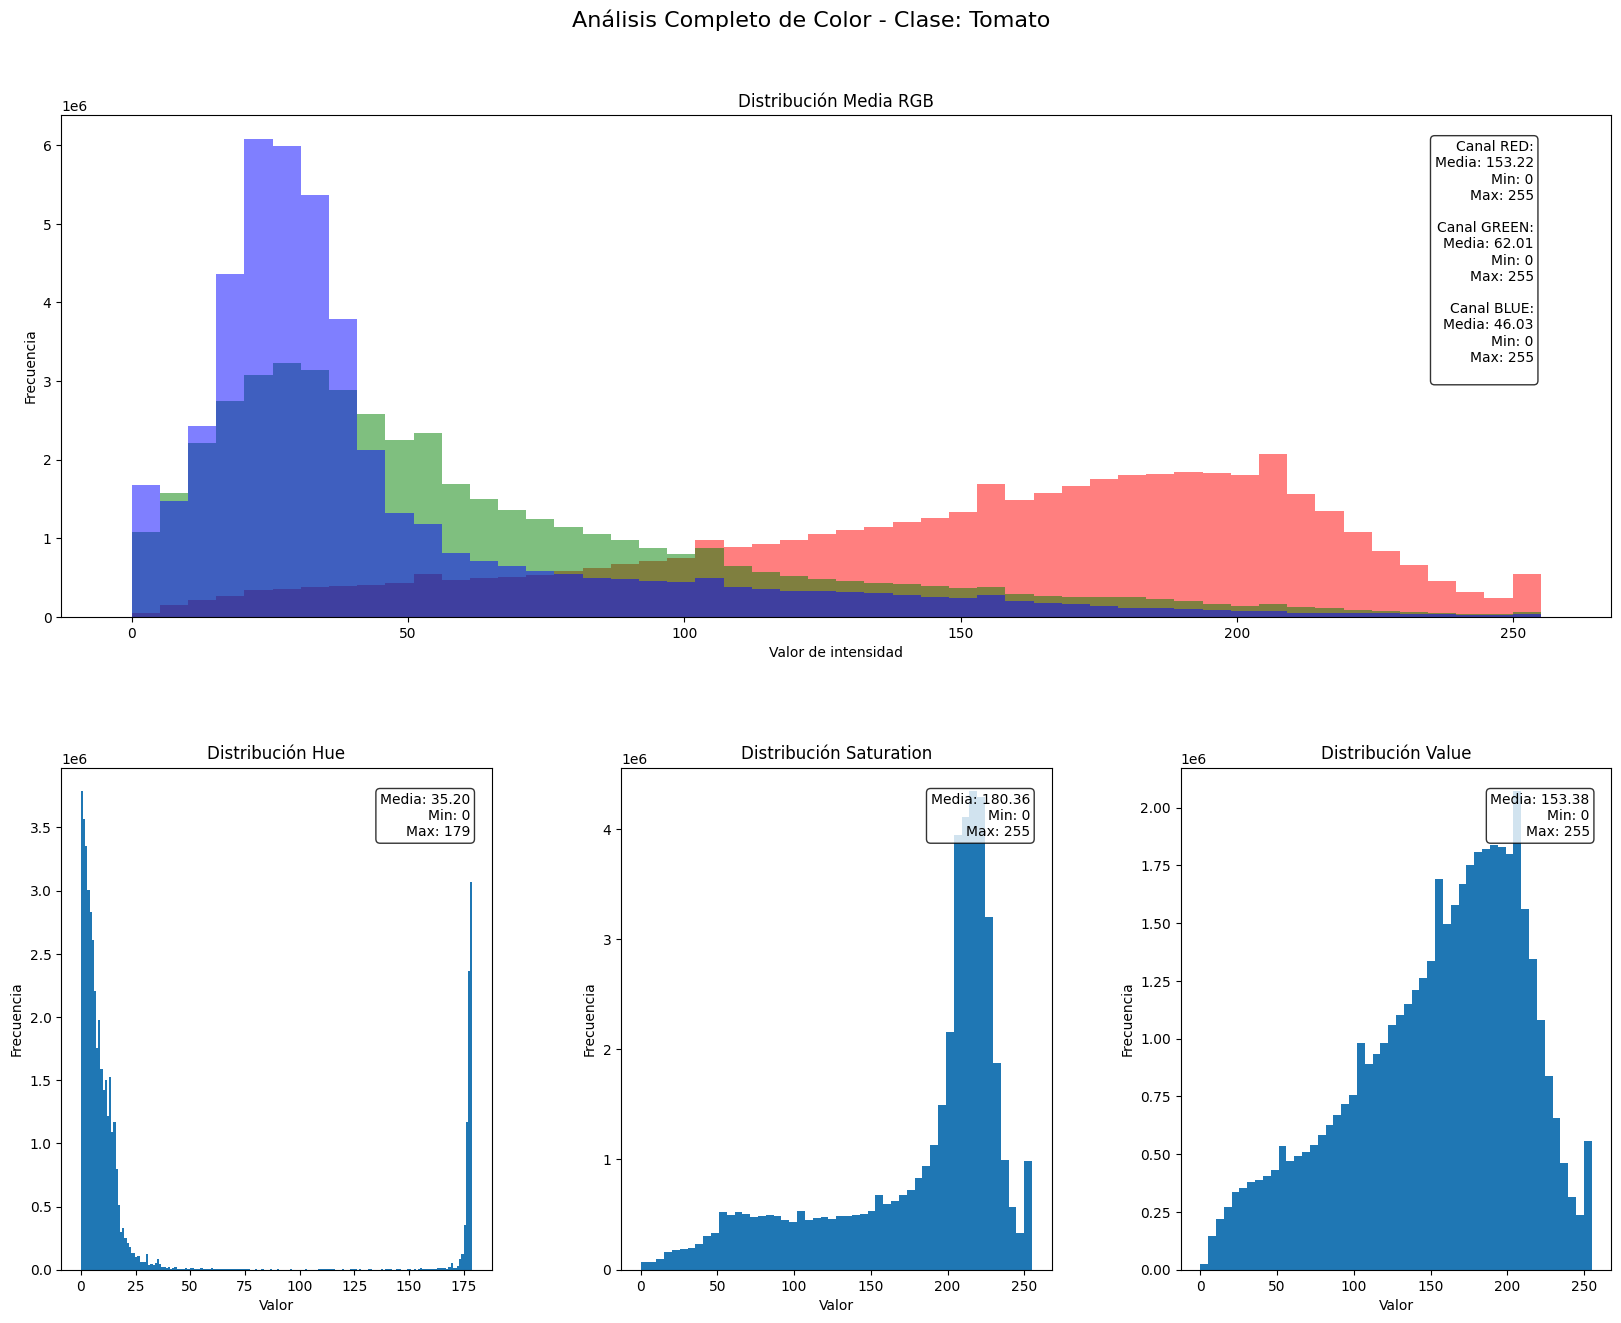

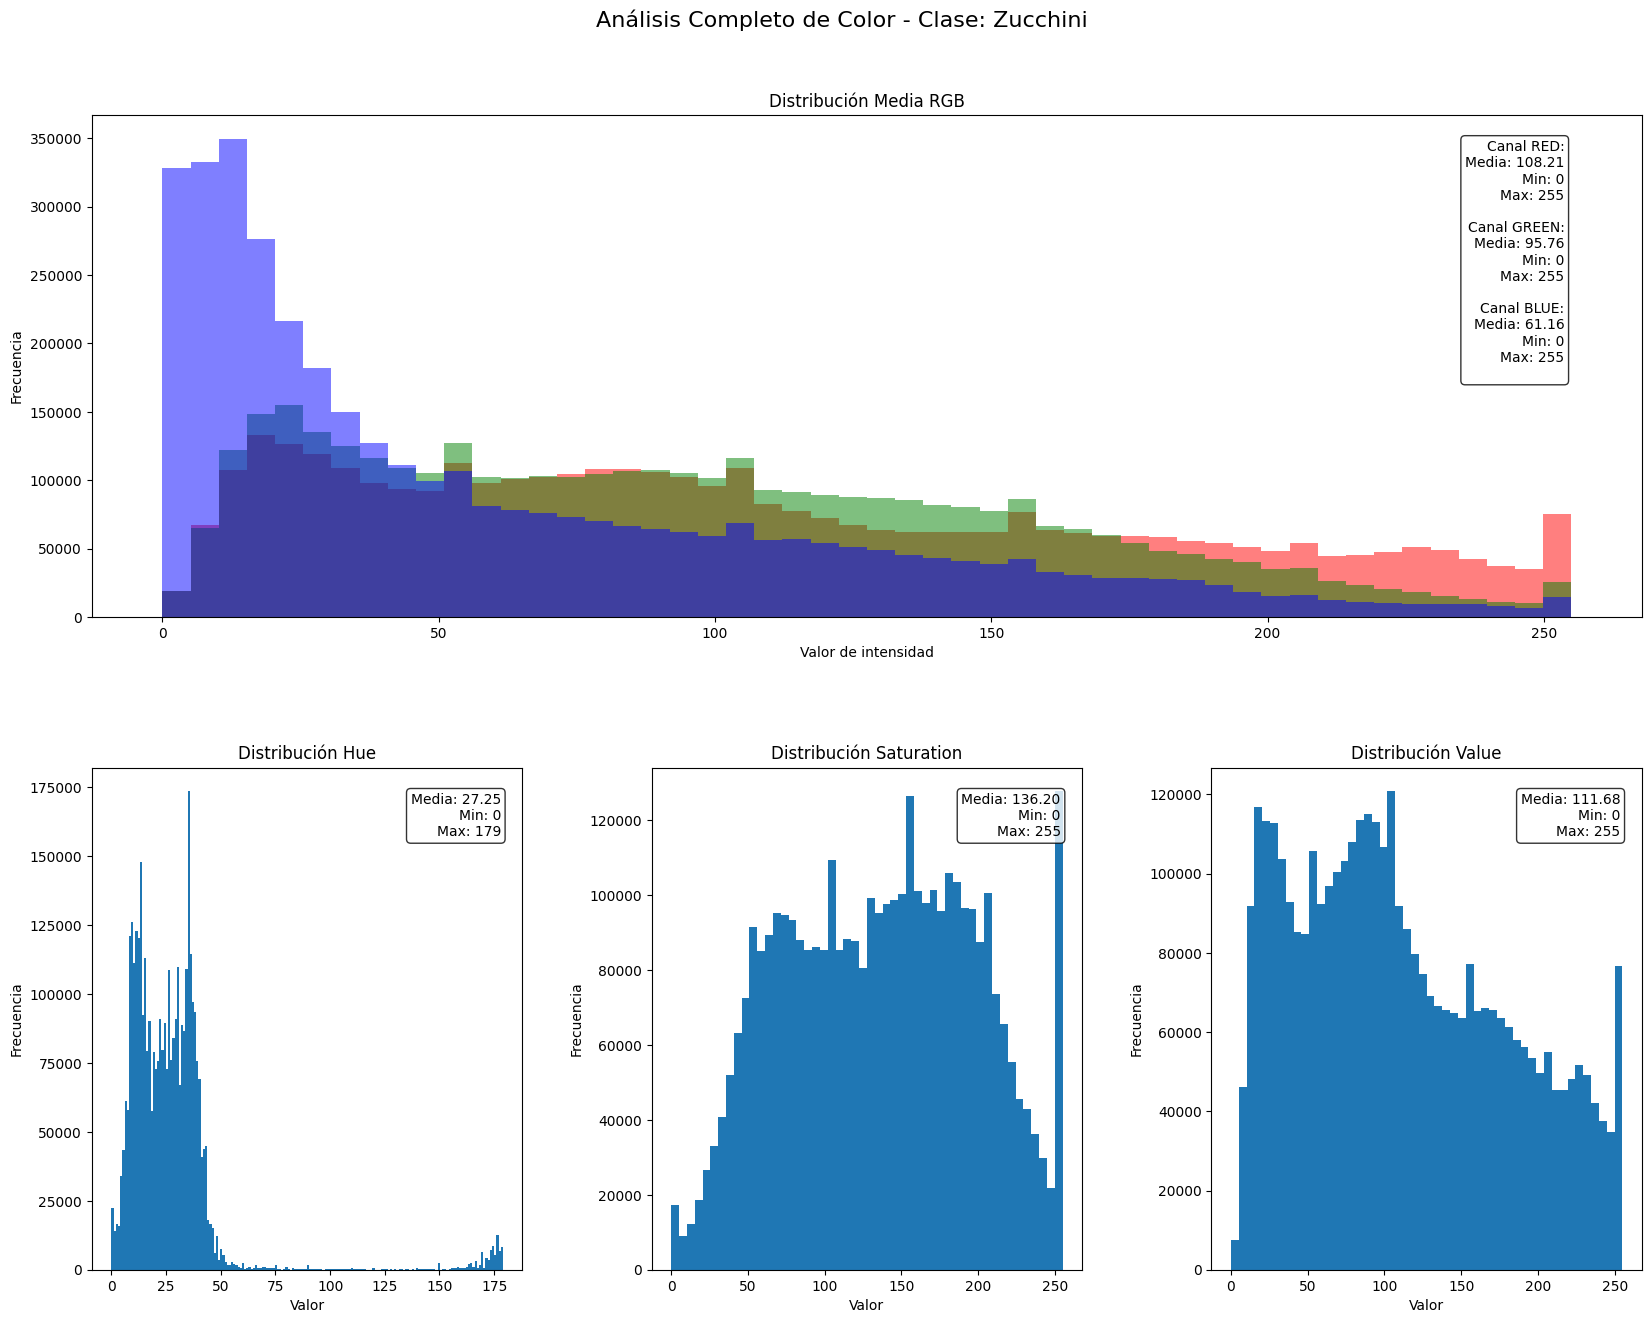

In [11]:
def analyze_color_distributions(df, class_name):
    class_images = df[df['Coarse Class Name'] == class_name]
    class_label = class_images["Coarse Class Name (str)"].iloc[0]
    
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # RGB analysis
    rgb_values = []
    rgb_stats = []
    for channel in range(3):
        values = np.concatenate([img[:,:,channel].ravel() for img in class_images['Image']])
        rgb_values.append(values)
        rgb_stats.append({
            'mean': np.mean(values),
            'min': np.min(values),
            'max': np.max(values)
        })
    
    # Plot RGB distribution with stats
    colors = ['red', 'green', 'blue']
    ax = fig.add_subplot(gs[0, :])
    for channel, color in enumerate(colors):
        plt.hist(rgb_values[channel], bins=50, alpha=0.5, color=color, label=f'Canal {color}')
    
    # Crear el texto de estadísticas de forma más simple
    stats_lines = []
    for color, stats in zip(colors, rgb_stats):
        stats_lines.append(f"Canal {color.upper()}:")
        stats_lines.append(f"Media: {stats['mean']:.2f}")
        stats_lines.append(f"Min: {stats['min']:.0f}")
        stats_lines.append(f"Max: {stats['max']:.0f}")
        stats_lines.append("")  # Línea en blanco entre canales
    
    stats_text = '\n'.join(stats_lines)
    
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
    ax.set_title('Distribución Media RGB')
    ax.set_xlabel('Valor de intensidad')
    ax.set_ylabel('Frecuencia')
    
    # Resto del código igual...
    hsv_values = []
    channel_names = ['Hue', 'Saturation', 'Value']
    for img in class_images['Image']:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv_values.append(hsv)
    
    for idx, (name, bins) in enumerate(zip(channel_names, [180, 50, 50])):
        ax = fig.add_subplot(gs[1, idx])
        values = np.concatenate([hsv[:,:,idx].ravel() for hsv in hsv_values])
        ax.hist(values, bins=bins)
        ax.set_title(f'Distribución {name}')
        ax.set_xlabel('Valor')
        ax.set_ylabel('Frecuencia')
        
        stats_text = f'Media: {np.mean(values):.2f}\nMin: {np.min(values)}\nMax: {np.max(values)}'
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle(f'Análisis Completo de Color - Clase: {class_label}', fontsize=16, y=0.95)
    plt.show()

for class_name in train_merged['Coarse Class Name'].unique():
    analyze_color_distributions(train_merged, class_name)

### **2-Entrenamiento del modelo de Machine Learning (20%)**

In [ ]:
class FruitDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row['Image']
        label = row['Coarse Class ID (int)']

        if self.transform:
            img = self.transform(img)

        return img, label
    


class FruitDatasetComplete(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row['Image']
        label = row['Class ID (int)']

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
transforms_dict = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val_test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
}

train_dataset = FruitDataset(train_merged, transform=transforms_dict['train'])
test_dataset = FruitDataset(test_merged, transform=transforms_dict['val_test'])
val_dataset = FruitDataset(val_merged, transform=transforms_dict['val_test'])

train_dataset_complete = FruitDatasetComplete(train_merged, transform=transforms_dict['train'])
test_dataset_complete = FruitDatasetComplete(test_merged, transform=transforms_dict['val_test'])
val_dataset_complete = FruitDatasetComplete(val_merged, transform=transforms_dict['val_test'])

In [ ]:
batch_size = 32
num_workers = 4  
###############################################################
# Coarse class
###############################################################

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True  
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

###############################################################
# Complete class
###############################################################

train_loader_complete = DataLoader(
    train_dataset_complete, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True  
)

val_loader_complete = DataLoader(
    val_dataset_complete, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader_complete = DataLoader(
    test_dataset_complete, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

In [15]:
def get_model(model_name, num_classes, pretrained=True):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
    return model

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
num_classes = len(train_dataset.df['Coarse Class ID (int)'].unique())
model_1 = get_model('resnet18', num_classes=num_classes)
model_2 = get_model('resnet50', num_classes=num_classes)
model_3 = get_model('mobilenet_v2', num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)

Using device: cuda


/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weigh

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', model_name='model'):
    model = model.to(device)
    best_val_acc = 0.0
    
    # Diccionarios para guardar el historial de métricas
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'best_epoch': 0,
        'best_val_acc': 0.0,
        'final_val_acc': 0.0,
        'final_train_acc': 0.0
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{running_loss/train_total:.4f}',
                'acc': f'{100 * train_correct/train_total:.2f}%'
            })
        
        train_acc = 100 * train_correct / train_total
        train_loss = running_loss/train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({
                    'loss': f'{val_loss/val_total:.4f}',
                    'acc': f'{100 * val_correct/val_total:.2f}%'
                })
        
        val_acc = 100 * val_correct / val_total
        val_loss = val_loss/val_total
        
        # Guardar métricas del epoch actual
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch statistics
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            history['best_val_acc'] = val_acc
            history['best_epoch'] = epoch + 1
            torch.save(model.state_dict(), f'best_model_{model_name}.pth')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
        
        print('-' * 60)
    
    # Guardar métricas finales
    history['final_train_acc'] = train_acc
    history['final_val_acc'] = val_acc
    
    return history

In [18]:
def test_model(model, test_loader, criterion, device='cuda'):
    # Asegurarse de que el modelo esté en el dispositivo correcto
    model = model.to(device)
    model.eval()
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    all_predictions = []
    all_labels = []
    
    # Para calcular métricas durante el proceso
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    batch_count = 0
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing')
        
        for inputs, labels in test_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            # Convertir a CPU para métricas
            batch_preds = predicted.cpu().numpy()
            batch_labels = labels.cpu().numpy()
            
            # Calcular métricas por batch
            batch_f1 = f1_score(batch_labels, batch_preds, average='weighted', zero_division=0)
            batch_precision = precision_score(batch_labels, batch_preds, average='weighted', zero_division=0)
            batch_recall = recall_score(batch_labels, batch_preds, average='weighted', zero_division=0)
            
            # Actualizar promedios
            running_f1 += batch_f1
            running_precision += batch_precision
            running_recall += batch_recall
            batch_count += 1
            
            # Guardar predicciones y etiquetas
            all_predictions.extend(batch_preds)
            all_labels.extend(batch_labels)
            
            # Actualizar barra de progreso con todas las métricas
            test_pbar.set_postfix({
                'loss': f'{test_loss/test_total:.4f}',
                'acc': f'{100 * test_correct/test_total:.2f}%',
                'f1': f'{100 * running_f1/batch_count:.2f}%',
                'prec': f'{100 * running_precision/batch_count:.2f}%',
                'rec': f'{100 * running_recall/batch_count:.2f}%'
            })
    
    # Calcular métricas finales sobre todo el conjunto
    test_acc = 100 * test_correct / test_total
    final_f1 = 100 * f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    final_precision = 100 * precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    final_recall = 100 * recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    # Imprimir resultados finales
    print(f'\nTest Results:')
    print(f'Loss: {test_loss/test_total:.4f}')
    print(f'Accuracy: {test_acc:.2f}%')
    print(f'F1-Score: {final_f1:.2f}%')
    print(f'Precision: {final_precision:.2f}%')
    print(f'Recall: {final_recall:.2f}%')
    
    # Crear diccionario con todas las métricas
    metrics = {
        'loss': test_loss/test_total,
        'accuracy': test_acc,
        'f1_score': final_f1,
        'precision': final_precision,
        'recall': final_recall,
        'predictions': all_predictions,
        'true_labels': all_labels
    }
    
    return metrics

#### **2.1-Entrenamiento del modelo con números de clases de coarse**

In [27]:
#####################################
# Entrenamiento model1
#####################################
history_m1 = train_model(
    model=model_1,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_1,
    num_epochs=10,
    device=device,
    model_name='resnet18'
)

Epoch 1/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 30.84it/s, loss=0.0338, acc=78.98%]



Epoch 1/10:
Train Loss: 0.0011, Train Acc: 98.92%
Val Loss: 0.0338, Val Acc: 78.98%
New best model saved with validation accuracy: 78.98%
------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 32.53it/s, loss=0.0209, acc=85.85%]



Epoch 2/10:
Train Loss: 0.0026, Train Acc: 97.84%
Val Loss: 0.0209, Val Acc: 85.85%
New best model saved with validation accuracy: 85.85%
------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 31.46it/s, loss=0.0137, acc=90.28%]



Epoch 3/10:
Train Loss: 0.0007, Train Acc: 99.36%
Val Loss: 0.0137, Val Acc: 90.28%
New best model saved with validation accuracy: 90.28%
------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 31.55it/s, loss=0.0284, acc=83.51%]



Epoch 4/10:
Train Loss: 0.0012, Train Acc: 98.99%
Val Loss: 0.0284, Val Acc: 83.51%
------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 30.59it/s, loss=0.0180, acc=86.90%]



Epoch 5/10:
Train Loss: 0.0027, Train Acc: 97.85%
Val Loss: 0.0180, Val Acc: 86.90%
------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 31.13it/s, loss=0.0164, acc=88.90%]



Epoch 6/10:
Train Loss: 0.0005, Train Acc: 99.54%
Val Loss: 0.0164, Val Acc: 88.90%
------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 30.79it/s, loss=0.0159, acc=89.12%]



Epoch 7/10:
Train Loss: 0.0001, Train Acc: 99.94%
Val Loss: 0.0159, Val Acc: 89.12%
------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 30.93it/s, loss=0.0238, acc=84.27%]



Epoch 8/10:
Train Loss: 0.0017, Train Acc: 98.59%
Val Loss: 0.0238, Val Acc: 84.27%
------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 273/273 [00:08<00:00, 32.22it/s, loss=0.0167, acc=87.80%]



Epoch 9/10:
Train Loss: 0.0009, Train Acc: 99.25%
Val Loss: 0.0167, Val Acc: 87.80%
------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 273/273 [00:09<00:00, 30.14it/s, loss=0.0183, acc=86.94%]


Epoch 10/10:
Train Loss: 0.0011, Train Acc: 98.96%
Val Loss: 0.0183, Val Acc: 86.94%
------------------------------------------------------------


In [28]:
#####################################
# Entrenamiento model2
#####################################
history_m2 = train_model(
    model=model_2,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_2,
    num_epochs=10,
    device=device,
    model_name='resnet50'
)

Epoch 1/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.15it/s, loss=0.0194, acc=84.42%]



Epoch 1/10:
Train Loss: 0.0019, Train Acc: 98.32%
Val Loss: 0.0194, Val Acc: 84.42%
New best model saved with validation accuracy: 84.42%
------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.02it/s, loss=0.0175, acc=86.18%]



Epoch 2/10:
Train Loss: 0.0028, Train Acc: 97.39%
Val Loss: 0.0175, Val Acc: 86.18%
New best model saved with validation accuracy: 86.18%
------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.10it/s, loss=0.0162, acc=86.91%]



Epoch 3/10:
Train Loss: 0.0010, Train Acc: 99.12%
Val Loss: 0.0162, Val Acc: 86.91%
New best model saved with validation accuracy: 86.91%
------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.09it/s, loss=0.0166, acc=87.42%]



Epoch 4/10:
Train Loss: 0.0015, Train Acc: 98.51%
Val Loss: 0.0166, Val Acc: 87.42%
New best model saved with validation accuracy: 87.42%
------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.13it/s, loss=0.0183, acc=86.47%]



Epoch 5/10:
Train Loss: 0.0016, Train Acc: 98.56%
Val Loss: 0.0183, Val Acc: 86.47%
------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.15it/s, loss=0.0142, acc=89.99%]



Epoch 6/10:
Train Loss: 0.0007, Train Acc: 99.37%
Val Loss: 0.0142, Val Acc: 89.99%
New best model saved with validation accuracy: 89.99%
------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.07it/s, loss=0.0144, acc=88.92%]



Epoch 7/10:
Train Loss: 0.0004, Train Acc: 99.74%
Val Loss: 0.0144, Val Acc: 88.92%
------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.11it/s, loss=0.0233, acc=86.26%]



Epoch 8/10:
Train Loss: 0.0011, Train Acc: 98.99%
Val Loss: 0.0233, Val Acc: 86.26%
------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.09it/s, loss=0.0198, acc=86.92%]



Epoch 9/10:
Train Loss: 0.0025, Train Acc: 97.91%
Val Loss: 0.0198, Val Acc: 86.92%
------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.04it/s, loss=0.0192, acc=86.52%]


Epoch 10/10:
Train Loss: 0.0008, Train Acc: 99.28%
Val Loss: 0.0192, Val Acc: 86.52%
------------------------------------------------------------


In [29]:
#####################################
# Entrenamiento model3
#####################################
history_m3 = train_model(
    model=model_3,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_3,
    num_epochs=10,
    device=device,
    model_name='mobilenet_v2'
)

Epoch 1/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.88it/s, loss=0.0132, acc=89.97%]



Epoch 1/10:
Train Loss: 0.0017, Train Acc: 98.29%
Val Loss: 0.0132, Val Acc: 89.97%
New best model saved with validation accuracy: 89.97%
------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.68it/s, loss=0.0123, acc=90.79%]



Epoch 2/10:
Train Loss: 0.0023, Train Acc: 98.31%
Val Loss: 0.0123, Val Acc: 90.79%
New best model saved with validation accuracy: 90.79%
------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.67it/s, loss=0.0127, acc=89.33%]



Epoch 3/10:
Train Loss: 0.0017, Train Acc: 98.35%
Val Loss: 0.0127, Val Acc: 89.33%
------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.33it/s, loss=0.0113, acc=91.10%]



Epoch 4/10:
Train Loss: 0.0016, Train Acc: 98.58%
Val Loss: 0.0113, Val Acc: 91.10%
New best model saved with validation accuracy: 91.10%
------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.96it/s, loss=0.0138, acc=90.53%]



Epoch 5/10:
Train Loss: 0.0009, Train Acc: 99.09%
Val Loss: 0.0138, Val Acc: 90.53%
------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.33it/s, loss=0.0212, acc=86.83%]



Epoch 6/10:
Train Loss: 0.0019, Train Acc: 98.08%
Val Loss: 0.0212, Val Acc: 86.83%
------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.77it/s, loss=0.0189, acc=89.98%]



Epoch 7/10:
Train Loss: 0.0016, Train Acc: 98.59%
Val Loss: 0.0189, Val Acc: 89.98%
------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.70it/s, loss=0.0122, acc=91.25%]



Epoch 8/10:
Train Loss: 0.0012, Train Acc: 98.96%
Val Loss: 0.0122, Val Acc: 91.25%
New best model saved with validation accuracy: 91.25%
------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 25.65it/s, loss=0.0265, acc=85.81%]



Epoch 9/10:
Train Loss: 0.0009, Train Acc: 99.39%
Val Loss: 0.0265, Val Acc: 85.81%
------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.24it/s, loss=0.0126, acc=89.97%]


Epoch 10/10:
Train Loss: 0.0033, Train Acc: 97.10%
Val Loss: 0.0126, Val Acc: 89.97%
------------------------------------------------------------


Ahora luego de haber entrenado los modelos es importante comparar en el set de validación cuál obtuvo mejor accuracy. Esto me muestra en la gráfica a continuación.

Mejor accuracy: 90.28% en epoch 3 para el modelo resnet18
Mejor accuracy: 89.99% en epoch 6 para el modelo resnet50
Mejor accuracy: 91.25% en epoch 8 para el modelo mobilenet_v2


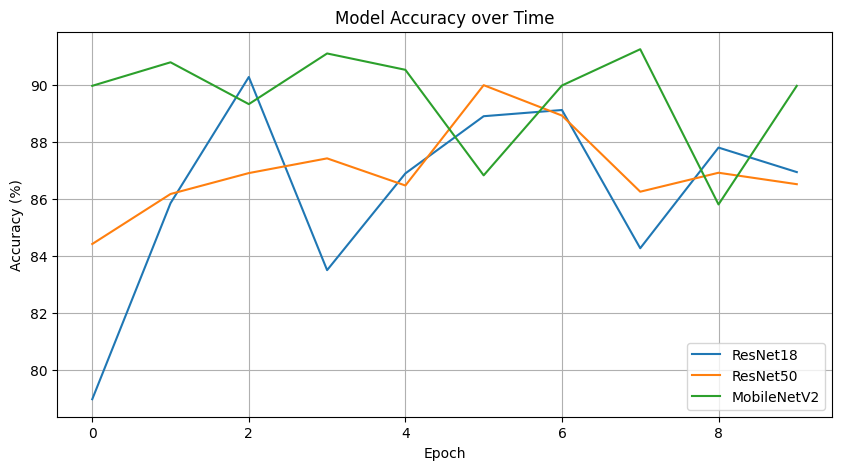

In [30]:
# Ver la mejor accuracy obtenida por los tres modelos
print(f"Mejor accuracy: {history_m1['best_val_acc']:.2f}% en epoch {history_m1['best_epoch']} para el modelo resnet18")
print(f"Mejor accuracy: {history_m2['best_val_acc']:.2f}% en epoch {history_m2['best_epoch']} para el modelo resnet50")
print(f"Mejor accuracy: {history_m3['best_val_acc']:.2f}% en epoch {history_m3['best_epoch']} para el modelo mobilenet_v2")

# Ver la accuracy final de los tres modelos
plt.figure(figsize=(10, 5))
plt.plot(history_m1['val_acc'], label='ResNet18')
plt.plot(history_m2['val_acc'], label='ResNet50')
plt.plot(history_m3['val_acc'], label='MobileNetV2')
plt.title('Model Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

#### **2.2-Entrenamiento del modelo con números de clases complete**

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

num_classes_complete = len(train_dataset.df['Class ID (int)'].unique())
model_1_complete = get_model('resnet18', num_classes=num_classes_complete)
model_2_complete = get_model('resnet50', num_classes=num_classes_complete)
model_3_complete = get_model('mobilenet_v2', num_classes=num_classes_complete)
criterion = nn.CrossEntropyLoss()
optimizer_1_complete = optim.Adam(model_1_complete.parameters(), lr=0.001)
optimizer_2_complete = optim.Adam(model_2_complete.parameters(), lr=0.001)
optimizer_3_complete = optim.Adam(model_3_complete.parameters(), lr=0.001)

Using device: cuda


/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weigh

In [97]:
#####################################
# Entrenamiento model1_complete
#####################################
history_m1_complete = train_model(
    model=model_1_complete,
    train_loader=train_loader_complete,
    val_loader=test_loader_complete,
    criterion=criterion,
    optimizer=optimizer_1_complete,
    num_epochs=10,
    device=device,
    model_name='resnet18_complete'
)

NameError: name 'train_loader_complete' is not defined

In [ ]:
#####################################
# Entrenamiento model2_complete
#####################################
history_m2_complete = train_model(
    model=model_2_complete,
    train_loader=train_loader_complete,
    val_loader=test_loader_complete,
    criterion=criterion,
    optimizer=optimizer_2_complete,
    num_epochs=10,
    device=device,
    model_name='resnet50_complete'
)

Epoch 1/10 [Train]:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.07it/s, loss=0.0206, acc=82.36%]



Epoch 1/10:
Train Loss: 0.0254, Train Acc: 79.47%
Val Loss: 0.0206, Val Acc: 82.36%
New best model saved with validation accuracy: 82.36%
------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.11it/s, loss=0.0213, acc=79.82%]



Epoch 2/10:
Train Loss: 0.0123, Train Acc: 88.71%
Val Loss: 0.0213, Val Acc: 79.82%
------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.03it/s, loss=0.0546, acc=59.86%]



Epoch 3/10:
Train Loss: 0.0076, Train Acc: 92.42%
Val Loss: 0.0546, Val Acc: 59.86%
------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.18it/s, loss=0.0183, acc=85.40%]



Epoch 4/10:
Train Loss: 0.0052, Train Acc: 94.90%
Val Loss: 0.0183, Val Acc: 85.40%
New best model saved with validation accuracy: 85.40%
------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.13it/s, loss=0.0313, acc=77.65%]



Epoch 5/10:
Train Loss: 0.0036, Train Acc: 96.50%
Val Loss: 0.0313, Val Acc: 77.65%
------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.10it/s, loss=0.0237, acc=82.09%]



Epoch 6/10:
Train Loss: 0.0040, Train Acc: 95.89%
Val Loss: 0.0237, Val Acc: 82.09%
------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.08it/s, loss=0.0373, acc=74.55%]



Epoch 7/10:
Train Loss: 0.0027, Train Acc: 97.25%
Val Loss: 0.0373, Val Acc: 74.55%
------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.11it/s, loss=0.0154, acc=86.99%]



Epoch 8/10:
Train Loss: 0.0027, Train Acc: 97.28%
Val Loss: 0.0154, Val Acc: 86.99%
New best model saved with validation accuracy: 86.99%
------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.14it/s, loss=0.0194, acc=84.46%]



Epoch 9/10:
Train Loss: 0.0014, Train Acc: 98.65%
Val Loss: 0.0194, Val Acc: 84.46%
------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 273/273 [00:20<00:00, 13.12it/s, loss=0.0192, acc=85.14%]


Epoch 10/10:
Train Loss: 0.0015, Train Acc: 98.65%
Val Loss: 0.0192, Val Acc: 85.14%
------------------------------------------------------------


In [ ]:
#####################################
# Entrenamiento model3_complete
#####################################
history_m3_complete = train_model(
    model=model_3_complete,
    train_loader=train_loader_complete,
    val_loader=test_loader_complete,
    criterion=criterion,
    optimizer=optimizer_3_complete,
    num_epochs=10,
    device=device,
    model_name='mobilenet_v2_complete'
)

Epoch 1/10 [Train]:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.24it/s, loss=0.0239, acc=79.78%]



Epoch 1/10:
Train Loss: 0.0164, Train Acc: 86.54%
Val Loss: 0.0239, Val Acc: 79.78%
New best model saved with validation accuracy: 79.78%
------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.40it/s, loss=0.0182, acc=83.99%]



Epoch 2/10:
Train Loss: 0.0070, Train Acc: 93.34%
Val Loss: 0.0182, Val Acc: 83.99%
New best model saved with validation accuracy: 83.99%
------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.76it/s, loss=0.0090, acc=91.08%]



Epoch 3/10:
Train Loss: 0.0048, Train Acc: 95.45%
Val Loss: 0.0090, Val Acc: 91.08%
New best model saved with validation accuracy: 91.08%
------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.31it/s, loss=0.0217, acc=84.33%]



Epoch 4/10:
Train Loss: 0.0038, Train Acc: 96.41%
Val Loss: 0.0217, Val Acc: 84.33%
------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 27.02it/s, loss=0.0192, acc=85.94%]



Epoch 5/10:
Train Loss: 0.0030, Train Acc: 97.07%
Val Loss: 0.0192, Val Acc: 85.94%
------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.88it/s, loss=0.0181, acc=87.24%]



Epoch 6/10:
Train Loss: 0.0031, Train Acc: 96.90%
Val Loss: 0.0181, Val Acc: 87.24%
------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 27.22it/s, loss=0.0122, acc=90.87%]



Epoch 7/10:
Train Loss: 0.0025, Train Acc: 97.52%
Val Loss: 0.0122, Val Acc: 90.87%
------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.24it/s, loss=0.0135, acc=89.66%]



Epoch 8/10:
Train Loss: 0.0015, Train Acc: 98.50%
Val Loss: 0.0135, Val Acc: 89.66%
------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.40it/s, loss=0.0197, acc=86.90%]



Epoch 9/10:
Train Loss: 0.0025, Train Acc: 97.51%
Val Loss: 0.0197, Val Acc: 86.90%
------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 273/273 [00:10<00:00, 26.31it/s, loss=0.0084, acc=92.97%]



Epoch 10/10:
Train Loss: 0.0025, Train Acc: 97.61%
Val Loss: 0.0084, Val Acc: 92.97%
New best model saved with validation accuracy: 92.97%
------------------------------------------------------------


Ahora luego de haber entrenado los modelos es importante comparar en el set de validación cuál obtuvo mejor accuracy. Esto me muestra en la gráfica a continuación.

Mejor accuracy: 89.42% en epoch 9 para el modelo resnet18
Mejor accuracy: 86.99% en epoch 8 para el modelo resnet50
Mejor accuracy: 92.97% en epoch 10 para el modelo mobilenet_v2


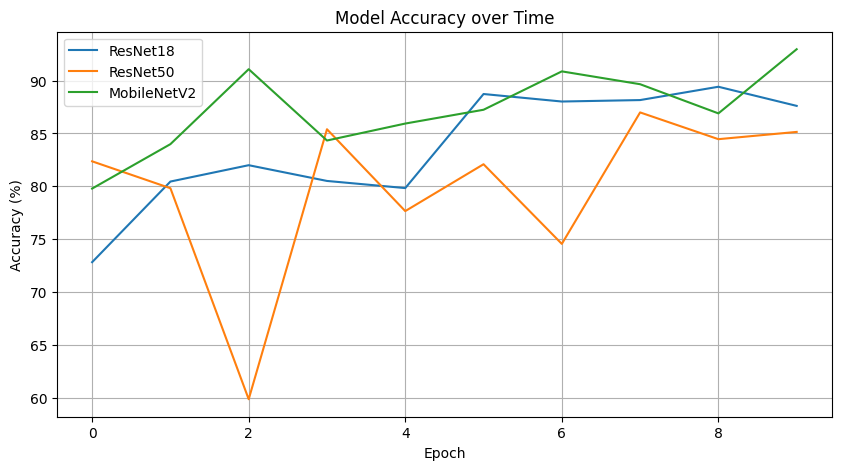

In [ ]:
# Ver la mejor accuracy obtenida por los tres modelos
print(f"Mejor accuracy: {history_m1_complete['best_val_acc']:.2f}% en epoch {history_m1_complete['best_epoch']} para el modelo resnet18")
print(f"Mejor accuracy: {history_m2_complete['best_val_acc']:.2f}% en epoch {history_m2_complete['best_epoch']} para el modelo resnet50")
print(f"Mejor accuracy: {history_m3_complete['best_val_acc']:.2f}% en epoch {history_m3_complete['best_epoch']} para el modelo mobilenet_v2")

# Ver la accuracy final de los tres modelos
plt.figure(figsize=(10, 5))
plt.plot(history_m1_complete['val_acc'], label='ResNet18')
plt.plot(history_m2_complete['val_acc'], label='ResNet50')
plt.plot(history_m3_complete['val_acc'], label='MobileNetV2')
plt.title('Model Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

### **3-Análisis de resultados del modelo (20%)**

#### **3.1-Análisis de resultados del modelo con datos coarse**

De acuerdo con los resultados obtenidos, se observa que el modelo que mejor accuracy obtuvo fue de: 91.25% en epoch 8 para el modelo mobilenet_v2. A continuación, se mostrará la matriz de confusión de este modelo.

In [ ]:
##########################
# Testing
###########################

print("\nTesting best model...")
model_final = get_model('mobilenet_v2', num_classes=num_classes)
model_final.load_state_dict(torch.load('best_model_mobilenet_v2.pth'))

metrics = test_model(model_final, val_loader, criterion, device=device)

print(f"F1-Score: {metrics['f1_score']:.2f}%")
print(f"Precision: {metrics['precision']:.2f}%")
print(f"Recall: {metrics['recall']:.2f}%")



Testing best model...


/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 33/33 [02:13<00:00,  4.05s/it, loss=0.0221, acc=83.38%, f1=88.79%, prec=97.37%, rec=83.62%]



Test Results:
Loss: 0.0221
Accuracy: 83.38%
F1-Score: 85.78%
Precision: 91.46%
Recall: 83.38%
F1-Score: 85.78%
Precision: 91.46%
Recall: 83.38%


In [ ]:
print("\nClassification Report:")
print(classification_report(metrics["true_labels"], metrics["predictions"]))


Classification Report:


/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lgomez

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       110
           1       0.67      0.40      0.50         5
           2       1.00      0.67      0.80         6
           3       1.00      0.80      0.89         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.09      0.33      0.14         3
           7       0.97      0.85      0.91        80
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         0
          11       1.00      1.00      1.00         5
          12       1.00      0.60      0.75         5
          13       0.47      1.00      0.64        15
          14       1.00      0.80      0.89         5
          16       0.00      0.00      0.00         5
          17       0.25      0.80      0.38         5
          18       0.31    

/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix:


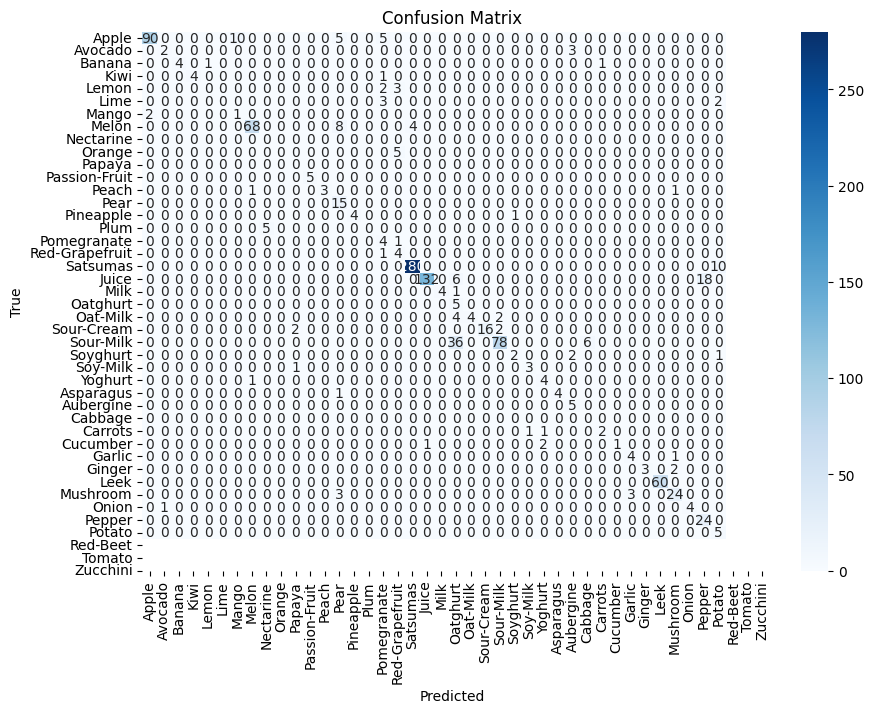

In [ ]:
print("\nConfusion Matrix:")

cm = confusion_matrix(metrics["true_labels"], metrics["predictions"])

class_names = [class_csv[class_csv['Coarse Class ID (int)'] == i]['Coarse Class Name (str)'].values[0] for i in range(total_number_coarse_classes)]
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Cuando son alrededor de 40 clases el mejor modelo es el de mobileNetv2. Analizando el reporte de clasificación se obtuvo que las mejores clasificaciones fueron: 

- Clase 19 (F1 = 0.98, precisión = 0.99, recall = 0.97)
- Clase 38 (F1 = 1.00, precisión = 1.00, recall = 1.00)
- Clase 7 (F1 = 0.91, precisión = 0.97, recall = 0.85) 
- Clase 20 (F1 = 0.91, precisión = 0.99, recall = 0.85) 
- Clase 11 (F1 = 1.00, precisión = 1.00, recall = 1.00) 

Por otro lado, las peores clasificaciones fueron:

- Clases 4, 5, 8, 9, 10, 16, 33 (F1 = 0.00) - Falló completamente en estas clases
- Clase 6 (F1 = 0.14, precisión = 0.09, recall = 0.33) - Muy bajo rendimiento
- Clase 22 (F1 = 0.18, precisión = 0.10, recall = 1.00) - Muy baja precisión aunque alto recall

De las que falló completamente es importante para el negocio considerar que se deben mejorar estas clases. En particular, esto pudo haber pasado dado que las clases no estaban balanceadas y solo tienen en train:

- Clase 4 (Lemon): 0.45%
- Clase 5 (Lime): 0.33%
- Clase 9 (Orange): 0.61%
- Clase 16 (Pomegranate): 0.28%

Por otro lado las clases 8,10 y 33 dieron 0 porque no se encontraron en el set de validación y tenían cero muestras lo que bajó las métricas en el reporte de clasificación en macro avg.

In [ ]:
print(train_merged[train_merged["Coarse Class ID (int)"] == 16]["Coarse Class Name (str)"].unique())
(train_merged[train_merged["Coarse Class ID (int)"] == 16]["Coarse Class Name (str)"].count()/ train_merged.shape[0])* 100

['Pomegranate']


0.2770968773313439

#### **3.2-Análisis de resultados del modelo con datos completos**

Ahora luego de haber entrenado los modelos es importante comparar en el set de validación cuál obtuvo mejor accuracy. Este fue con una accuracy: 92.97% en epoch 10 para el modelo mobilenet_v2. Por lo que igual que con los datos de coarse se corre test con mobileNetv2.

In [ ]:
##########################
# Testing model3_complete
###########################

print("\nTesting best model...")
model_final_complete = get_model('mobilenet_v2', num_classes=num_classes_complete)
model_final_complete.load_state_dict(torch.load('best_model_mobilenet_v2_complete.pth'))

metrics_complete = test_model(model_final_complete, val_loader_complete, criterion, device=device)

print(f"F1-Score: {metrics_complete['f1_score']:.2f}%")
print(f"Precision: {metrics_complete['precision']:.2f}%")
print(f"Recall: {metrics_complete['recall']:.2f}%")



Testing best model...


/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 33/33 [02:07<00:00,  3.86s/it, loss=0.0169, acc=85.49%, f1=90.18%, prec=98.68%, rec=85.62%]



Test Results:
Loss: 0.0169
Accuracy: 85.49%
F1-Score: 87.27%
Precision: 91.76%
Recall: 85.49%
F1-Score: 87.27%
Precision: 91.76%
Recall: 85.49%


In [ ]:
print("\nClassification Report:")
print(classification_report(metrics_complete["true_labels"], metrics_complete["predictions"]))


Classification Report:


/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lgomez

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       110
           1       0.42      1.00      0.59         5
           2       1.00      0.67      0.80         6
           3       0.44      0.80      0.57         5
           4       0.75      0.60      0.67         5
           5       1.00      0.20      0.33         5
           6       0.20      0.33      0.25         3
           7       0.83      0.75      0.79        80
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         0
          11       0.80      0.80      0.80         5
          12       0.75      0.60      0.67         5
          13       0.60      0.60      0.60        15
          14       0.80      0.80      0.80         5
          16       1.00      0.60      0.75         5
          17       0.50      0.60      0.55         5
          18       0.40    

/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lgomez/anaconda3/envs/cda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("\nConfusion Matrix:")

cm = confusion_matrix(metrics_complete["true_labels"], metrics_complete["predictions"])

class_names = [class_csv[class_csv['Class ID (int)'] == i]['Class Name (str)'].values[0] for i in range(total_number_coarse_classes)]
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix:


KeyboardInterrupt: 

### **Generación de valor (20%)**

### **Insights (20%)**